In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [110]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        print(df.shape)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
'''# Handling outlier, (if there are)
# New version
def handler_cm(cm_beUsed, time_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(0, len(cm_beUsed)-1):
        gradient = (cm_beUsed[i+1]-cm_beUsed[i])/(time_beUsed[i+1]-time_beUsed[i])
        if np.abs(gradient) > 55:
            cm_beUsed[i] = cm_beUsed[i+2*period] 
            cm_beUsed[i] = gradient*time_beUsed[i+1] + cm_beUsed[i+1]
            
    return cm_beUsed'''

'# Handling outlier, (if there are)\n# New version\ndef handler_cm(cm_beUsed, time_beUsed):\n    period = int(len(cm_beUsed) / 5)\n    for i in range(0, len(cm_beUsed)-1):\n        gradient = (cm_beUsed[i+1]-cm_beUsed[i])/(time_beUsed[i+1]-time_beUsed[i])\n        if np.abs(gradient) > 55:\n            cm_beUsed[i] = cm_beUsed[i+2*period] \n            cm_beUsed[i] = gradient*time_beUsed[i+1] + cm_beUsed[i+1]\n            \n    return cm_beUsed'

In [15]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [16]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [17]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [18]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [133]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

(17587, 2)
(11210, 2)
(11161, 2)
(12668, 2)
(11525, 2)
(12900, 2)
(12088, 2)
(16024, 2)
(12449, 2)
(24941, 2)
(7643, 2)
(10952, 2)
(11919, 2)
(10753, 2)
(10792, 2)
(11199, 2)
Dimension - time and Cm:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - x:  (80000, 3)
Dimension - y:  (80000, 1)


In [20]:
x -=10

In [21]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [22]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [23]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [24]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
model_directory = "D:\\TrainedModels\\20221227_flap1_2_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [27]:
ckpt_name = model_directory + "20221227unsteadyPrediction_MLP_flap1_2_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [28]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [29]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
47/55 [========================>.....] - ETA: 0s - loss: 0.1137 - rmse: 0.3371
Epoch 1: val_loss improved from inf to 0.00210, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 2s 9ms/step - loss: 0.0974 - rmse: 0.3120 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 2/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.3436e-04 - rmse: 0.0288
Epoch 2: val_loss improved from 0.00210 to 0.00078, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 6ms/step - loss: 9.1580e-04 - rmse: 0.0285 - val_loss: 7.8497e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 3/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.5470e-04 - rmse: 0.0255
Epo

Epoch 19/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.7783e-04 - rmse: 0.0242
Epoch 19: val_loss improved from 0.00070 to 0.00069, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.7388e-04 - rmse: 0.0242 - val_loss: 6.9293e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 20/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.7100e-04 - rmse: 0.0241
Epoch 20: val_loss improved from 0.00069 to 0.00069, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.6906e-04 - rmse: 0.0241 - val_loss: 6.9068e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 21/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.9096e-

55/55 [==============================] - 0s 9ms/step - loss: 6.0992e-04 - rmse: 0.0231 - val_loss: 6.1569e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 38/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.9040e-04 - rmse: 0.0227
Epoch 38: val_loss improved from 0.00062 to 0.00061, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.9214e-04 - rmse: 0.0227 - val_loss: 6.1311e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 39/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.9946e-04 - rmse: 0.0229
Epoch 39: val_loss improved from 0.00061 to 0.00061, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.1364e-04 - rmse: 

55/55 [==============================] - 0s 8ms/step - loss: 4.8753e-04 - rmse: 0.0206 - val_loss: 5.0471e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 57/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7955e-04 - rmse: 0.0204
Epoch 57: val_loss improved from 0.00050 to 0.00049, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.7691e-04 - rmse: 0.0203 - val_loss: 4.8692e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 58/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7247e-04 - rmse: 0.0202
Epoch 58: val_loss improved from 0.00049 to 0.00048, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.7006e-04 - rmse: 

55/55 [==============================] - 1s 9ms/step - loss: 3.2756e-04 - rmse: 0.0165 - val_loss: 2.9627e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 76/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9872e-04 - rmse: 0.0156
Epoch 76: val_loss improved from 0.00030 to 0.00029, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.9627e-04 - rmse: 0.0155 - val_loss: 2.8894e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 77/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1028e-04 - rmse: 0.0160
Epoch 77: val_loss did not improve from 0.00029
55/55 [==============================] - 0s 8ms/step - loss: 3.0596e-04 - rmse: 0.0158 - val_loss: 2.8944e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 78/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7034e-04 - rmse: 0.0147
Epoc

Epoch 98/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6662e-04 - rmse: 0.0109
Epoch 98: val_loss improved from 0.00016 to 0.00015, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.6206e-04 - rmse: 0.0106 - val_loss: 1.5473e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 99/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.8540e-04 - rmse: 0.0117
Epoch 99: val_loss did not improve from 0.00015
55/55 [==============================] - 0s 8ms/step - loss: 1.8516e-04 - rmse: 0.0117 - val_loss: 2.7902e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 100/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7062e-04 - rmse: 0.0111
Epoch 100: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_f

55/55 [==============================] - 0s 9ms/step - loss: 1.6931e-04 - rmse: 0.0112 - val_loss: 1.2351e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 122/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.8150e-04 - rmse: 0.0117
Epoch 122: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.7565e-04 - rmse: 0.0115 - val_loss: 1.2955e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 123/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.5021e-04 - rmse: 0.0103
Epoch 123: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.4859e-04 - rmse: 0.0102 - val_loss: 1.5201e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 124/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4817e-04 - rmse: 0.0102
Epoch 124: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.6309e-04 - rmse: 0.0109 - val_loss: 1.5591e-04 - val_rm

50/55 [==========================>...] - ETA: 0s - loss: 1.2895e-04 - rmse: 0.0094
Epoch 147: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.2487e-04 - rmse: 0.0092 - val_loss: 1.1328e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 148/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2759e-04 - rmse: 0.0093
Epoch 148: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.2622e-04 - rmse: 0.0093 - val_loss: 1.3321e-04 - val_rmse: 0.0096 - lr: 1.0000e-04
Epoch 149/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3682e-04 - rmse: 0.0098
Epoch 149: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3242e-04 - rmse: 0.0096 - val_loss: 1.1207e-04 - 

50/55 [==========================>...] - ETA: 0s - loss: 1.6015e-04 - rmse: 0.0110
Epoch 173: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.5352e-04 - rmse: 0.0107 - val_loss: 1.0922e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 174/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2163e-04 - rmse: 0.0091
Epoch 174: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.2228e-04 - rmse: 0.0092 - val_loss: 1.2150e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 175/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2334e-04 - rmse: 0.0092
Epoch 175: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.2598e-04 - rmse: 0.0094 - val_loss: 1.4965e-04 - 

Epoch 199/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1292e-04 - rmse: 0.0087
Epoch 199: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.1919e-04 - rmse: 0.0091 - val_loss: 1.1236e-04 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 200/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0966e-04 - rmse: 0.0085
Epoch 200: val_loss improved from 0.00011 to 0.00010, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.0550e-04 - rmse: 0.0083 - val_loss: 1.0443e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 201/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3539e-04 - rmse: 0.0099
Epoch 201: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.2880e-04 - rmse: 0.0096 - val_los

Epoch 225/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0805e-04 - rmse: 0.0085
Epoch 225: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0493e-04 - rmse: 0.0083 - val_loss: 1.0233e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 226/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.0307e-04 - rmse: 0.0082
Epoch 226: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0033e-04 - rmse: 0.0081 - val_loss: 1.0382e-04 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 227/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0488e-04 - rmse: 0.0083
Epoch 227: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0430e-04 - rmse: 0.0083 - val_loss: 1.0281e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 228/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.8682e-05 - rmse: 0.0080
Epoch 228: val_loss

49/55 [=========================>....] - ETA: 0s - loss: 9.9983e-05 - rmse: 0.0081
Epoch 252: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 9.6700e-05 - rmse: 0.0079 - val_loss: 1.0918e-04 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 253/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0620e-04 - rmse: 0.0085
Epoch 253: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0339e-04 - rmse: 0.0083 - val_loss: 1.1923e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 254/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0985e-04 - rmse: 0.0087
Epoch 254: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0617e-04 - rmse: 0.0085 - val_loss: 1.1938e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 255/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2343e-04 - rmse: 0.0094
Epoch 255: val_loss did not improve

Epoch 279/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.2185e-05 - rmse: 0.0077
Epoch 279: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 9.6495e-05 - rmse: 0.0079 - val_loss: 1.2967e-04 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 280/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.1228e-04 - rmse: 0.0089
Epoch 280: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0789e-04 - rmse: 0.0086 - val_loss: 1.4237e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 281/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.0469e-05 - rmse: 0.0069
Epoch 281: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.0182e-04 - rmse: 0.0083 - val_loss: 9.9747e-05 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 282/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.8302e-05 - rmse: 0.0081
Epoch 282: val_loss

49/55 [=========================>....] - ETA: 0s - loss: 1.0380e-04 - rmse: 0.0084
Epoch 305: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 9.9732e-05 - rmse: 0.0082 - val_loss: 9.6352e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 306/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.0115e-05 - rmse: 0.0061
Epoch 306: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 6.9306e-05 - rmse: 0.0061 - val_loss: 9.7084e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 307/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1376e-04 - rmse: 0.0090
Epoch 307: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 8ms/step - loss: 1.1069e-04 - rmse: 0.0088 - val_loss: 1.2785e-04 - 

49/55 [=========================>....] - ETA: 0s - loss: 9.2284e-05 - rmse: 0.0078
Epoch 331: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.0002e-05 - rmse: 0.0076 - val_loss: 9.9859e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 332/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.4847e-05 - rmse: 0.0079
Epoch 332: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.1779e-05 - rmse: 0.0077 - val_loss: 1.0726e-04 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 333/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.9472e-05 - rmse: 0.0082
Epoch 333: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.6541e-05 - rmse: 0.0080 - val_loss: 9.9355e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 334/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.2736e-05 - rmse: 0.0078
Epoch 334: val_loss did not improve

55/55 [==============================] - 0s 7ms/step - loss: 9.7638e-05 - rmse: 0.0082 - val_loss: 1.1039e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 359/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.9791e-05 - rmse: 0.0070
Epoch 359: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 7.8643e-05 - rmse: 0.0069 - val_loss: 1.1242e-04 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 360/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0199e-04 - rmse: 0.0084
Epoch 360: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 1.0171e-04 - rmse: 0.0084 - val_loss: 1.3130e-04 - val_rmse: 0.0100 - lr: 1.0000e-04
Epoch 361/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.3254e-05 - rmse: 0.0079
Epoch 361: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.2049e-05 - rmse: 0.0078 - val_loss: 1.2988e-04 - val_rm

51/55 [==========================>...] - ETA: 0s - loss: 8.3313e-05 - rmse: 0.0073
Epoch 385: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.2956e-05 - rmse: 0.0072 - val_loss: 1.0221e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 386/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0711e-04 - rmse: 0.0088
Epoch 386: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 1.0802e-04 - rmse: 0.0088 - val_loss: 9.2918e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 387/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.0804e-05 - rmse: 0.0071
Epoch 387: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.8107e-05 - rmse: 0.0082 - val_loss: 1.7019e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 388/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.9510e-05 - rmse: 0.0063
Epoch 388: val_loss improved from 0

Epoch 411/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.7987e-05 - rmse: 0.0069
Epoch 411: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 7.5898e-05 - rmse: 0.0068 - val_loss: 9.4753e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 412/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1621e-04 - rmse: 0.0093
Epoch 412: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 1.1326e-04 - rmse: 0.0091 - val_loss: 1.1313e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 413/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.6295e-05 - rmse: 0.0081
Epoch 413: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.2222e-05 - rmse: 0.0079 - val_loss: 9.5893e-05 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 414/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.5854e-05 - rmse: 0.0060
Epoch 414: val_loss

49/55 [=========================>....] - ETA: 0s - loss: 8.9997e-05 - rmse: 0.0078
Epoch 437: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.6537e-05 - rmse: 0.0075 - val_loss: 8.8093e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 438/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.1126e-05 - rmse: 0.0072
Epoch 438: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 7.8618e-05 - rmse: 0.0070 - val_loss: 9.6718e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 439/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.6394e-05 - rmse: 0.0075
Epoch 439: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.7653e-05 - rmse: 0.0076 - val_loss: 9.2009e-05 - 

49/55 [=========================>....] - ETA: 0s - loss: 1.0060e-04 - rmse: 0.0084
Epoch 463: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.6003e-05 - rmse: 0.0082 - val_loss: 9.3844e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 464/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.6448e-05 - rmse: 0.0076
Epoch 464: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.6868e-05 - rmse: 0.0076 - val_loss: 1.0322e-04 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 465/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.4067e-05 - rmse: 0.0074
Epoch 465: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.1285e-05 - rmse: 0.0072 - val_loss: 8.6613e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 466/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.9849e-05 - rmse: 0.0071
Epoch 466: val_loss did not improve

Epoch 490/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.5378e-05 - rmse: 0.0075
Epoch 490: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.7438e-05 - rmse: 0.0076 - val_loss: 8.7119e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 491/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.0871e-05 - rmse: 0.0072
Epoch 491: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 9.6208e-05 - rmse: 0.0082 - val_loss: 9.0565e-05 - val_rmse: 0.0078 - lr: 1.0000e-04
Epoch 492/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.7297e-05 - rmse: 0.0062
Epoch 492: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 7.0525e-05 - rmse: 0.0064 - val_loss: 8.5881e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 493/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.2651e-05 - rmse: 0.0073
Epoch 493: val_loss

52/55 [===========================>..] - ETA: 0s - loss: 8.0966e-05 - rmse: 0.0072
Epoch 515: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.9858e-05 - rmse: 0.0071 - val_loss: 1.0141e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 516/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.7603e-05 - rmse: 0.0077
Epoch 516: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 8.4463e-05 - rmse: 0.0075 - val_loss: 8.5812e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 517/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.0144e-05 - rmse: 0.0078
Epoch 517: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 8.8749e-05 - rmse: 0.0077 - val_loss: 1.3568e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 518/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.9979e-05 - rmse: 0.0072
Epoch 518: val_loss did not improve

55/55 [==============================] - 0s 8ms/step - loss: 5.8086e-05 - rmse: 0.0054 - val_loss: 1.0222e-04 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 543/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.6500e-05 - rmse: 0.0069
Epoch 543: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.3351e-05 - rmse: 0.0067 - val_loss: 8.3604e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 544/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0297e-04 - rmse: 0.0086
Epoch 544: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 9.8715e-05 - rmse: 0.0084 - val_loss: 1.0169e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 545/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.7885e-05 - rmse: 0.0054
Epoch 545: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 5.7180e-05 - rmse: 0.0053 - val_loss: 8.8129e-05 - val_rm

Epoch 569/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.9328e-05 - rmse: 0.0071
Epoch 569: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.7480e-05 - rmse: 0.0070 - val_loss: 8.3731e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 570/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.2958e-05 - rmse: 0.0067
Epoch 570: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.1130e-05 - rmse: 0.0065 - val_loss: 9.1494e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 571/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.1435e-05 - rmse: 0.0065
Epoch 571: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 6.8622e-05 - rmse: 0.0063 - val_loss: 8.5919e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 572/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.9377e-05 - rmse: 0.0078
Epoch 572: val_loss

Epoch 596/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.4233e-05 - rmse: 0.0075
Epoch 596: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 8.5040e-05 - rmse: 0.0075 - val_loss: 8.1941e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 597/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.6869e-05 - rmse: 0.0062
Epoch 597: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.9815e-05 - rmse: 0.0064 - val_loss: 8.1047e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 598/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.2237e-05 - rmse: 0.0066
Epoch 598: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.0536e-05 - rmse: 0.0065 - val_los

55/55 [==============================] - 0s 9ms/step - loss: 6.7455e-05 - rmse: 0.0062 - val_loss: 7.9926e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 621/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.8216e-05 - rmse: 0.0071
Epoch 621: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 7.7545e-05 - rmse: 0.0070 - val_loss: 8.0360e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 622/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.1118e-05 - rmse: 0.0065
Epoch 622: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.0699e-05 - rmse: 0.0065 - val_loss: 1.0143e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 623/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.5228e-05 - rmse: 0.0068
Epoch 623: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.3725e-05 - rmse: 0.0067 - val_loss: 8.8606e-05 - val_rm

Epoch 648/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.7228e-05 - rmse: 0.0043
Epoch 648: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.7518e-05 - rmse: 0.0044 - val_loss: 7.9021e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 649/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.2614e-05 - rmse: 0.0080
Epoch 649: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 8.9068e-05 - rmse: 0.0078 - val_loss: 8.4634e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 650/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.6501e-05 - rmse: 0.0053
Epoch 650: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 5.5893e-05 - rmse: 0.0052 - val_los

49/55 [=========================>....] - ETA: 0s - loss: 7.3362e-05 - rmse: 0.0067
Epoch 674: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.0705e-05 - rmse: 0.0065 - val_loss: 7.9145e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 675/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.1495e-05 - rmse: 0.0048
Epoch 675: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 5.1508e-05 - rmse: 0.0048 - val_loss: 8.9964e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 676/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.1628e-05 - rmse: 0.0080
Epoch 676: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.7088e-05 - rmse: 0.0077 - val_loss: 7.7830e-05 - 

50/55 [==========================>...] - ETA: 0s - loss: 6.9878e-05 - rmse: 0.0065
Epoch 700: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.2432e-05 - rmse: 0.0067 - val_loss: 8.0627e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 701/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.0674e-05 - rmse: 0.0047
Epoch 701: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 4.9832e-05 - rmse: 0.0047 - val_loss: 7.7547e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 702/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.6047e-05 - rmse: 0.0062
Epoch 702: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.9823e-05 - rmse: 0.0072 - val_loss: 1.1014e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 703/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.4417e-05 - rmse: 0.0051
Epoch 703: val_loss did not improve

55/55 [==============================] - 0s 8ms/step - loss: 6.3982e-05 - rmse: 0.0060 - val_loss: 7.7585e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 728/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.1897e-05 - rmse: 0.0066
Epoch 728: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 6.9366e-05 - rmse: 0.0064 - val_loss: 8.0015e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 729/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.9481e-05 - rmse: 0.0064
Epoch 729: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 6.8464e-05 - rmse: 0.0064 - val_loss: 7.7484e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 730/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.0824e-05 - rmse: 0.0065
Epoch 730: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 6.9330e-05 - rmse: 0.0064 - val_loss: 1.0967e-04 - val_rm

Epoch 754/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8239e-05 - rmse: 0.0063
Epoch 754: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 6.6847e-05 - rmse: 0.0062 - val_loss: 8.1836e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 755/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7854e-05 - rmse: 0.0045
Epoch 755: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 5.1642e-05 - rmse: 0.0049 - val_loss: 8.5158e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 756/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.6070e-05 - rmse: 0.0076
Epoch 756: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 8.2555e-05 - rmse: 0.0074 - val_loss: 7.9384e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 757/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.2455e-05 - rmse: 0.0049
Epoch 757: val_loss

Epoch 781/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.6130e-05 - rmse: 0.0062
Epoch 781: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.3912e-05 - rmse: 0.0060 - val_loss: 8.6125e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 782/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.3365e-05 - rmse: 0.0060
Epoch 782: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.2028e-05 - rmse: 0.0058 - val_loss: 7.4751e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 783/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.3049e-05 - rmse: 0.0059
Epoch 783: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.2277e-05 - rmse: 0.0059 - val_loss: 7.5364e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 784/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.2025e-05 - rmse: 0.0066
Epoch 784: val_loss

49/55 [=========================>....] - ETA: 0s - loss: 6.5872e-05 - rmse: 0.0062
Epoch 807: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.3466e-05 - rmse: 0.0060 - val_loss: 7.4341e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 808/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.7201e-05 - rmse: 0.0077
Epoch 808: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 8.3191e-05 - rmse: 0.0074 - val_loss: 8.0718e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 809/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5868e-05 - rmse: 0.0042
Epoch 809: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.4903e-05 - rmse: 0.0041 - val_loss: 7.3693e-05 - 

49/55 [=========================>....] - ETA: 0s - loss: 6.6888e-05 - rmse: 0.0063
Epoch 833: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.4350e-05 - rmse: 0.0060 - val_loss: 7.5051e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 834/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.2304e-05 - rmse: 0.0059
Epoch 834: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.9925e-05 - rmse: 0.0057 - val_loss: 7.3008e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 835/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.5196e-05 - rmse: 0.0061
Epoch 835: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.3185e-05 - rmse: 0.0060 - val_loss: 7.7988e-05 - 

52/55 [===========================>..] - ETA: 0s - loss: 4.3697e-05 - rmse: 0.0040
Epoch 859: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 4.3316e-05 - rmse: 0.0040 - val_loss: 7.3455e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 860/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.9369e-05 - rmse: 0.0079
Epoch 860: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 8.6812e-05 - rmse: 0.0077 - val_loss: 7.2967e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 861/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.4336e-05 - rmse: 0.0061
Epoch 861: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.2220e-05 - rmse: 0.0059 - val_loss: 8.3783e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 862/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.8325e-05 - rmse: 0.0055
Epoch 862: val_loss did not improve

Epoch 886/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.1154e-05 - rmse: 0.0066
Epoch 886: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.8276e-05 - rmse: 0.0064 - val_loss: 7.7371e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 887/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.3136e-05 - rmse: 0.0060
Epoch 887: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 7.7978e-05 - rmse: 0.0071 - val_loss: 8.7352e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 888/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8839e-05 - rmse: 0.0046
Epoch 888: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 4.8915e-05 - rmse: 0.0046 - val_loss: 7.8758e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 889/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.2460e-05 - rmse: 0.0059
Epoch 889: val_loss

Epoch 912/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.3159e-05 - rmse: 0.0060
Epoch 912: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.1750e-05 - rmse: 0.0059 - val_loss: 8.0167e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 913/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.7375e-05 - rmse: 0.0055
Epoch 913: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.0528e-05 - rmse: 0.0058 - val_loss: 7.3620e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 914/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.7125e-05 - rmse: 0.0063
Epoch 914: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.5022e-05 - rmse: 0.0061 - val_loss: 7.3738e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 915/10000
48/55 [=========================>....] - ETA: 0s - loss: 4.1392e-05 - rmse: 0.0037
Epoch 915: val_loss

Epoch 939/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.6344e-05 - rmse: 0.0054
Epoch 939: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.4694e-05 - rmse: 0.0052 - val_loss: 7.0194e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 940/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.4417e-05 - rmse: 0.0061
Epoch 940: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.2087e-05 - rmse: 0.0059 - val_loss: 7.3945e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 941/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0594e-05 - rmse: 0.0058
Epoch 941: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.8924e-05 - rmse: 0.0056 - val_los

51/55 [==========================>...] - ETA: 0s - loss: 3.9695e-05 - rmse: 0.0035
Epoch 965: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 3.9778e-05 - rmse: 0.0035 - val_loss: 6.9863e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 966/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.0995e-05 - rmse: 0.0073
Epoch 966: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 7.8103e-05 - rmse: 0.0071 - val_loss: 8.6116e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 967/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.5090e-05 - rmse: 0.0053
Epoch 967: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.3051e-05 - rmse: 0.0051 - val_loss: 7.3997e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 968/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4178e-05 - rmse: 0.0041
Epoch 968: val_loss did not improve

55/55 [==============================] - 0s 8ms/step - loss: 6.8768e-05 - rmse: 0.0065 - val_loss: 7.7345e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 993/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.6836e-05 - rmse: 0.0044
Epoch 993: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 4.5783e-05 - rmse: 0.0043 - val_loss: 6.9538e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 994/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.5522e-05 - rmse: 0.0053
Epoch 994: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.4019e-05 - rmse: 0.0052 - val_loss: 7.3832e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 995/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.2867e-05 - rmse: 0.0060
Epoch 995: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.0445e-05 - rmse: 0.0058 - val_loss: 7.1991e-05 - val_rm

51/55 [==========================>...] - ETA: 0s - loss: 6.3643e-05 - rmse: 0.0061
Epoch 1019: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.1771e-05 - rmse: 0.0059 - val_loss: 7.5105e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 1020/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0321e-05 - rmse: 0.0058
Epoch 1020: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.8288e-05 - rmse: 0.0056 - val_loss: 6.8943e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1021/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.3593e-05 - rmse: 0.0052
Epoch 1021: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.2128e-05 - rmse: 0.0050 - val_loss: 7.6148e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 1022/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.4354e-05 - rmse: 0.0061
Epoch 1022: val_loss did not 

51/55 [==========================>...] - ETA: 0s - loss: 6.0337e-05 - rmse: 0.0058
Epoch 1046: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.2839e-05 - rmse: 0.0060 - val_loss: 7.3340e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1047/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.0443e-05 - rmse: 0.0066
Epoch 1047: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.9132e-05 - rmse: 0.0065 - val_loss: 7.2393e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1048/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.7946e-05 - rmse: 0.0056
Epoch 1048: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.5842e-05 - rmse: 0.0054 - val_loss: 7.0482e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1049/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9332e-05 - rmse: 0.0035
Epoch 1049: val_loss did not 

Epoch 1074/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.1945e-05 - rmse: 0.0059
Epoch 1074: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.9774e-05 - rmse: 0.0058 - val_loss: 6.9027e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1075/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.5529e-05 - rmse: 0.0054
Epoch 1075: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.4185e-05 - rmse: 0.0053 - val_loss: 7.2552e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1076/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.9010e-05 - rmse: 0.0057
Epoch 1076: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.8259e-05 - rmse: 0.0056 - val_loss: 1.0345e-04 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 1077/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.9269e-05 - rmse: 0.0036
Epoch 1077: 

Epoch 1101/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.3937e-05 - rmse: 0.0069
Epoch 1101: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 7.0777e-05 - rmse: 0.0067 - val_loss: 8.3164e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 1102/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.0034e-05 - rmse: 0.0037
Epoch 1102: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.9283e-05 - rmse: 0.0036 - val_loss: 6.7049e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1103/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.5705e-05 - rmse: 0.0054
Epoch 1103: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.3590e-05 - rmse: 0.0052 - v

50/55 [==========================>...] - ETA: 0s - loss: 5.2519e-05 - rmse: 0.0051
Epoch 1128: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.0815e-05 - rmse: 0.0050 - val_loss: 6.8277e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1129/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.3039e-05 - rmse: 0.0061
Epoch 1129: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.0726e-05 - rmse: 0.0059 - val_loss: 6.9293e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1130/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.5825e-05 - rmse: 0.0054
Epoch 1130: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.3079e-05 - rmse: 0.0052 - val_loss: 6.7424e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1131/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2867e-05 - rmse: 0.0041
Epoch 1131: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 7.2756e-05 - rmse: 0.0068
Epoch 1155: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.9260e-05 - rmse: 0.0066 - val_loss: 6.8976e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1156/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.1652e-05 - rmse: 0.0039
Epoch 1156: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 4.1186e-05 - rmse: 0.0039 - val_loss: 7.1964e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1157/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2721e-05 - rmse: 0.0052
Epoch 1157: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.4605e-05 - rmse: 0.0053 - val_loss: 6.8432e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1158/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2867e-05 - rmse: 0.0052
Epoch 1158: val_loss did not 

Epoch 1182/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.6450e-05 - rmse: 0.0032
Epoch 1182: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 3.6026e-05 - rmse: 0.0032 - val_loss: 6.7416e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1183/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.0046e-05 - rmse: 0.0074
Epoch 1183: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 7.6246e-05 - rmse: 0.0071 - val_loss: 7.8174e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 1184/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8299e-05 - rmse: 0.0057
Epoch 1184: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 5.6267e-05 - rmse: 0.0055 - val_loss: 6.7838e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1185/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.5191e-05 - rmse: 0.0030
Epoch 1185: 

50/55 [==========================>...] - ETA: 0s - loss: 3.2408e-05 - rmse: 0.0026
Epoch 1209: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 3.2241e-05 - rmse: 0.0025 - val_loss: 6.7119e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1210/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.5308e-05 - rmse: 0.0063
Epoch 1210: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.1918e-05 - rmse: 0.0060 - val_loss: 6.9177e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1211/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.1480e-05 - rmse: 0.0051
Epoch 1211: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.4590e-05 - rmse: 0.0054 - val_loss: 6.9664e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1212/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8337e-05 - rmse: 0.0057
Epoch 1212: val_loss did not 

Epoch 1237/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0540e-05 - rmse: 0.0050
Epoch 1237: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.2848e-05 - rmse: 0.0052 - val_loss: 6.6670e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1238/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.6202e-05 - rmse: 0.0055
Epoch 1238: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.3669e-05 - rmse: 0.0053 - val_loss: 6.6902e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1239/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.0207e-05 - rmse: 0.0050
Epoch 1239: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 5.2744e-05 - rmse: 0.0052 - val_loss: 7.1589e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1240/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.1670e-05 - rmse: 0.0051
Epoch 1240: 

Epoch 1264/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.0526e-05 - rmse: 0.0050
Epoch 1264: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 4.8644e-05 - rmse: 0.0048 - val_loss: 6.5694e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1265/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.9795e-05 - rmse: 0.0059
Epoch 1265: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.8127e-05 - rmse: 0.0057 - val_loss: 6.5351e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1266/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.8573e-05 - rmse: 0.0048
Epoch 1266: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 4.7572e-05 - rmse: 0.0047 - v

Epoch 1291/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.4875e-05 - rmse: 0.0054
Epoch 1291: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.2263e-05 - rmse: 0.0052 - val_loss: 6.6762e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1292/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.7152e-05 - rmse: 0.0057
Epoch 1292: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.4192e-05 - rmse: 0.0054 - val_loss: 6.5965e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1293/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2125e-05 - rmse: 0.0052
Epoch 1293: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 5.0392e-05 - rmse: 0.0050 - val_loss: 6.5245e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1294/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5252e-05 - rmse: 0.0032
Epoch 1294: 

49/55 [=========================>....] - ETA: 0s - loss: 5.4731e-05 - rmse: 0.0055
Epoch 1318: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.2030e-05 - rmse: 0.0052 - val_loss: 6.5953e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1319/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.5262e-05 - rmse: 0.0071
Epoch 1319: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 7.0711e-05 - rmse: 0.0068 - val_loss: 6.9644e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 1320/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9038e-05 - rmse: 0.0020
Epoch 1320: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.8897e-05 - rmse: 0.0020 - val_loss: 6.4618e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1321/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.7907e-05 - rmse: 0.0057
Epoch 1321: val_loss did not 

Epoch 1346/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.4165e-05 - rmse: 0.0054
Epoch 1346: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.2737e-05 - rmse: 0.0053 - val_loss: 6.4731e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1347/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2524e-05 - rmse: 0.0053
Epoch 1347: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0924e-05 - rmse: 0.0051 - val_loss: 6.6115e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1348/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.2086e-05 - rmse: 0.0052
Epoch 1348: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0986e-05 - rmse: 0.0051 - val_loss: 6.8992e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1349/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.4151e-05 - rmse: 0.0031
Epoch 1349: 

Epoch 1373/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.2515e-05 - rmse: 0.0053
Epoch 1373: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0787e-05 - rmse: 0.0051 - val_loss: 6.5119e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1374/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.4104e-05 - rmse: 0.0054
Epoch 1374: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 5.2196e-05 - rmse: 0.0053 - val_loss: 6.5071e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1375/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.9725e-05 - rmse: 0.0059
Epoch 1375: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.7581e-05 - rmse: 0.0057 - val_loss: 6.4829e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1376/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3799e-05 - rmse: 0.0054
Epoch 1376: 

49/55 [=========================>....] - ETA: 0s - loss: 4.9698e-05 - rmse: 0.0050
Epoch 1400: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.7775e-05 - rmse: 0.0048 - val_loss: 6.6872e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1401/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2759e-05 - rmse: 0.0053
Epoch 1401: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0185e-05 - rmse: 0.0051 - val_loss: 6.6429e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1402/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3029e-05 - rmse: 0.0053
Epoch 1402: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.1274e-05 - rmse: 0.0052 - val_loss: 6.4061e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1403/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.4778e-05 - rmse: 0.0055
Epoch 1403: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 3.2600e-05 - rmse: 0.0029
Epoch 1426: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.2003e-05 - rmse: 0.0028 - val_loss: 6.4111e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1427/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.6898e-05 - rmse: 0.0048
Epoch 1427: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.5186e-05 - rmse: 0.0046 - val_loss: 6.4730e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1428/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.8544e-05 - rmse: 0.0059
Epoch 1428: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.5727e-05 - rmse: 0.0056 - val_loss: 6.3470e-

51/55 [==========================>...] - ETA: 0s - loss: 5.2016e-05 - rmse: 0.0053
Epoch 1453: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0240e-05 - rmse: 0.0051 - val_loss: 6.4514e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1454/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.2508e-05 - rmse: 0.0053
Epoch 1454: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.0182e-05 - rmse: 0.0051 - val_loss: 6.3386e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1455/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.2818e-05 - rmse: 0.0030
Epoch 1455: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8925e-05 - rmse: 0.0050 - val_loss: 6.7457e-

50/55 [==========================>...] - ETA: 0s - loss: 3.4971e-05 - rmse: 0.0033
Epoch 1479: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.4288e-05 - rmse: 0.0032 - val_loss: 6.4118e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1480/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2770e-05 - rmse: 0.0054
Epoch 1480: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.0641e-05 - rmse: 0.0052 - val_loss: 6.3092e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1481/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2816e-05 - rmse: 0.0054
Epoch 1481: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0511e-05 - rmse: 0.0052 - val_loss: 6.4426e-

51/55 [==========================>...] - ETA: 0s - loss: 5.2081e-05 - rmse: 0.0053
Epoch 1505: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.0373e-05 - rmse: 0.0052 - val_loss: 6.4794e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1506/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.1851e-05 - rmse: 0.0053
Epoch 1506: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.9423e-05 - rmse: 0.0051 - val_loss: 6.5228e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1507/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.0504e-05 - rmse: 0.0052
Epoch 1507: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8809e-05 - rmse: 0.0050 - val_loss: 6.4706e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1508/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.4076e-05 - rmse: 0.0055
Epoch 1508: val_loss did not 

51/55 [==========================>...] - ETA: 0s - loss: 6.3746e-05 - rmse: 0.0063
Epoch 1531: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.1037e-05 - rmse: 0.0061 - val_loss: 6.2887e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1532/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.7937e-05 - rmse: 0.0038
Epoch 1532: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.3715e-05 - rmse: 0.0055 - val_loss: 7.1381e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 1533/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.3483e-05 - rmse: 0.0055
Epoch 1533: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.1256e-05 - rmse: 0.0053 - val_loss: 6.4264e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1534/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5940e-05 - rmse: 0.0016
Epoch 1534: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 5.1081e-05 - rmse: 0.0053
Epoch 1558: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8805e-05 - rmse: 0.0051 - val_loss: 6.2700e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1559/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2057e-05 - rmse: 0.0054
Epoch 1559: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.9298e-05 - rmse: 0.0051 - val_loss: 6.3681e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1560/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.2141e-05 - rmse: 0.0054
Epoch 1560: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.9774e-05 - rmse: 0.0051 - val_loss: 6.2790e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1561/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0912e-05 - rmse: 0.0053
Epoch 1561: val_loss did not 

Epoch 1586/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.3136e-05 - rmse: 0.0071
Epoch 1586: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.9441e-05 - rmse: 0.0068 - val_loss: 6.8871e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1587/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.1891e-05 - rmse: 0.0054
Epoch 1587: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.9873e-05 - rmse: 0.0052 - val_loss: 6.6470e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1588/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.9629e-05 - rmse: 0.0052
Epoch 1588: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.8634e-05 - rmse: 0.0051 - val_loss: 7.6105e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 1589/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.2405e-05 - rmse: 0.0054
Epoch 1589: 

Epoch 1613/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7253e-05 - rmse: 0.0021
Epoch 1613: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.7055e-05 - rmse: 0.0021 - val_loss: 6.2296e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1614/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.0635e-05 - rmse: 0.0053
Epoch 1614: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8698e-05 - rmse: 0.0051 - val_loss: 6.4523e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1615/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0861e-05 - rmse: 0.0053
Epoch 1615: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8208e-05 - rmse: 0.0050 - val_loss: 6.2195e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1616/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2391e-05 - rmse: 0.0054
Epoch 1616: 

Epoch 1640/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0814e-05 - rmse: 0.0029
Epoch 1640: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.7079e-05 - rmse: 0.0049 - val_loss: 6.7989e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 1641/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.0801e-05 - rmse: 0.0062
Epoch 1641: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.7043e-05 - rmse: 0.0059 - val_loss: 6.2031e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1642/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0593e-05 - rmse: 0.0053
Epoch 1642: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8073e-05 - rmse: 0.0050 - val_loss: 6.2752e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1643/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0921e-05 - rmse: 0.0029
Epoch 1643: 

49/55 [=========================>....] - ETA: 0s - loss: 5.0172e-05 - rmse: 0.0053
Epoch 1667: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.7501e-05 - rmse: 0.0050 - val_loss: 6.2161e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1668/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0123e-05 - rmse: 0.0053
Epoch 1668: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8026e-05 - rmse: 0.0051 - val_loss: 6.2301e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1669/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.1522e-05 - rmse: 0.0054
Epoch 1669: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.9276e-05 - rmse: 0.0052 - val_loss: 6.2970e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1670/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.9593e-05 - rmse: 0.0052
Epoch 1670: val_loss did not 

Epoch 1695/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9766e-05 - rmse: 0.0028
Epoch 1695: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.6681e-05 - rmse: 0.0050 - val_loss: 6.2226e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1696/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2267e-05 - rmse: 0.0032
Epoch 1696: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.8259e-05 - rmse: 0.0051 - val_loss: 7.1000e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 1697/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1739e-05 - rmse: 0.0031
Epoch 1697: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 3.1329e-05 - rmse: 0.0030 - val_loss: 6.1601e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1698/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.3631e-05 - rmse: 0.0064
Epoch 1698: 

Epoch 1722/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.1229e-05 - rmse: 0.0031
Epoch 1722: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 3.0870e-05 - rmse: 0.0030 - val_loss: 6.0883e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1723/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.8618e-05 - rmse: 0.0068
Epoch 1723: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.4359e-05 - rmse: 0.0065 - val_loss: 6.1896e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1724/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.1529e-05 - rmse: 0.0031
Epoch 1724: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.0970e-05 - rmse: 0.0030 - val_loss: 6.1204e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1725/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0357e-05 - rmse: 0.0053
Epoch 1725: 

49/55 [=========================>....] - ETA: 0s - loss: 5.0271e-05 - rmse: 0.0053
Epoch 1749: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.7416e-05 - rmse: 0.0051 - val_loss: 6.0272e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1750/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4285e-05 - rmse: 0.0048
Epoch 1750: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.7268e-05 - rmse: 0.0051 - val_loss: 6.3277e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1751/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.0957e-05 - rmse: 0.0070
Epoch 1751: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.6276e-05 - rmse: 0.0067 - val_loss: 6.3949e-

Epoch 1776/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.4887e-05 - rmse: 0.0048
Epoch 1776: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.2620e-05 - rmse: 0.0046 - val_loss: 6.0488e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1777/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.8861e-05 - rmse: 0.0052
Epoch 1777: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.6620e-05 - rmse: 0.0050 - val_loss: 6.0498e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1778/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8308e-05 - rmse: 0.0052
Epoch 1778: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.8200e-05 - rmse: 0.0068 - val_loss: 7.3728e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 1779/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8132e-05 - rmse: 0.0026
Epoch 1779: 

Epoch 1803/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9666e-05 - rmse: 0.0029
Epoch 1803: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.6002e-05 - rmse: 0.0050 - val_loss: 6.9960e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 1804/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0785e-05 - rmse: 0.0031
Epoch 1804: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.6389e-05 - rmse: 0.0050 - val_loss: 6.1588e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1805/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2904e-05 - rmse: 0.0047
Epoch 1805: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.6043e-05 - rmse: 0.0050 - val_loss: 6.4011e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1806/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.2800e-05 - rmse: 0.0046
Epoch 1806: 

50/55 [==========================>...] - ETA: 0s - loss: 2.5272e-05 - rmse: 0.0021
Epoch 1830: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.5583e-05 - rmse: 0.0021 - val_loss: 5.9693e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1831/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.8228e-05 - rmse: 0.0052
Epoch 1831: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.6137e-05 - rmse: 0.0050 - val_loss: 6.1023e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1832/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7784e-05 - rmse: 0.0052
Epoch 1832: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.5218e-05 - rmse: 0.0049 - val_loss: 6.0279e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1833/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.9186e-05 - rmse: 0.0053
Epoch 1833: val_loss did not 

Epoch 1858/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3875e-05 - rmse: 0.0018
Epoch 1858: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.3772e-05 - rmse: 0.0017 - val_loss: 5.9619e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1859/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.5152e-05 - rmse: 0.0067
Epoch 1859: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.2868e-05 - rmse: 0.0065 - val_loss: 5.9563e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1860/10000
50/55 [==========================>...] - ETA: 0s - loss

Epoch 1884/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9814e-05 - rmse: 0.0030
Epoch 1884: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.9156e-05 - rmse: 0.0029 - val_loss: 5.8962e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1885/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.7839e-05 - rmse: 0.0052
Epoch 1885: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.2195e-05 - rmse: 0.0065 - val_loss: 6.3387e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1886/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.0615e-05 - rmse: 0.0032
Epoch 1886: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.9624e-05 - rmse: 0.0030 - v

Epoch 1911/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.7305e-05 - rmse: 0.0069
Epoch 1911: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.2701e-05 - rmse: 0.0065 - val_loss: 6.0119e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1912/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8417e-05 - rmse: 0.0053
Epoch 1912: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.5735e-05 - rmse: 0.0050 - val_loss: 5.9891e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1913/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2987e-05 - rmse: 0.0016
Epoch 1913: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.2868e-05 - rmse: 0.0016 - val_loss: 5.8948e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1914/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.2912e-05 - rmse: 0.0072
Epoch 1914: 

49/55 [=========================>....] - ETA: 0s - loss: 3.2561e-05 - rmse: 0.0035
Epoch 1938: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.1584e-05 - rmse: 0.0034 - val_loss: 5.9442e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1939/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.2911e-05 - rmse: 0.0048
Epoch 1939: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.0752e-05 - rmse: 0.0045 - val_loss: 5.9493e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1940/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7905e-05 - rmse: 0.0053
Epoch 1940: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.9661e-05 - rmse: 0.0054 - val_loss: 6.0485e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1941/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.3013e-05 - rmse: 0.0065
Epoch 1941: val_loss did not 

55/55 [==============================] - 0s 8ms/step - loss: 4.4324e-05 - rmse: 0.0049 - val_loss: 6.0133e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1964/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8071e-05 - rmse: 0.0053
Epoch 1964: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.5232e-05 - rmse: 0.0050 - val_loss: 5.8682e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1965/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.6612e-05 - rmse: 0.0052
Epoch 1965: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.4448e-05 - rmse: 0.0050 - val_loss: 6.2823e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1966/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.8062e-05 - rmse: 0.0053
Epoch 1966: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.5855e-05 - rmse: 0.0051 - val_loss: 6.0097e-05 - 

50/55 [==========================>...] - ETA: 0s - loss: 2.9004e-05 - rmse: 0.0030
Epoch 1990: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.8404e-05 - rmse: 0.0029 - val_loss: 5.8196e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1991/10000
48/55 [=========================>....] - ETA: 0s - loss: 6.6166e-05 - rmse: 0.0068
Epoch 1991: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.1153e-05 - rmse: 0.0064 - val_loss: 5.8929e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1992/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7492e-05 - rmse: 0.0028
Epoch 1992: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.3484e-05 - rmse: 0.0049 - val_loss: 6.5295e-

Epoch 2017/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.6469e-05 - rmse: 0.0052
Epoch 2017: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.4181e-05 - rmse: 0.0050 - val_loss: 5.8406e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2018/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.6132e-05 - rmse: 0.0052
Epoch 2018: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.4186e-05 - rmse: 0.0050 - val_loss: 6.2537e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 2019/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0147e-05 - rmse: 0.0045
Epoch 2019: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.3662e-05 - rmse: 0.0049 - val_loss: 6.5147e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 2020/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3710e-05 - rmse: 0.0049
Epoch 2020: 

Epoch 2044/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.6373e-05 - rmse: 0.0069
Epoch 2044: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.2426e-05 - rmse: 0.0066 - val_loss: 6.2331e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 2045/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7356e-05 - rmse: 0.0028
Epoch 2045: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.6722e-05 - rmse: 0.0027 - val_loss: 5.8072e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2046/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.6920e-05 - rmse: 0.0069
Epoch 2046: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.3081e-05 - rmse: 0.0066 - val_loss: 5.9865e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2047/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.1768e-05 - rmse: 0.0057
Epoch 2047: 

52/55 [===========================>..] - ETA: 0s - loss: 4.5725e-05 - rmse: 0.0052
Epoch 2071: val_loss did not improve from 0.00006
55/55 [==============================] - 1s 10ms/step - loss: 4.8669e-05 - rmse: 0.0054 - val_loss: 5.9248e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2072/10000
48/55 [=========================>....] - ETA: 0s - loss: 4.2061e-05 - rmse: 0.0048
Epoch 2072: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 9ms/step - loss: 3.9664e-05 - rmse: 0.0045 - val_loss: 5.9164e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2073/10000
48/55 [=========================>....] - ETA: 0s - loss: 4.6911e-05 - rmse: 0.0053
Epoch 2073: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.3592e-05 - rmse: 0.0050 - val_loss: 5.7488e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2074/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.9524e-05 - rmse: 0.0055
Epoch 2074: val_loss did not

Epoch 2098/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7498e-05 - rmse: 0.0029
Epoch 2098: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.7105e-05 - rmse: 0.0029 - val_loss: 5.7785e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2099/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.4181e-05 - rmse: 0.0067
Epoch 2099: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.0225e-05 - rmse: 0.0064 - val_loss: 6.0830e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 2100/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2319e-05 - rmse: 0.0019
Epoch 2100: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.2128e-05 - rmse: 0.0018 - v

Epoch 2124/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5782e-05 - rmse: 0.0052
Epoch 2124: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.3353e-05 - rmse: 0.0050 - val_loss: 5.7454e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2125/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5088e-05 - rmse: 0.0051
Epoch 2125: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.9262e-05 - rmse: 0.0064 - val_loss: 5.9551e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2126/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8515e-05 - rmse: 0.0032
Epoch 2126: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 2.7627e-05 - rmse: 0.0030 - val_loss: 5.7252e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2127/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.5585e-05 - rmse: 0.0052
Epoch 2127: 

Epoch 2151/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.4379e-05 - rmse: 0.0051
Epoch 2151: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.3370e-05 - rmse: 0.0050 - val_loss: 6.0026e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 2152/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1745e-05 - rmse: 0.0037
Epoch 2152: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.0519e-05 - rmse: 0.0035 - val_loss: 5.7703e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2153/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.0211e-05 - rmse: 0.0047
Epoch 2153: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.8439e-05 - rmse: 0.0045 - val_loss: 5.7380e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2154/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0358e-05 - rmse: 0.0057
Epoch 2154: 

Epoch 2178/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.3455e-05 - rmse: 0.0050
Epoch 2178: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.2710e-05 - rmse: 0.0050 - val_loss: 5.6829e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2179/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.8930e-05 - rmse: 0.0046
Epoch 2179: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.1922e-05 - rmse: 0.0049 - val_loss: 6.2567e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 2180/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.3933e-05 - rmse: 0.0051
Epoch 2180: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.2858e-05 - rmse: 0.0050 - val_loss: 5.7852e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2181/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.3007e-05 - rmse: 0.0050
Epoch 2181: 

55/55 [==============================] - ETA: 0s - loss: 4.3491e-05 - rmse: 0.0051
Epoch 2205: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.3491e-05 - rmse: 0.0051 - val_loss: 5.8180e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2206/10000
55/55 [==============================] - ETA: 0s - loss: 2.4781e-05 - rmse: 0.0026
Epoch 2206: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 2.4781e-05 - rmse: 0.0026 - val_loss: 5.6109e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2207/10000
55/55 [==============================] - ETA: 0s - loss: 6.2892e-05 - rmse: 0.0067
Epoch 2207: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 6.2892e-05 - rmse: 0.0067 - val_loss: 5.8587e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2208/10000
55/55 [==============================] - ETA: 0s - loss: 3.7761e-05 - rmse: 0.0045
Epoch 2208: val_loss did not 

Epoch 2233/10000
55/55 [==============================] - ETA: 0s - loss: 4.0441e-05 - rmse: 0.0048
Epoch 2233: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.0441e-05 - rmse: 0.0048 - val_loss: 5.6377e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2234/10000
55/55 [==============================] - ETA: 0s - loss: 4.2058e-05 - rmse: 0.0049
Epoch 2234: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.2058e-05 - rmse: 0.0049 - val_loss: 5.5816e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2235/10000
54/55 [============================>.] - ETA: 0s - loss: 4.1776e-05 - rmse: 0.0049
Epoch 2235: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.1396e-05 - rmse: 0.0049 - v

Epoch 2260/10000
54/55 [============================>.] - ETA: 0s - loss: 4.3443e-05 - rmse: 0.0051
Epoch 2260: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.3005e-05 - rmse: 0.0051 - val_loss: 5.6872e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2261/10000
54/55 [============================>.] - ETA: 0s - loss: 3.7725e-05 - rmse: 0.0045
Epoch 2261: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 3.7387e-05 - rmse: 0.0045 - val_loss: 5.6777e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2262/10000
54/55 [============================>.] - ETA: 0s - loss: 4.1989e-05 - rmse: 0.0050
Epoch 2262: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.1572e-05 - rmse: 0.0049 - val_loss: 5.6580e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2263/10000
54/55 [============================>.] - ETA: 0s - loss: 6.0721e-05 - rmse: 0.0066
Epoch 2263: 

55/55 [==============================] - ETA: 0s - loss: 4.0978e-05 - rmse: 0.0049
Epoch 2287: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.0978e-05 - rmse: 0.0049 - val_loss: 5.5698e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2288/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.0255e-05 - rmse: 0.0066
Epoch 2288: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.2713e-05 - rmse: 0.0067 - val_loss: 6.1067e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 2289/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0916e-05 - rmse: 0.0019
Epoch 2289: val_loss did not improve from 0.00006
55/55 [==============================] - 1s 10ms/step - loss: 2.5088e-05 - rmse: 0.0028 - val_loss: 5.6900e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2290/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.9394e-05 - rmse: 0.0047
Epoch 2290: val_loss did not

55/55 [==============================] - 0s 9ms/step - loss: 4.6203e-05 - rmse: 0.0054 - val_loss: 5.5316e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2315/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9244e-05 - rmse: 0.0015
Epoch 2315: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.9199e-05 - rmse: 0.0015 - val_loss: 5.5258e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2316/10000
55/55 [==============================] - ETA: 0s - loss: 5.7978e-05 - rmse: 0.0064
Epoch 2316: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 5.7978e-05 - rmse: 0.0064 - val_loss: 5.6419e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2317/10000
55/55 [==============================] - ETA: 0s - loss: 2.9328e-05 - rmse: 0

Epoch 2340/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.8296e-05 - rmse: 0.0046
Epoch 2340: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 3.6536e-05 - rmse: 0.0044 - val_loss: 5.5692e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2341/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.2309e-05 - rmse: 0.0050
Epoch 2341: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 4.1501e-05 - rmse: 0.0050 - val_loss: 5.6640e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2342/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3776e-05 - rmse: 0.0052
Epoch 2342: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 4.1044e-05 - rmse: 0.0049 - val_loss: 5.6002e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2343/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.8388e-05 - rmse: 0.0064
Epoch 2343: 

Epoch 2367/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4455e-05 - rmse: 0.0028
Epoch 2367: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.3776e-05 - rmse: 0.0027 - val_loss: 5.4979e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2368/10000
54/55 [============================>.] - ETA: 0s - loss: 4.0747e-05 - rmse: 0.0049
Epoch 2368: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0340e-05 - rmse: 0.0049 - val_loss: 5.5051e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2369/10000
54/55 [============================>.] - ETA: 0s - loss: 5.9944e-05 - rmse: 0.0066
Epoch 2369: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.9220e-05 - rmse: 0.0065 - v

Epoch 2392/10000
55/55 [==============================] - ETA: 0s - loss: 4.5326e-05 - rmse: 0.0054
Epoch 2392: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.5326e-05 - rmse: 0.0054 - val_loss: 5.7882e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2393/10000
55/55 [==============================] - ETA: 0s - loss: 3.6264e-05 - rmse: 0.0044
Epoch 2393: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6264e-05 - rmse: 0.0044 - val_loss: 5.5394e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2394/10000
55/55 [==============================] - ETA: 0s - loss: 4.4699e-05 - rmse: 0.0053
Epoch 2394: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.4699e-05 - rmse: 0.0053 - val_loss: 5.5473e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2395/10000
55/55 [==============================] - ETA: 0s - loss: 5.2005e-05 - rmse: 0.0060
Epoch 2395: 

48/55 [=========================>....] - ETA: 0s - loss: 4.1385e-05 - rmse: 0.0050
Epoch 2419: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 3.8682e-05 - rmse: 0.0047 - val_loss: 5.7252e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2420/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6524e-05 - rmse: 0.0055
Epoch 2420: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 4.4487e-05 - rmse: 0.0053 - val_loss: 5.4747e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2421/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.8903e-05 - rmse: 0.0016
Epoch 2421: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8828e-05 - rmse: 0.0016 - val_loss: 5.4315e-

52/55 [===========================>..] - ETA: 0s - loss: 3.6835e-05 - rmse: 0.0046
Epoch 2445: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5790e-05 - rmse: 0.0044 - val_loss: 5.4436e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2446/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.6140e-05 - rmse: 0.0055
Epoch 2446: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.5159e-05 - rmse: 0.0054 - val_loss: 5.6025e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2447/10000
55/55 [==============================] - ETA: 0s - loss: 3.6306e-05 - rmse: 0.0045
Epoch 2447: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6306e-05 - rmse: 0.0045 - val_loss: 5.5021e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2448/10000
55/55 [==============================] - ETA: 0s - loss: 4.0524e-05 - rmse: 0.0049
Epoch 2448: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 4.0526e-05 - rmse: 0.0050
Epoch 2471: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0526e-05 - rmse: 0.0050 - val_loss: 5.4585e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2472/10000
55/55 [==============================] - ETA: 0s - loss: 4.0046e-05 - rmse: 0.0049
Epoch 2472: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0046e-05 - rmse: 0.0049 - val_loss: 5.9773e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 2473/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6438e-05 - rmse: 0.0045
Epoch 2473: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6123e-05 - rmse: 0.0045 - val_loss: 5.4203e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2474/10000
55/55 [==============================] - ETA: 0s - loss: 4.3754e-05 - rmse: 0.0053
Epoch 2474: val_loss did not 

Epoch 2498/10000
55/55 [==============================] - ETA: 0s - loss: 5.7352e-05 - rmse: 0.0065
Epoch 2498: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.7352e-05 - rmse: 0.0065 - val_loss: 5.6144e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2499/10000
55/55 [==============================] - ETA: 0s - loss: 2.2343e-05 - rmse: 0.0026
Epoch 2499: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.2343e-05 - rmse: 0.0026 - val_loss: 5.4032e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2500/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.8805e-05 - rmse: 0.0066
Epoch 2500: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.7343e-05 - rmse: 0.0065 - val_loss: 5.4504e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2501/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6927e-05 - rmse: 0.0033
Epoch 2501: 

54/55 [============================>.] - ETA: 0s - loss: 4.0048e-05 - rmse: 0.0049
Epoch 2525: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9657e-05 - rmse: 0.0049 - val_loss: 5.4826e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2526/10000
54/55 [============================>.] - ETA: 0s - loss: 4.0895e-05 - rmse: 0.0050
Epoch 2526: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0464e-05 - rmse: 0.0050 - val_loss: 5.4000e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2527/10000
55/55 [==============================] - ETA: 0s - loss: 3.9692e-05 - rmse: 0.0049
Epoch 2527: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9692e-05 - rmse: 0.0049 - val_loss: 5.3948e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2528/10000
55/55 [==============================] - ETA: 0s - loss: 3.4426e-05 - rmse: 0.0043
Epoch 2528: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 4.4564e-05 - rmse: 0.0054
Epoch 2551: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.4564e-05 - rmse: 0.0054 - val_loss: 5.3140e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2552/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9910e-05 - rmse: 0.0050
Epoch 2552: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9496e-05 - rmse: 0.0049 - val_loss: 5.3998e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2553/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.2521e-05 - rmse: 0.0061
Epoch 2553: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.1261e-05 - rmse: 0.0060 - val_loss: 5.3777e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2554/10000
55/55 [==============================] - ETA: 0s - loss: 2.5922e-05 - rmse: 0.0032
Epoch 2554: val_loss did not 

Epoch 2579/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.0271e-05 - rmse: 0.0050
Epoch 2579: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9445e-05 - rmse: 0.0049 - val_loss: 5.3702e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2580/10000
55/55 [==============================] - ETA: 0s - loss: 2.1563e-05 - rmse: 0.0025
Epoch 2580: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.1563e-05 - rmse: 0.0025 - val_loss: 5.3211e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2581/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0102e-05 - rmse: 0.0067
Epoch 2581: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 5.7079e-05 - rmse: 0.0065 - val_loss: 5.5102e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2582/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9684e-05 - rmse: 0.0049
Epoch 2582: 

Epoch 2606/10000
55/55 [==============================] - ETA: 0s - loss: 3.7832e-05 - rmse: 0.0048
Epoch 2606: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7832e-05 - rmse: 0.0048 - val_loss: 5.5494e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2607/10000
55/55 [==============================] - ETA: 0s - loss: 4.0088e-05 - rmse: 0.0050
Epoch 2607: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0088e-05 - rmse: 0.0050 - val_loss: 5.3736e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2608/10000
55/55 [==============================] - ETA: 0s - loss: 4.0049e-05 - rmse: 0.0050
Epoch 2608: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0049e-05 - rmse: 0.0050 - val_loss: 5.6040e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2609/10000
55/55 [==============================] - ETA: 0s - loss: 2.0996e-05 - rmse: 0.0024
Epoch 2609: 

Epoch 2632/10000
55/55 [==============================] - ETA: 0s - loss: 3.8124e-05 - rmse: 0.0048
Epoch 2632: val_loss did not improve from 0.00005
55/55 [==============================] - 1s 9ms/step - loss: 3.8124e-05 - rmse: 0.0048 - val_loss: 5.7276e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 2633/10000
48/55 [=========================>....] - ETA: 0s - loss: 4.2990e-05 - rmse: 0.0053
Epoch 2633: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 3.9636e-05 - rmse: 0.0050 - val_loss: 5.3259e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2634/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1098e-05 - rmse: 0.0051
Epoch 2634: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9436e-05 - rmse: 0.0050 - val_loss: 5.2912e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2635/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.1559e-05 - rmse: 0.0052
Epoch 2635: 

Epoch 2660/10000
55/55 [==============================] - ETA: 0s - loss: 1.7352e-05 - rmse: 0.0016
Epoch 2660: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.7352e-05 - rmse: 0.0016 - val_loss: 5.2729e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2661/10000
55/55 [==============================] - ETA: 0s - loss: 3.7464e-05 - rmse: 0.0048
Epoch 2661: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7464e-05 - rmse: 0.0048 - val_loss: 5.3076e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2662/10000
55/55 [==============================] - ETA: 0s - loss: 3.9679e-05 - rmse: 0.0050
Epoch 2662: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.9679e-05 - rmse: 0.0050 - v

Epoch 2687/10000
54/55 [============================>.] - ETA: 0s - loss: 3.7997e-05 - rmse: 0.0048
Epoch 2687: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7612e-05 - rmse: 0.0048 - val_loss: 5.2529e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2688/10000
55/55 [==============================] - ETA: 0s - loss: 3.8286e-05 - rmse: 0.0049
Epoch 2688: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.8286e-05 - rmse: 0.0049 - val_loss: 5.2321e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2689/10000
55/55 [==============================] - ETA: 0s - loss: 3.8822e-05 - rmse: 0.0049
Epoch 2689: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPredic

Epoch 2712/10000
55/55 [==============================] - ETA: 0s - loss: 5.5646e-05 - rmse: 0.0064
Epoch 2712: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.5646e-05 - rmse: 0.0064 - val_loss: 5.2664e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2713/10000
55/55 [==============================] - ETA: 0s - loss: 3.7837e-05 - rmse: 0.0048
Epoch 2713: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7837e-05 - rmse: 0.0048 - val_loss: 5.3382e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2714/10000
55/55 [==============================] - ETA: 0s - loss: 2.1448e-05 - rmse: 0.0027
Epoch 2714: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.1448e-05 - rmse: 0.0027 - val_loss: 5.2218e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2715/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9466e-05 - rmse: 0.0050
Epoch 2715: 

Epoch 2740/10000
55/55 [==============================] - ETA: 0s - loss: 2.2009e-05 - rmse: 0.0028
Epoch 2740: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.2009e-05 - rmse: 0.0028 - val_loss: 5.3996e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2741/10000
54/55 [============================>.] - ETA: 0s - loss: 3.8731e-05 - rmse: 0.0050
Epoch 2741: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.8325e-05 - rmse: 0.0049 - val_loss: 5.3038e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2742/10000
55/55 [==============================] - ETA: 0s - loss: 3.7409e-05 - rmse: 0.0048
Epoch 2742: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7409e-05 - rmse: 0.0048 - val_loss: 5.3834e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2743/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9123e-05 - rmse: 0.0050
Epoch 2743: 

55/55 [==============================] - ETA: 0s - loss: 2.5351e-05 - rmse: 0.0034
Epoch 2767: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.5351e-05 - rmse: 0.0034 - val_loss: 5.1573e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2768/10000
55/55 [==============================] - ETA: 0s - loss: 5.0874e-05 - rmse: 0.0061
Epoch 2768: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.0874e-05 - rmse: 0.0061 - val_loss: 5.4495e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2769/10000
55/55 [==============================] - ETA: 0s - loss: 4.2602e-05 - rmse: 0.0053
Epoch 2769: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.2602e-05 - rmse: 0.0053 - val_loss: 5.2640e-

55/55 [==============================] - ETA: 0s - loss: 5.3427e-05 - rmse: 0.0063
Epoch 2793: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.3427e-05 - rmse: 0.0063 - val_loss: 6.2642e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 2794/10000
55/55 [==============================] - ETA: 0s - loss: 3.8230e-05 - rmse: 0.0049
Epoch 2794: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.8230e-05 - rmse: 0.0049 - val_loss: 5.6214e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 2795/10000
55/55 [==============================] - ETA: 0s - loss: 2.1652e-05 - rmse: 0.0028
Epoch 2795: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.1652e-05 - rmse: 0.0028 - val_loss: 5.1619e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2796/10000
55/55 [==============================] - ETA: 0s - loss: 3.8222e-05 - rmse: 0.0049
Epoch 2796: val_loss did not 

Epoch 2821/10000
55/55 [==============================] - ETA: 0s - loss: 3.6888e-05 - rmse: 0.0048
Epoch 2821: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6888e-05 - rmse: 0.0048 - val_loss: 5.2441e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2822/10000
54/55 [============================>.] - ETA: 0s - loss: 2.4846e-05 - rmse: 0.0033
Epoch 2822: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4668e-05 - rmse: 0.0033 - val_loss: 5.1095e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2823/10000
55/55 [==============================] - ETA: 0s - loss: 5.1379e-05 - rmse: 0.0061
Epoch 2823: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.1379e-05 - rmse: 0.0061 - v

Epoch 2848/10000
55/55 [==============================] - ETA: 0s - loss: 3.6620e-05 - rmse: 0.0048
Epoch 2848: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6620e-05 - rmse: 0.0048 - val_loss: 5.1937e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2849/10000
55/55 [==============================] - ETA: 0s - loss: 4.2135e-05 - rmse: 0.0053
Epoch 2849: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.2135e-05 - rmse: 0.0053 - val_loss: 5.4655e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2850/10000
55/55 [==============================] - ETA: 0s - loss: 3.3194e-05 - rmse: 0.0044
Epoch 2850: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.3194e-05 - rmse: 0.0044 - val_loss: 5.1841e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2851/10000
55/55 [==============================] - ETA: 0s - loss: 3.7848e-05 - rmse: 0.0049
Epoch 2851: 

Epoch 2876/10000
54/55 [============================>.] - ETA: 0s - loss: 3.7575e-05 - rmse: 0.0049
Epoch 2876: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7216e-05 - rmse: 0.0049 - val_loss: 5.1402e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2877/10000
55/55 [==============================] - ETA: 0s - loss: 3.1946e-05 - rmse: 0.0043
Epoch 2877: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1946e-05 - rmse: 0.0043 - val_loss: 5.3943e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2878/10000
55/55 [==============================] - ETA: 0s - loss: 4.3082e-05 - rmse: 0.0054
Epoch 2878: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.3082e-05 - rmse: 0.0054 - val_loss: 5.2849e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2879/10000
55/55 [==============================] - ETA: 0s - loss: 1.5678e-05 - rmse: 0.0015
Epoch 2879: 

Epoch 2903/10000
55/55 [==============================] - ETA: 0s - loss: 3.6833e-05 - rmse: 0.0049
Epoch 2903: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6833e-05 - rmse: 0.0049 - val_loss: 5.2373e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2904/10000
55/55 [==============================] - ETA: 0s - loss: 3.6522e-05 - rmse: 0.0048
Epoch 2904: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6522e-05 - rmse: 0.0048 - val_loss: 5.1570e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2905/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9769e-05 - rmse: 0.0051
Epoch 2905: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9352e-05 - rmse: 0.0051 - val_loss: 5.2032e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2906/10000
55/55 [==============================] - ETA: 0s - loss: 3.6738e-05 - rmse: 0.0048
Epoch 2906: 

Epoch 2930/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2478e-05 - rmse: 0.0044
Epoch 2930: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2226e-05 - rmse: 0.0044 - val_loss: 5.3308e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2931/10000
55/55 [==============================] - ETA: 0s - loss: 2.0076e-05 - rmse: 0.0026
Epoch 2931: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.0076e-05 - rmse: 0.0026 - val_loss: 5.0795e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2932/10000
55/55 [==============================] - ETA: 0s - loss: 5.4806e-05 - rmse: 0.0065
Epoch 2932: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.4806e-05 - rmse: 0.0065 - val_loss: 5.2241e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2933/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6454e-05 - rmse: 0.0048
Epoch 2933: 

Epoch 2958/10000
55/55 [==============================] - ETA: 0s - loss: 2.4446e-05 - rmse: 0.0034
Epoch 2958: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.4446e-05 - rmse: 0.0034 - val_loss: 5.0957e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2959/10000
54/55 [============================>.] - ETA: 0s - loss: 3.7380e-05 - rmse: 0.0049
Epoch 2959: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.7046e-05 - rmse: 0.0049 - val_loss: 5.1456e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2960/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2799e-05 - rmse: 0.0045
Epoch 2960: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2465e-05 - rmse: 0.0044 - val_loss: 5.1149e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2961/10000
55/55 [==============================] - ETA: 0s - loss: 3.6914e-05 - rmse: 0.0049
Epoch 2961: 

Epoch 2986/10000
55/55 [==============================] - ETA: 0s - loss: 4.0395e-05 - rmse: 0.0053
Epoch 2986: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0395e-05 - rmse: 0.0053 - val_loss: 5.2136e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2987/10000
55/55 [==============================] - ETA: 0s - loss: 1.9791e-05 - rmse: 0.0026
Epoch 2987: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.9791e-05 - rmse: 0.0026 - val_loss: 5.0510e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2988/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6717e-05 - rmse: 0.0049
Epoch 2988: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6378e-05 - rmse: 0.0049 - val_loss: 5.2063e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2989/10000
55/55 [==============================] - ETA: 0s - loss: 5.3297e-05 - rmse: 0.0064
Epoch 2989: 

Epoch 3012/10000
55/55 [==============================] - ETA: 0s - loss: 5.3033e-05 - rmse: 0.0064
Epoch 3012: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.3033e-05 - rmse: 0.0064 - val_loss: 5.7622e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 3013/10000
55/55 [==============================] - ETA: 0s - loss: 3.6390e-05 - rmse: 0.0049
Epoch 3013: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6390e-05 - rmse: 0.0049 - val_loss: 5.3579e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3014/10000
55/55 [==============================] - ETA: 0s - loss: 2.0127e-05 - rmse: 0.0027
Epoch 3014: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.0127e-05 - rmse: 0.0027 - val_loss: 4.9967e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3015/10000
55/55 [==============================] - ETA: 0s - loss: 3.8914e-05 - rmse: 0.0051
Epoch 3015: 

Epoch 3040/10000
55/55 [==============================] - ETA: 0s - loss: 3.5657e-05 - rmse: 0.0048
Epoch 3040: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5657e-05 - rmse: 0.0048 - val_loss: 5.1051e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3041/10000
55/55 [==============================] - ETA: 0s - loss: 3.0944e-05 - rmse: 0.0043
Epoch 3041: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.0944e-05 - rmse: 0.0043 - val_loss: 5.7645e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 3042/10000
55/55 [==============================] - ETA: 0s - loss: 4.0911e-05 - rmse: 0.0053
Epoch 3042: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0911e-05 - rmse: 0.0053 - val_loss: 5.3714e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3043/10000
55/55 [==============================] - ETA: 0s - loss: 3.8016e-05 - rmse: 0.0051
Epoch 3043: 

55/55 [==============================] - ETA: 0s - loss: 5.4202e-05 - rmse: 0.0065
Epoch 3067: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.4202e-05 - rmse: 0.0065 - val_loss: 5.3448e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3068/10000
55/55 [==============================] - ETA: 0s - loss: 1.9241e-05 - rmse: 0.0026
Epoch 3068: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.9241e-05 - rmse: 0.0026 - val_loss: 5.0288e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3069/10000
55/55 [==============================] - ETA: 0s - loss: 3.5630e-05 - rmse: 0.0048
Epoch 3069: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5630e-05 - rmse: 0.0048 - val_loss: 5.0203e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3070/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8171e-05 - rmse: 0.0051
Epoch 3070: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 3.5196e-05 - rmse: 0.0048
Epoch 3094: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5196e-05 - rmse: 0.0048 - val_loss: 5.4335e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 3095/10000
55/55 [==============================] - ETA: 0s - loss: 3.1221e-05 - rmse: 0.0044
Epoch 3095: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1221e-05 - rmse: 0.0044 - val_loss: 5.0007e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3096/10000
55/55 [==============================] - ETA: 0s - loss: 3.6813e-05 - rmse: 0.0050
Epoch 3096: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6813e-05 - rmse: 0.0050 - val_loss: 5.0105e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3097/10000
55/55 [==============================] - ETA: 0s - loss: 3.9893e-05 - rmse: 0.0053
Epoch 3097: val_loss did not 

Epoch 3121/10000
55/55 [==============================] - ETA: 0s - loss: 5.2955e-05 - rmse: 0.0064
Epoch 3121: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.2955e-05 - rmse: 0.0064 - val_loss: 5.1094e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3122/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8873e-05 - rmse: 0.0026
Epoch 3122: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.8767e-05 - rmse: 0.0026 - val_loss: 4.9653e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3123/10000
55/55 [==============================] - ETA: 0s - loss: 3.5968e-05 - rmse: 0.0049
Epoch 3123: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5968e-05 - rmse: 0.0049 - val_loss: 5.2506e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3124/10000
55/55 [==============================] - ETA: 0s - loss: 3.6418e-05 - rmse: 0.0049
Epoch 3124: 

55/55 [==============================] - ETA: 0s - loss: 4.0540e-05 - rmse: 0.0053
Epoch 3148: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.0540e-05 - rmse: 0.0053 - val_loss: 4.9536e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3149/10000
55/55 [==============================] - ETA: 0s - loss: 3.5921e-05 - rmse: 0.0049
Epoch 3149: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.5921e-05 - rmse: 0.0049 - val_loss: 4.9324e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3150/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8257e-05 - rmse: 0.0025
Epoch 3150: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_

55/55 [==============================] - ETA: 0s - loss: 3.5991e-05 - rmse: 0.0049
Epoch 3174: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5991e-05 - rmse: 0.0049 - val_loss: 5.1010e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3175/10000
54/55 [============================>.] - ETA: 0s - loss: 5.2808e-05 - rmse: 0.0064
Epoch 3175: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.2144e-05 - rmse: 0.0064 - val_loss: 5.2916e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3176/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8563e-05 - rmse: 0.0026
Epoch 3176: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.8471e-05 - rmse: 0.0026 - val_loss: 4.9596e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3177/10000
55/55 [==============================] - ETA: 0s - loss: 5.2040e-05 - rmse: 0.0063
Epoch 3177: val_loss did not 

53/55 [===========================>..] - ETA: 0s - loss: 3.6032e-05 - rmse: 0.0049
Epoch 3201: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5187e-05 - rmse: 0.0048 - val_loss: 5.0003e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3202/10000
55/55 [==============================] - ETA: 0s - loss: 3.4721e-05 - rmse: 0.0048
Epoch 3202: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.4721e-05 - rmse: 0.0048 - val_loss: 5.0096e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3203/10000
55/55 [==============================] - ETA: 0s - loss: 3.0181e-05 - rmse: 0.0043
Epoch 3203: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.0181e-05 - rmse: 0.0043 - val_loss: 5.1634e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3204/10000
54/55 [============================>.] - ETA: 0s - loss: 4.0248e-05 - rmse: 0.0053
Epoch 3204: val_loss did not 

Epoch 3229/10000
55/55 [==============================] - ETA: 0s - loss: 3.0237e-05 - rmse: 0.0043
Epoch 3229: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.0237e-05 - rmse: 0.0043 - val_loss: 4.9847e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3230/10000
55/55 [==============================] - ETA: 0s - loss: 3.9476e-05 - rmse: 0.0053
Epoch 3230: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.9476e-05 - rmse: 0.0053 - val_loss: 4.9257e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3231/10000
55/55 [==============================] - ETA: 0s - loss: 3.1144e-05 - rmse: 0.0044
Epoch 3231: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1144e-05 - rmse: 0.0044 - val_loss: 4.9074e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3232/10000
55/55 [==============================] - ETA: 0s - loss: 3.4483e-05 - rmse: 0.0048
Epoch 3232: 

Epoch 3255/10000
55/55 [==============================] - ETA: 0s - loss: 3.5041e-05 - rmse: 0.0049
Epoch 3255: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5041e-05 - rmse: 0.0049 - val_loss: 5.1819e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3256/10000
55/55 [==============================] - ETA: 0s - loss: 3.1914e-05 - rmse: 0.0045
Epoch 3256: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1914e-05 - rmse: 0.0045 - val_loss: 5.0696e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3257/10000
55/55 [==============================] - ETA: 0s - loss: 3.8690e-05 - rmse: 0.0052
Epoch 3257: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.8690e-05 - rmse: 0.0052 - val_loss: 4.9641e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3258/10000
55/55 [==============================] - ETA: 0s - loss: 3.4370e-05 - rmse: 0.0048
Epoch 3258: 

Epoch 3283/10000
55/55 [==============================] - ETA: 0s - loss: 3.5222e-05 - rmse: 0.0049
Epoch 3283: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5222e-05 - rmse: 0.0049 - val_loss: 4.9474e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3284/10000
55/55 [==============================] - ETA: 0s - loss: 5.1107e-05 - rmse: 0.0063
Epoch 3284: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.1107e-05 - rmse: 0.0063 - val_loss: 5.2358e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3285/10000
55/55 [==============================] - ETA: 0s - loss: 1.8276e-05 - rmse: 0.0026
Epoch 3285: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.8276e-05 - rmse: 0.0026 - val_loss: 4.9455e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3286/10000
55/55 [==============================] - ETA: 0s - loss: 3.6156e-05 - rmse: 0.0050
Epoch 3286: 

55/55 [==============================] - ETA: 0s - loss: 3.3953e-05 - rmse: 0.0048
Epoch 3310: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.3953e-05 - rmse: 0.0048 - val_loss: 5.0077e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3311/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6333e-05 - rmse: 0.0050
Epoch 3311: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5922e-05 - rmse: 0.0050 - val_loss: 4.8857e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3312/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.1053e-05 - rmse: 0.0045
Epoch 3312: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 3.0402e-05 - rmse: 0.0044 - val_loss: 4.9196e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3313/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9484e-05 - rmse: 0.0053
Epoch 3313: val_loss did not 

Epoch 3337/10000
55/55 [==============================] - ETA: 0s - loss: 1.7662e-05 - rmse: 0.0026
Epoch 3337: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.7662e-05 - rmse: 0.0026 - val_loss: 4.9899e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3338/10000
55/55 [==============================] - ETA: 0s - loss: 5.1229e-05 - rmse: 0.0063
Epoch 3338: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.1229e-05 - rmse: 0.0063 - val_loss: 5.0570e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3339/10000
55/55 [==============================] - ETA: 0s - loss: 3.4781e-05 - rmse: 0.0049
Epoch 3339: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.4781e-05 - rmse: 0.0049 - val_loss: 5.0296e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3340/10000
54/55 [============================>.] - ETA: 0s - loss: 2.3147e-05 - rmse: 0.0035
Epoch 3340: 

Epoch 3365/10000
55/55 [==============================] - ETA: 0s - loss: 3.5064e-05 - rmse: 0.0049
Epoch 3365: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5064e-05 - rmse: 0.0049 - val_loss: 5.0027e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3366/10000
55/55 [==============================] - ETA: 0s - loss: 3.4339e-05 - rmse: 0.0048
Epoch 3366: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.4339e-05 - rmse: 0.0048 - val_loss: 4.9459e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3367/10000
55/55 [==============================] - ETA: 0s - loss: 3.3568e-05 - rmse: 0.0048
Epoch 3367: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.3568e-05 - rmse: 0.0048 - val_loss: 5.1836e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3368/10000
55/55 [==============================] - ETA: 0s - loss: 3.4713e-05 - rmse: 0.0049
Epoch 3368: 

Epoch 3393/10000
55/55 [==============================] - ETA: 0s - loss: 3.0431e-05 - rmse: 0.0044
Epoch 3393: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.0431e-05 - rmse: 0.0044 - val_loss: 4.9056e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3394/10000
55/55 [==============================] - ETA: 0s - loss: 5.5296e-05 - rmse: 0.0067
Epoch 3394: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.5296e-05 - rmse: 0.0067 - val_loss: 5.1537e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3395/10000
55/55 [==============================] - ETA: 0s - loss: 1.7122e-05 - rmse: 0.0025
Epoch 3395: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.7122e-05 - rmse: 0.0025 - val_loss: 4.8992e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3396/10000
55/55 [==============================] - ETA: 0s - loss: 3.4878e-05 - rmse: 0.0049
Epoch 3396: 

Epoch 3421/10000
55/55 [==============================] - ETA: 0s - loss: 3.3324e-05 - rmse: 0.0048
Epoch 3421: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.3324e-05 - rmse: 0.0048 - val_loss: 5.0413e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3422/10000
55/55 [==============================] - ETA: 0s - loss: 3.4221e-05 - rmse: 0.0049
Epoch 3422: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.4221e-05 - rmse: 0.0049 - val_loss: 4.9572e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3423/10000
55/55 [==============================] - ETA: 0s - loss: 3.4598e-05 - rmse: 0.0049
Epoch 3423: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.4598e-05 - rmse: 0.0049 - val_loss: 4.8472e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3424/10000
55/55 [==============================] - ETA: 0s - loss: 3.3052e-05 - rmse: 0.0047
Epoch 3424: 

54/55 [============================>.] - ETA: 0s - loss: 2.9212e-05 - rmse: 0.0043
Epoch 3446: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.8887e-05 - rmse: 0.0043 - val_loss: 4.8387e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3447/10000
55/55 [==============================] - ETA: 0s - loss: 4.9664e-05 - rmse: 0.0063
Epoch 3447: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.9664e-05 - rmse: 0.0063 - val_loss: 4.8780e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3448/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7510e-05 - rmse: 0.0027
Epoch 3448: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.1522e-05 - rmse: 0.0033 - val_loss: 4.8382e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3449/10000
55/55 [==============================] - ETA: 0s - loss: 2.8511e-05 - rmse: 0.0043
Epoch 3449: val_loss did not 

55/55 [==============================] - 0s 8ms/step - loss: 1.6758e-05 - rmse: 0.0025 - val_loss: 4.8069e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3473/10000
55/55 [==============================] - ETA: 0s - loss: 3.2945e-05 - rmse: 0.0048
Epoch 3473: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2945e-05 - rmse: 0.0048 - val_loss: 4.8208e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3474/10000
55/55 [==============================] - ETA: 0s - loss: 3.2833e-05 - rmse: 0.0047
Epoch 3474: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2833e-05 - rmse: 0.0047 - val_loss: 4.9910e-05 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 3475/10000
55/55 [==============================] - ETA: 0s - loss: 3.3175e-05 - rmse: 0.0048
Epoch 3475: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0

Epoch 3498/10000
55/55 [==============================] - ETA: 0s - loss: 1.6898e-05 - rmse: 0.0026
Epoch 3498: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.6898e-05 - rmse: 0.0026 - val_loss: 4.8028e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3499/10000
55/55 [==============================] - ETA: 0s - loss: 3.2151e-05 - rmse: 0.0047
Epoch 3499: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2151e-05 - rmse: 0.0047 - val_loss: 4.8289e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3500/10000
55/55 [==============================] - ETA: 0s - loss: 3.3478e-05 - rmse: 0.0048
Epoch 3500: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.3478e-05 - rmse: 0.0048 - val_loss: 4.8020e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3501/10000
54/55 [============================>.] - ETA: 0s - loss: 2.9061e-05 - rmse: 0.0043
Epoch 3501: 

Epoch 3525/10000
55/55 [==============================] - ETA: 0s - loss: 3.2807e-05 - rmse: 0.0048
Epoch 3525: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2807e-05 - rmse: 0.0048 - val_loss: 4.7977e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3526/10000
55/55 [==============================] - ETA: 0s - loss: 3.2899e-05 - rmse: 0.0048
Epoch 3526: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2899e-05 - rmse: 0.0048 - val_loss: 4.8125e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3527/10000
55/55 [==============================] - ETA: 0s - loss: 3.2711e-05 - rmse: 0.0047
Epoch 3527: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2711e-05 - rmse: 0.0047 - val_loss: 4.7712e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3528/10000
54/55 [============================>.] - ETA: 0s - loss: 3.3170e-05 - rmse: 0.0048
Epoch 3528: 

Epoch 3552/10000
55/55 [==============================] - ETA: 0s - loss: 1.6787e-05 - rmse: 0.0026
Epoch 3552: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.6787e-05 - rmse: 0.0026 - val_loss: 4.7486e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3553/10000
55/55 [==============================] - ETA: 0s - loss: 4.9258e-05 - rmse: 0.0063
Epoch 3553: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.9258e-05 - rmse: 0.0063 - val_loss: 4.8134e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3554/10000
55/55 [==============================] - ETA: 0s - loss: 2.7582e-05 - rmse: 0.0042
Epoch 3554: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.7582e-05 - rmse: 0.0042 - v

55/55 [==============================] - 0s 7ms/step - loss: 2.7907e-05 - rmse: 0.0042 - val_loss: 4.7649e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3578/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.3155e-05 - rmse: 0.0048
Epoch 3578: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2366e-05 - rmse: 0.0047 - val_loss: 4.7925e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3579/10000
55/55 [==============================] - ETA: 0s - loss: 3.2709e-05 - rmse: 0.0048
Epoch 3579: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2709e-05 - rmse: 0.0048 - val_loss: 4.8078e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3580/10000
55/55 [==============================] - ETA: 0s - loss: 3.3123e-05 - rmse: 0.0048
Epoch 3580: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.3123e-05 - rmse: 0.0048 - val_loss: 4.7546e-05 - 

55/55 [==============================] - ETA: 0s - loss: 2.8752e-05 - rmse: 0.0043
Epoch 3604: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.8752e-05 - rmse: 0.0043 - val_loss: 4.7524e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3605/10000
55/55 [==============================] - ETA: 0s - loss: 3.6352e-05 - rmse: 0.0051
Epoch 3605: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6352e-05 - rmse: 0.0051 - val_loss: 4.7371e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3606/10000
55/55 [==============================] - ETA: 0s - loss: 4.8941e-05 - rmse: 0.0062
Epoch 3606: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.8941e-05 - rmse: 0.0062 - val_loss: 4.9371e-05 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 3607/10000
55/55 [==============================] - ETA: 0s - loss: 2.8476e-05 - rmse: 0.0043
Epoch 3607: val_loss did not 

Epoch 3629/10000
55/55 [==============================] - ETA: 0s - loss: 3.2475e-05 - rmse: 0.0047
Epoch 3629: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2475e-05 - rmse: 0.0047 - val_loss: 4.8118e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3630/10000
55/55 [==============================] - ETA: 0s - loss: 3.2488e-05 - rmse: 0.0048
Epoch 3630: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2488e-05 - rmse: 0.0048 - val_loss: 4.7346e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3631/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2828e-05 - rmse: 0.0048
Epoch 3631: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.2430e-05 - rmse: 0.0047 - v

Epoch 3656/10000
55/55 [==============================] - ETA: 0s - loss: 3.2539e-05 - rmse: 0.0048
Epoch 3656: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.2539e-05 - rmse: 0.0048 - val_loss: 4.6816e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3657/10000
55/55 [==============================] - ETA: 0s - loss: 3.2329e-05 - rmse: 0.0047
Epoch 3657: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2329e-05 - rmse: 0.0047 - val_loss: 4.7502e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3658/10000
55/55 [==============================] - ETA: 0s - loss: 2.7670e-05 - rmse: 0.0042
Epoch 3658: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.7670e-05 - rmse: 0.0042 - v

Epoch 3683/10000
55/55 [==============================] - ETA: 0s - loss: 3.2498e-05 - rmse: 0.0048
Epoch 3683: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2498e-05 - rmse: 0.0048 - val_loss: 4.8073e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3684/10000
55/55 [==============================] - ETA: 0s - loss: 1.6238e-05 - rmse: 0.0025
Epoch 3684: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.6238e-05 - rmse: 0.0025 - val_loss: 4.6925e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3685/10000
55/55 [==============================] - ETA: 0s - loss: 3.2453e-05 - rmse: 0.0048
Epoch 3685: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2453e-05 - rmse: 0.0048 - val_loss: 4.7022e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3686/10000
55/55 [==============================] - ETA: 0s - loss: 3.2471e-05 - rmse: 0.0048
Epoch 3686: 

55/55 [==============================] - ETA: 0s - loss: 4.4353e-05 - rmse: 0.0059
Epoch 3710: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.4353e-05 - rmse: 0.0059 - val_loss: 4.8067e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3711/10000
55/55 [==============================] - ETA: 0s - loss: 2.0302e-05 - rmse: 0.0033
Epoch 3711: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.0302e-05 - rmse: 0.0033 - val_loss: 4.6880e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3712/10000
55/55 [==============================] - ETA: 0s - loss: 4.4234e-05 - rmse: 0.0059
Epoch 3712: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.4234e-05 - rmse: 0.0059 - val_loss: 4.7501e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3713/10000
55/55 [==============================] - ETA: 0s - loss: 1.9995e-05 - rmse: 0.0032
Epoch 3713: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 1.5497e-05 - rmse: 0.0024
Epoch 3737: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.5497e-05 - rmse: 0.0024 - val_loss: 4.6568e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3738/10000
54/55 [============================>.] - ETA: 0s - loss: 3.3070e-05 - rmse: 0.0048
Epoch 3738: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2669e-05 - rmse: 0.0048 - val_loss: 4.6546e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3739/10000
55/55 [==============================] - ETA: 0s - loss: 3.6584e-05 - rmse: 0.0052
Epoch 3739: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6584e-05 - rmse: 0.0052 - val_loss: 4.6906e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3740/10000
55/55 [==============================] - ETA: 0s - loss: 4.3842e-05 - rmse: 0.0058
Epoch 3740: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 3.5945e-05 - rmse: 0.0051
Epoch 3764: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5945e-05 - rmse: 0.0051 - val_loss: 4.7168e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3765/10000
54/55 [============================>.] - ETA: 0s - loss: 3.3179e-05 - rmse: 0.0049
Epoch 3765: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2794e-05 - rmse: 0.0048 - val_loss: 4.6591e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3766/10000
55/55 [==============================] - ETA: 0s - loss: 1.1214e-05 - rmse: 0.0013
Epoch 3766: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.1214e-05 - rmse: 0.0013 - val_loss: 4.6759e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3767/10000
55/55 [==============================] - ETA: 0s - loss: 5.2655e-05 - rmse: 0.0066
Epoch 3767: val_loss did not 

Epoch 3792/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.6196e-05 - rmse: 0.0026
Epoch 3792: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.5991e-05 - rmse: 0.0025 - val_loss: 4.6678e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3793/10000
55/55 [==============================] - ETA: 0s - loss: 3.1989e-05 - rmse: 0.0047
Epoch 3793: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1989e-05 - rmse: 0.0047 - val_loss: 4.6465e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3794/10000
55/55 [==============================] - ETA: 0s - loss: 3.2022e-05 - rmse: 0.0047
Epoch 3794: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2022e-05 - rmse: 0.0047 - val_loss: 4.6469e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3795/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6153e-05 - rmse: 0.0052
Epoch 3795: 

55/55 [==============================] - ETA: 0s - loss: 2.8042e-05 - rmse: 0.0043
Epoch 3819: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.8042e-05 - rmse: 0.0043 - val_loss: 4.7447e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3820/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6450e-05 - rmse: 0.0052
Epoch 3820: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5995e-05 - rmse: 0.0051 - val_loss: 4.6500e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3821/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5684e-05 - rmse: 0.0025
Epoch 3821: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 1.5421e-05 - rmse: 0.0024 - val_loss: 4.6547e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3822/10000
54/55 [============================>.] - ETA: 0s - loss: 4.9501e-05 - rmse: 0.0063
Epoch 3822: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 1.5625e-05 - rmse: 0.0025
Epoch 3846: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.5625e-05 - rmse: 0.0025 - val_loss: 4.6405e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3847/10000
55/55 [==============================] - ETA: 0s - loss: 3.2133e-05 - rmse: 0.0048
Epoch 3847: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2133e-05 - rmse: 0.0048 - val_loss: 4.6293e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3848/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6685e-05 - rmse: 0.0052
Epoch 3848: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6217e-05 - rmse: 0.0052 - val_loss: 4.6182e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3849/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2416e-05 - rmse: 0.0048
Epoch 3849: val_loss did not 

52/55 [===========================>..] - ETA: 0s - loss: 3.2968e-05 - rmse: 0.0049
Epoch 3873: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1798e-05 - rmse: 0.0047 - val_loss: 4.6074e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3874/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7876e-05 - rmse: 0.0043
Epoch 3874: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.7569e-05 - rmse: 0.0043 - val_loss: 4.6898e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3875/10000
54/55 [============================>.] - ETA: 0s - loss: 3.5730e-05 - rmse: 0.0051
Epoch 3875: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.5331e-05 - rmse: 0.0051 - val_loss: 4.7993e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3876/10000
55/55 [==============================] - ETA: 0s - loss: 3.2550e-05 - rmse: 0.0048
Epoch 3876: val_loss improved

55/55 [==============================] - ETA: 0s - loss: 3.1956e-05 - rmse: 0.0048
Epoch 3899: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1956e-05 - rmse: 0.0048 - val_loss: 4.6452e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3900/10000
54/55 [============================>.] - ETA: 0s - loss: 1.9679e-05 - rmse: 0.0032
Epoch 3900: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.9521e-05 - rmse: 0.0032 - val_loss: 4.6224e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3901/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8519e-05 - rmse: 0.0044
Epoch 3901: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.7513e-05 - rmse: 0.0043 - val_loss: 4.6277e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3902/10000
54/55 [============================>.] - ETA: 0s - loss: 5.2646e-05 - rmse: 0.0066
Epoch 3902: val_loss did not 

54/55 [============================>.] - ETA: 0s - loss: 1.5083e-05 - rmse: 0.0024
Epoch 3926: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.0959e-05 - rmse: 0.0047 - val_loss: 4.8124e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3927/10000
55/55 [==============================] - ETA: 0s - loss: 3.2333e-05 - rmse: 0.0048
Epoch 3927: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.2333e-05 - rmse: 0.0048 - val_loss: 4.6287e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3928/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.2347e-05 - rmse: 0.0048
Epoch 3928: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1637e-05 - rmse: 0.0047 - val_loss: 4.9095e-05 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 3929/10000
55/55 [==============================] - ETA: 0s - loss: 3.2203e-05 - rmse: 0.0048
Epoch 3929: val_loss did not 

Epoch 3954/10000
55/55 [==============================] - ETA: 0s - loss: 3.1109e-05 - rmse: 0.0047
Epoch 3954: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1109e-05 - rmse: 0.0047 - val_loss: 4.6127e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3955/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8113e-05 - rmse: 0.0043
Epoch 3955: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.7790e-05 - rmse: 0.0043 - val_loss: 4.6282e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3956/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.4581e-05 - rmse: 0.0067
Epoch 3956: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.3015e-05 - rmse: 0.0066 - val_loss: 4.6838e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3957/10000
55/55 [==============================] - ETA: 0s - loss: 1.4699e-05 - rmse: 0.0023
Epoch 3957: 

55/55 [==============================] - ETA: 0s - loss: 3.1517e-05 - rmse: 0.0047
Epoch 3981: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1517e-05 - rmse: 0.0047 - val_loss: 4.5608e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 3982/10000
55/55 [==============================] - ETA: 0s - loss: 4.7797e-05 - rmse: 0.0062
Epoch 3982: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.7797e-05 - rmse: 0.0062 - val_loss: 4.7346e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 3983/10000
55/55 [==============================] - ETA: 0s - loss: 3.1814e-05 - rmse: 0.0048
Epoch 3983: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.1814e-05 - rmse: 0.0048 - val_loss: 4.5933e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3984/10000
55/55 [==============================] - ETA: 0s - loss: 2.7389e-05 - rmse: 0.0043
Epoch 3984: val_loss did not 

Epoch 4008/10000
55/55 [==============================] - ETA: 0s - loss: 2.8005e-05 - rmse: 0.0043
Epoch 4008: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.8005e-05 - rmse: 0.0043 - val_loss: 4.5724e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4009/10000
55/55 [==============================] - ETA: 0s - loss: 1.5118e-05 - rmse: 0.0024
Epoch 4009: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.5118e-05 - rmse: 0.0024 - val_loss: 4.5557e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4010/10000
55/55 [==============================] - ETA: 0s - loss: 5.1594e-05 - rmse: 0.0065
Epoch 4010: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.1594e-05 - rmse: 0.0065 - val_loss: 4.7707e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 4011/10000
55/55 [==============================] - ETA: 0s - loss: 1.1810e-05 - rmse: 0.0016
Epoch 4011: 

55/55 [==============================] - ETA: 0s - loss: 3.0800e-05 - rmse: 0.0047
Epoch 4035: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.0800e-05 - rmse: 0.0047 - val_loss: 4.8371e-05 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 4036/10000
55/55 [==============================] - ETA: 0s - loss: 2.7680e-05 - rmse: 0.0043
Epoch 4036: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 2.7680e-05 - rmse: 0.0043 - val_loss: 4.5842e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4037/10000
55/55 [==============================] - ETA: 0s - loss: 3.6010e-05 - rmse: 0.0052
Epoch 4037: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 3.6010e-05 - rmse: 0.0052 - val_loss: 4.6080e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4038/10000
55/55 [==============================] - ETA: 0s - loss: 1.5055e-05 - rmse: 0.0024
Epoch 4038: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 1.5599e-05 - rmse: 0.0026
Epoch 4062: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.5599e-05 - rmse: 0.0026 - val_loss: 4.5949e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4063/10000
55/55 [==============================] - ETA: 0s - loss: 5.0621e-05 - rmse: 0.0064
Epoch 4063: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.0621e-05 - rmse: 0.0064 - val_loss: 4.7179e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 4064/10000
55/55 [==============================] - ETA: 0s - loss: 1.1279e-05 - rmse: 0.0015
Epoch 4064: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 1.1279e-05 - rmse: 0.0015 - val_loss: 4.5818e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4065/10000
55/55 [==============================] - ETA: 0s - loss: 3.1578e-05 - rmse: 0.0047
Epoch 4065: val_loss did not 

Epoch 4089/10000
55/55 [==============================] - ETA: 0s - loss: 3.1194e-05 - rmse: 0.0047
Epoch 4089: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1194e-05 - rmse: 0.0047 - val_loss: 4.5589e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4090/10000
55/55 [==============================] - ETA: 0s - loss: 3.0734e-05 - rmse: 0.0047
Epoch 4090: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0734e-05 - rmse: 0.0047 - val_loss: 4.8462e-05 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 4091/10000
55/55 [==============================] - ETA: 0s - loss: 3.1939e-05 - rmse: 0.0048
Epoch 4091: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1939e-05 - rmse: 0.0048 - val_loss: 4.5733e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4092/10000
55/55 [==============================] - ETA: 0s - loss: 3.1217e-05 - rmse: 0.0047
Epoch 4092: 

Epoch 4117/10000
55/55 [==============================] - ETA: 0s - loss: 4.7726e-05 - rmse: 0.0062
Epoch 4117: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.7726e-05 - rmse: 0.0062 - val_loss: 4.6326e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4118/10000
55/55 [==============================] - ETA: 0s - loss: 1.5231e-05 - rmse: 0.0025
Epoch 4118: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.5231e-05 - rmse: 0.0025 - val_loss: 4.5446e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4119/10000
55/55 [==============================] - ETA: 0s - loss: 5.1450e-05 - rmse: 0.0065
Epoch 4119: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 5.1450e-05 - rmse: 0.0065 - val_loss: 4.5556e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4120/10000
55/55 [==============================] - ETA: 0s - loss: 1.4978e-05 - rmse: 0.0025
Epoch 4120: 

Epoch 4145/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4720e-05 - rmse: 0.0024
Epoch 4145: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.4627e-05 - rmse: 0.0024 - val_loss: 4.5114e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4146/10000
55/55 [==============================] - ETA: 0s - loss: 4.7114e-05 - rmse: 0.0062
Epoch 4146: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.7114e-05 - rmse: 0.0062 - val_loss: 4.5323e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4147/10000
55/55 [==============================] - ETA: 0s - loss: 3.0582e-05 - rmse: 0.0047
Epoch 4147: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0582e-05 - rmse: 0.0047 - val_loss: 4.5472e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4148/10000
55/55 [==============================] - ETA: 0s - loss: 3.0299e-05 - rmse: 0.0046
Epoch 4148: 

55/55 [==============================] - ETA: 0s - loss: 1.1138e-05 - rmse: 0.0015
Epoch 4172: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.1138e-05 - rmse: 0.0015 - val_loss: 4.5642e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4173/10000
55/55 [==============================] - ETA: 0s - loss: 3.5366e-05 - rmse: 0.0051
Epoch 4173: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.5366e-05 - rmse: 0.0051 - val_loss: 4.4991e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4174/10000
55/55 [==============================] - ETA: 0s - loss: 4.7575e-05 - rmse: 0.0062
Epoch 4174: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.7575e-05 - rmse: 0.0062 - val_loss: 4.5100e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4175/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7251e-05 - rmse: 0.0043
Epoch 4175: val_loss did not 

Epoch 4200/10000
55/55 [==============================] - ETA: 0s - loss: 3.1218e-05 - rmse: 0.0047
Epoch 4200: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1218e-05 - rmse: 0.0047 - val_loss: 4.4909e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4201/10000
55/55 [==============================] - ETA: 0s - loss: 3.1170e-05 - rmse: 0.0047
Epoch 4201: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1170e-05 - rmse: 0.0047 - val_loss: 4.4782e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4202/10000
55/55 [==============================] - ETA: 0s - loss: 3.1011e-05 - rmse: 0.0047
Epoch 4202: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1011e-05 - rmse: 0.0047 - val_loss: 4.4931e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4203/10000
55/55 [==============================] - ETA: 0s - loss: 3.1478e-05 - rmse: 0.0048
Epoch 4203: 

Epoch 4227/10000
54/55 [============================>.] - ETA: 0s - loss: 3.1601e-05 - rmse: 0.0048
Epoch 4227: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1215e-05 - rmse: 0.0047 - val_loss: 4.5853e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4228/10000
55/55 [==============================] - ETA: 0s - loss: 4.3435e-05 - rmse: 0.0059
Epoch 4228: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.3435e-05 - rmse: 0.0059 - val_loss: 4.5343e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4229/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8453e-05 - rmse: 0.0031
Epoch 4229: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.8291e-05 - rmse: 0.0031 - val_loss: 4.4917e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4230/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8958e-05 - rmse: 0.0045
Epoch 4230: 

Epoch 4255/10000
55/55 [==============================] - ETA: 0s - loss: 3.0774e-05 - rmse: 0.0047
Epoch 4255: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0774e-05 - rmse: 0.0047 - val_loss: 4.4811e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4256/10000
55/55 [==============================] - ETA: 0s - loss: 3.0506e-05 - rmse: 0.0047  
Epoch 4256: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0506e-05 - rmse: 0.0047 - val_loss: 4.6378e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4257/10000
55/55 [==============================] - ETA: 0s - loss: 3.1300e-05 - rmse: 0.0047
Epoch 4257: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1300e-05 - rmse: 0.0047 - val_loss: 4.4663e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4258/10000
55/55 [==============================] - ETA: 0s - loss: 3.0922e-05 - rmse: 0.0047
Epoch 4258

55/55 [==============================] - ETA: 0s - loss: 3.1368e-05 - rmse: 0.0048
Epoch 4282: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1368e-05 - rmse: 0.0048 - val_loss: 4.5550e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4283/10000
55/55 [==============================] - ETA: 0s - loss: 3.1433e-05 - rmse: 0.0048
Epoch 4283: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1433e-05 - rmse: 0.0048 - val_loss: 4.4500e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4284/10000
54/55 [============================>.] - ETA: 0s - loss: 5.1895e-05 - rmse: 0.0066
Epoch 4284: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 5.1174e-05 - rmse: 0.0065 - val_loss: 4.7015e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 4285/10000
55/55 [==============================] - ETA: 0s - loss: 2.7049e-05 - rmse: 0.0043
Epoch 4285: val_loss did not 

Epoch 4309/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.1762e-05 - rmse: 0.0048
Epoch 4309: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1021e-05 - rmse: 0.0047 - val_loss: 4.5680e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4310/10000
55/55 [==============================] - ETA: 0s - loss: 3.0860e-05 - rmse: 0.0047
Epoch 4310: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0860e-05 - rmse: 0.0047 - val_loss: 4.4745e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4311/10000
54/55 [============================>.] - ETA: 0s - loss: 3.1566e-05 - rmse: 0.0048
Epoch 4311: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1166e-05 - rmse: 0.0047 - val_loss: 4.5054e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4312/10000
55/55 [==============================] - ETA: 0s - loss: 3.0953e-05 - rmse: 0.0047
Epoch 4312: 

Epoch 4336/10000
54/55 [============================>.] - ETA: 0s - loss: 4.7191e-05 - rmse: 0.0062
Epoch 4336: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.6524e-05 - rmse: 0.0062 - val_loss: 4.4513e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4337/10000
55/55 [==============================] - ETA: 0s - loss: 1.4895e-05 - rmse: 0.0025
Epoch 4337: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.4895e-05 - rmse: 0.0025 - val_loss: 4.4123e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4338/10000
54/55 [============================>.] - ETA: 0s - loss: 3.1041e-05 - rmse: 0.0047
Epoch 4338: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0668e-05 - rmse: 0.0047 - val_loss: 4.5030e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4339/10000
54/55 [============================>.] - ETA: 0s - loss: 4.3953e-05 - rmse: 0.0059
Epoch 4339: 

Epoch 4364/10000
55/55 [==============================] - ETA: 0s - loss: 3.1201e-05 - rmse: 0.0048
Epoch 4364: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1201e-05 - rmse: 0.0048 - val_loss: 4.5747e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4365/10000
55/55 [==============================] - ETA: 0s - loss: 3.1056e-05 - rmse: 0.0047
Epoch 4365: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1056e-05 - rmse: 0.0047 - val_loss: 4.4465e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4366/10000
55/55 [==============================] - ETA: 0s - loss: 2.9964e-05 - rmse: 0.0046
Epoch 4366: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.9964e-05 - rmse: 0.0046 - val_loss: 4.6741e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 4367/10000
55/55 [==============================] - ETA: 0s - loss: 3.0935e-05 - rmse: 0.0047
Epoch 4367: 

55/55 [==============================] - ETA: 0s - loss: 1.0040e-05 - rmse: 0.0012
Epoch 4391: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.0040e-05 - rmse: 0.0012 - val_loss: 4.5101e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4392/10000
55/55 [==============================] - ETA: 0s - loss: 5.3089e-05 - rmse: 0.0067
Epoch 4392: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 5.3089e-05 - rmse: 0.0067 - val_loss: 4.5605e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4393/10000
55/55 [==============================] - ETA: 0s - loss: 1.4889e-05 - rmse: 0.0025
Epoch 4393: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.4889e-05 - rmse: 0.0025 - val_loss: 4.4550e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4394/10000
55/55 [==============================] - ETA: 0s - loss: 4.6573e-05 - rmse: 0.0062
Epoch 4394: val_loss did not 

Epoch 4419/10000
55/55 [==============================] - ETA: 0s - loss: 3.0609e-05 - rmse: 0.0047
Epoch 4419: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0609e-05 - rmse: 0.0047 - val_loss: 4.5341e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4420/10000
55/55 [==============================] - ETA: 0s - loss: 3.1243e-05 - rmse: 0.0048
Epoch 4420: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1243e-05 - rmse: 0.0048 - val_loss: 4.4089e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4421/10000
55/55 [==============================] - ETA: 0s - loss: 3.4425e-05 - rmse: 0.0051
Epoch 4421: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.4425e-05 - rmse: 0.0051 - val_loss: 4.4466e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4422/10000
55/55 [==============================] - ETA: 0s - loss: 2.6920e-05 - rmse: 0.0043
Epoch 4422: 

55/55 [==============================] - ETA: 0s - loss: 4.2920e-05 - rmse: 0.0059
Epoch 4446: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.2920e-05 - rmse: 0.0059 - val_loss: 4.4558e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4447/10000
55/55 [==============================] - ETA: 0s - loss: 1.4021e-05 - rmse: 0.0023
Epoch 4447: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.4021e-05 - rmse: 0.0023 - val_loss: 4.4912e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4448/10000
55/55 [==============================] - ETA: 0s - loss: 4.7101e-05 - rmse: 0.0062
Epoch 4448: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.7101e-05 - rmse: 0.0062 - val_loss: 4.4859e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4449/10000
54/55 [============================>.] - ETA: 0s - loss: 3.0992e-05 - rmse: 0.0047
Epoch 4449: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 3.0912e-05 - rmse: 0.0047
Epoch 4473: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0912e-05 - rmse: 0.0047 - val_loss: 4.4127e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4474/10000
55/55 [==============================] - ETA: 0s - loss: 3.0783e-05 - rmse: 0.0047
Epoch 4474: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0783e-05 - rmse: 0.0047 - val_loss: 4.4931e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4475/10000
55/55 [==============================] - ETA: 0s - loss: 3.0466e-05 - rmse: 0.0047
Epoch 4475: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0466e-05 - rmse: 0.0047 - val_loss: 4.5623e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4476/10000
55/55 [==============================] - ETA: 0s - loss: 3.0978e-05 - rmse: 0.0047
Epoch 4476: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 2.7921e-05 - rmse: 0.0044
Epoch 4500: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7921e-05 - rmse: 0.0044 - val_loss: 4.5108e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4501/10000
55/55 [==============================] - ETA: 0s - loss: 3.4536e-05 - rmse: 0.0051
Epoch 4501: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.4536e-05 - rmse: 0.0051 - val_loss: 4.4168e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4502/10000
55/55 [==============================] - ETA: 0s - loss: 2.9328e-05 - rmse: 0.0046
Epoch 4502: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.9328e-05 - rmse: 0.0046 - val_loss: 4.5011e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4503/10000
55/55 [==============================] - ETA: 0s - loss: 2.7291e-05 - rmse: 0.0043
Epoch 4503: val_loss did not 

55/55 [==============================] - ETA: 0s - loss: 3.0843e-05 - rmse: 0.0047
Epoch 4527: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0843e-05 - rmse: 0.0047 - val_loss: 4.3726e-05 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 4528/10000
55/55 [==============================] - ETA: 0s - loss: 4.7582e-05 - rmse: 0.0063
Epoch 4528: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.7582e-05 - rmse: 0.0063 - val_loss: 4.5640e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4529/10000
55/55 [==============================] - ETA: 0s - loss: 1.4609e-05 - rmse: 0.0025
Epoch 4529: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.4609e-05 - rmse: 0.0025 - val_loss: 4.3758e-05 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 4530/10000
55/55 [==============================] - ETA: 0s - loss: 2.9971e-05 - rmse: 0.0046
Epoch 4530: val_loss did not 

Epoch 4555/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8664e-05 - rmse: 0.0032
Epoch 4555: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.8533e-05 - rmse: 0.0032 - val_loss: 4.3599e-05 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 4556/10000
55/55 [==============================] - ETA: 0s - loss: 4.7183e-05 - rmse: 0.0062
Epoch 4556: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.7183e-05 - rmse: 0.0062 - val_loss: 4.4257e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4557/10000
55/55 [==============================] - ETA: 0s - loss: 1.0085e-05 - rmse: 0.0013
Epoch 4557: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.0085e-05 - rmse: 0.0013 - val_loss: 4.4646e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4558/10000
55/55 [==============================] - ETA: 0s - loss: 5.2141e-05 - rmse: 0.0066
Epoch 4558: 

Epoch 4583/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0449e-05 - rmse: 0.0015
Epoch 4583: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.0328e-05 - rmse: 0.0014 - val_loss: 4.4232e-05 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 4584/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.4860e-05 - rmse: 0.0052
Epoch 4584: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.3966e-05 - rmse: 0.0051 - val_loss: 4.3262e-05 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 4585/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8428e-05 - rmse: 0.0045
Epoch 4585: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2098e-05 - rmse: 0.0058 - val_loss: 4.9689e-05 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 4586/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5775e-05 - rmse: 0.0027
Epoch 4586: 

Epoch 4611/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.4448e-05 - rmse: 0.0068
Epoch 4611: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 5.1306e-05 - rmse: 0.0066 - val_loss: 4.6471e-05 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 4612/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.0205e-05 - rmse: 0.0014
Epoch 4612: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.4436e-05 - rmse: 0.0025 - val_loss: 4.5978e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4613/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.9245e-05 - rmse: 0.0064
Epoch 4613: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.6918e-05 - rmse: 0.0062 - val_loss: 4.5928e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4614/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4656e-05 - rmse: 0.0025
Epoch 4614: 

55/55 [==============================] - 0s 8ms/step - loss: 3.4112e-05 - rmse: 0.0051 - val_loss: 4.4499e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4639/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8145e-05 - rmse: 0.0045
Epoch 4639: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6417e-05 - rmse: 0.0043 - val_loss: 4.4481e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4640/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1097e-05 - rmse: 0.0048
Epoch 4640: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.3552e-05 - rmse: 0.0050 - val_loss: 4.4340e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4641/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6721e-05 - rmse: 0.0043
Epoch 4641: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.6104e-05 - rmse: 0.0042 - val_loss: 4.5014e-05 - 

49/55 [=========================>....] - ETA: 0s - loss: 4.5853e-05 - rmse: 0.0061
Epoch 4666: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1861e-05 - rmse: 0.0058 - val_loss: 4.4642e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4667/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1683e-05 - rmse: 0.0048
Epoch 4667: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0065e-05 - rmse: 0.0047 - val_loss: 4.4217e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4668/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.6412e-05 - rmse: 0.0053
Epoch 4668: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.3919e-05 - rmse: 0.0051 - val_loss: 4.4312e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4669/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.2245e-06 - rmse: 0.0010    
Epoch 4669: val_loss did 

Epoch 4694/10000
54/55 [============================>.] - ETA: 0s - loss: 2.9707e-05 - rmse: 0.0046
Epoch 4694: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.9344e-05 - rmse: 0.0046 - val_loss: 4.4106e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4695/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0823e-05 - rmse: 0.0048
Epoch 4695: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.9692e-05 - rmse: 0.0046 - val_loss: 4.5016e-05 - val_rmse: 0.0061 - lr: 2.5000e-05
Epoch 4696/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.1794e-05 - rmse: 0.0049
Epoch 4696: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1032e-05 - rmse: 0.0048 - val_loss: 4.5226e-05 - val_rmse: 0.0061 - lr: 2.5000e-05
Epoch 4697/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0478e-05 - rmse: 0.0047
Epoch 4697: 

Epoch 4722/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1787e-05 - rmse: 0.0049
Epoch 4722: val_loss did not improve from 0.00004

Epoch 4722: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
55/55 [==============================] - 0s 8ms/step - loss: 2.9291e-05 - rmse: 0.0046 - val_loss: 4.3903e-05 - val_rmse: 0.0060 - lr: 2.5000e-05
Epoch 4723/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0016e-05 - rmse: 0.0014
Epoch 4723: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.9003e-06 - rmse: 0.0013 - val_loss: 4.3973e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4724/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.9514e-05 - rmse: 0.0064
Epoch 4724: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.5241e-05 - rmse: 0.0061 - val_loss: 4.3689e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4725/10000
50/55 [========

55/55 [==============================] - 0s 8ms/step - loss: 2.9417e-05 - rmse: 0.0046 - val_loss: 4.3877e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4750/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.6372e-05 - rmse: 0.0053
Epoch 4750: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.3453e-05 - rmse: 0.0050 - val_loss: 4.3502e-05 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 4751/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6516e-05 - rmse: 0.0043
Epoch 4751: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5227e-05 - rmse: 0.0041 - val_loss: 4.3776e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4752/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1942e-05 - rmse: 0.0049
Epoch 4752: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9477e-05 - rmse: 0.0046 - val_loss: 4.3635e-05 - 

51/55 [==========================>...] - ETA: 0s - loss: 3.4740e-05 - rmse: 0.0052
Epoch 4777: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.2919e-05 - rmse: 0.0050 - val_loss: 4.3700e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4778/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1299e-05 - rmse: 0.0048
Epoch 4778: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9853e-05 - rmse: 0.0047 - val_loss: 4.3830e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4779/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6603e-05 - rmse: 0.0043
Epoch 4779: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5069e-05 - rmse: 0.0041 - val_loss: 4.3565e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4780/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8203e-05 - rmse: 0.0032
Epoch 4780: val_loss did not 

Epoch 4805/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.8800e-05 - rmse: 0.0033
Epoch 4805: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.8121e-05 - rmse: 0.0032 - val_loss: 4.3407e-05 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 4806/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.5906e-05 - rmse: 0.0042
Epoch 4806: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 9ms/step - loss: 2.5016e-05 - rmse: 0.0041 - val_loss: 4.3530e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4807/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.0176e-05 - rmse: 0.0047
Epoch 4807: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9411e-05 - rmse: 0.0046 - val_loss: 4.3727e-05 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 4808/10000
55/55 [==============================] - ETA: 0s - loss: 3.3198e-05 - rmse: 0.0050
Epoch 4808: 

52/55 [===========================>..] - ETA: 0s - loss: 3.0147e-05 - rmse: 0.0047
Epoch 4830: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8998e-05 - rmse: 0.0046 - val_loss: 4.3499e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4831/10000
54/55 [============================>.] - ETA: 0s - loss: 4.4946e-05 - rmse: 0.0061
Epoch 4831: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.4295e-05 - rmse: 0.0060 - val_loss: 4.3110e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4832/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.9806e-05 - rmse: 0.0047
Epoch 4832: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.9424e-05 - rmse: 0.0046 - val_loss: 4.3128e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4833/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1055e-05 - rmse: 0.0048
Epoch 4833: val_loss did not 

Epoch 4857/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1570e-05 - rmse: 0.0048
Epoch 4857: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9147e-05 - rmse: 0.0046 - val_loss: 4.3235e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4858/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1433e-05 - rmse: 0.0048
Epoch 4858: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4529e-05 - rmse: 0.0060 - val_loss: 4.3071e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4859/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4102e-05 - rmse: 0.0024
Epoch 4859: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3605e-05 - rmse: 0.0023 - val_loss: 4.3208e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4860/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0076e-05 - rmse: 0.0047
Epoch 4860: 

51/55 [==========================>...] - ETA: 0s - loss: 3.4377e-05 - rmse: 0.0051
Epoch 4884: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.2520e-05 - rmse: 0.0049 - val_loss: 4.3273e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4885/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3797e-05 - rmse: 0.0024
Epoch 4885: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3823e-05 - rmse: 0.0024 - val_loss: 4.3216e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4886/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6939e-05 - rmse: 0.0062
Epoch 4886: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.4171e-05 - rmse: 0.0060 - val_loss: 4.3178e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4887/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7332e-05 - rmse: 0.0044
Epoch 4887: val_loss did not 

Epoch 4911/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7470e-05 - rmse: 0.0044
Epoch 4911: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0857e-05 - rmse: 0.0057 - val_loss: 4.3062e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4912/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3715e-05 - rmse: 0.0024
Epoch 4912: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3619e-05 - rmse: 0.0024 - val_loss: 4.3305e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4913/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0527e-05 - rmse: 0.0047
Epoch 4913: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8571e-05 - rmse: 0.0045 - val_loss: 4.3215e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4914/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.5127e-05 - rmse: 0.0052
Epoch 4914: 

50/55 [==========================>...] - ETA: 0s - loss: 3.0740e-05 - rmse: 0.0048
Epoch 4938: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8788e-05 - rmse: 0.0046 - val_loss: 4.3193e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4939/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4064e-05 - rmse: 0.0024
Epoch 4939: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3907e-05 - rmse: 0.0024 - val_loss: 4.3265e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4940/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.5998e-05 - rmse: 0.0042
Epoch 4940: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5070e-05 - rmse: 0.0041 - val_loss: 4.3203e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4941/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.0513e-05 - rmse: 0.0065
Epoch 4941: val_loss did not 

51/55 [==========================>...] - ETA: 0s - loss: 3.0183e-05 - rmse: 0.0047
Epoch 4965: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.3996e-05 - rmse: 0.0060 - val_loss: 4.2874e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4966/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0513e-05 - rmse: 0.0047
Epoch 4966: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8969e-05 - rmse: 0.0046 - val_loss: 4.2985e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4967/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3878e-05 - rmse: 0.0024
Epoch 4967: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8910e-05 - rmse: 0.0046 - val_loss: 4.2977e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4968/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.8028e-05 - rmse: 0.0032
Epoch 4968: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 3.5758e-05 - rmse: 0.0053
Epoch 4992: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.2841e-05 - rmse: 0.0050 - val_loss: 4.3148e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4993/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3649e-05 - rmse: 0.0024  
Epoch 4993: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8774e-05 - rmse: 0.0046 - val_loss: 4.3101e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 4994/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0872e-05 - rmse: 0.0048
Epoch 4994: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.8930e-05 - rmse: 0.0046 - val_loss: 4.2716

49/55 [=========================>....] - ETA: 0s - loss: 3.0966e-05 - rmse: 0.0048
Epoch 5018: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4001e-05 - rmse: 0.0060 - val_loss: 4.3015e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5019/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0377e-05 - rmse: 0.0047
Epoch 5019: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8835e-05 - rmse: 0.0046 - val_loss: 4.2901e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5020/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.8352e-05 - rmse: 0.0032
Epoch 5020: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.7489e-05 - rmse: 0.0031 - val_loss: 4.2738e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5021/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5669e-05 - rmse: 0.0061
Epoch 5021: val_loss did not 

52/55 [===========================>..] - ETA: 0s - loss: 3.0062e-05 - rmse: 0.0047
Epoch 5045: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8917e-05 - rmse: 0.0046 - val_loss: 4.3021e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5046/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6652e-05 - rmse: 0.0043
Epoch 5046: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5028e-05 - rmse: 0.0041 - val_loss: 4.3149e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5047/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.8170e-05 - rmse: 0.0032
Epoch 5047: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.2699e-05 - rmse: 0.0050 - val_loss: 4.2877e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5048/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6989e-05 - rmse: 0.0044
Epoch 5048: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 9.5278e-06 - rmse: 0.0012
Epoch 5071: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.5653e-06 - rmse: 0.0012 - val_loss: 4.3064e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5072/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.8122e-05 - rmse: 0.0063
Epoch 5072: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4601e-05 - rmse: 0.0060 - val_loss: 4.2544e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5073/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3326e-05 - rmse: 0.0023
Epoch 5073: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3242e-05 - rmse: 0.0023 - val_loss: 4.2950e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5074/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0422e-05 - rmse: 0.0047
Epoch 5074: val_loss did not 

Epoch 5099/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0304e-05 - rmse: 0.0047
Epoch 5099: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8816e-05 - rmse: 0.0046 - val_loss: 4.2707e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5100/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9951e-05 - rmse: 0.0047
Epoch 5100: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8468e-05 - rmse: 0.0045 - val_loss: 4.2656e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5101/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.4783e-05 - rmse: 0.0052
Epoch 5101: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.2949e-05 - rmse: 0.0050 - val_loss: 4.2644e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5102/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0204e-05 - rmse: 0.0047
Epoch 5102: 

49/55 [=========================>....] - ETA: 0s - loss: 8.9743e-06 - rmse: 9.7232e-04
Epoch 5126: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.4193e-06 - rmse: 0.0012 - val_loss: 4.3156e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5127/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0953e-05 - rmse: 0.0048
Epoch 5127: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8559e-05 - rmse: 0.0045 - val_loss: 4.2727e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5128/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.5233e-05 - rmse: 0.0052
Epoch 5128: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.2745e-05 - rmse: 0.0050 - val_loss: 4.2571e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5129/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6892e-05 - rmse: 0.0043
Epoch 5129: val_loss did 

49/55 [=========================>....] - ETA: 0s - loss: 3.1173e-05 - rmse: 0.0048
Epoch 5153: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8750e-05 - rmse: 0.0046 - val_loss: 4.2475e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5154/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3704e-05 - rmse: 0.0024
Epoch 5154: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3377e-05 - rmse: 0.0023 - val_loss: 4.2807e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5155/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.3480e-05 - rmse: 0.0060
Epoch 5155: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4112e-05 - rmse: 0.0060 - val_loss: 4.2414e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5156/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9699e-05 - rmse: 0.0047
Epoch 5156: val_loss did not 

Epoch 5180/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3254e-05 - rmse: 0.0023
Epoch 5180: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3029e-05 - rmse: 0.0022 - val_loss: 4.2481e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5181/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.3611e-05 - rmse: 0.0060
Epoch 5181: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4232e-05 - rmse: 0.0060 - val_loss: 4.2558e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5182/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.8859e-06 - rmse: 0.0014
Epoch 5182: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3690e-05 - rmse: 0.0024 - val_loss: 4.2719e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5183/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.1478e-05 - rmse: 0.0058
Epoch 5183: 

49/55 [=========================>....] - ETA: 0s - loss: 3.1127e-05 - rmse: 0.0048
Epoch 5207: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8714e-05 - rmse: 0.0046 - val_loss: 4.2335e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5208/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0545e-05 - rmse: 0.0047
Epoch 5208: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8563e-05 - rmse: 0.0045 - val_loss: 4.2814e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5209/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3822e-05 - rmse: 0.0024
Epoch 5209: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8675e-05 - rmse: 0.0045 - val_loss: 4.2698e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5210/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1211e-05 - rmse: 0.0048
Epoch 5210: val_loss did not 

Epoch 5235/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6783e-05 - rmse: 0.0043
Epoch 5235: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5184e-05 - rmse: 0.0041 - val_loss: 4.2461e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5236/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.1642e-05 - rmse: 0.0066
Epoch 5236: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.7980e-05 - rmse: 0.0063 - val_loss: 4.2370e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5237/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.1232e-06 - rmse: 0.0011
Epoch 5237: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.1096e-06 - rmse: 0.0011 - val_loss: 4.2974e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5238/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5286e-05 - rmse: 0.0061
Epoch 5238: 

50/55 [==========================>...] - ETA: 0s - loss: 3.0415e-05 - rmse: 0.0047
Epoch 5262: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8626e-05 - rmse: 0.0045 - val_loss: 4.2436e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5263/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0996e-05 - rmse: 0.0048
Epoch 5263: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8632e-05 - rmse: 0.0045 - val_loss: 4.2582e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5264/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3578e-05 - rmse: 0.0024
Epoch 5264: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8560e-05 - rmse: 0.0045 - val_loss: 4.2410e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5265/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3507e-05 - rmse: 0.0023
Epoch 5265: val_loss did not 

Epoch 5289/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7819e-05 - rmse: 0.0031
Epoch 5289: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.7211e-05 - rmse: 0.0030 - val_loss: 4.2199e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5290/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6680e-05 - rmse: 0.0043
Epoch 5290: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4735e-05 - rmse: 0.0041 - val_loss: 4.2380e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5291/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.6616e-05 - rmse: 0.0062
Epoch 5291: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.3916e-05 - rmse: 0.0060 - val_loss: 4.2363e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5292/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3574e-05 - rmse: 0.0024
Epoch 5292: 

Epoch 5316/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0458e-05 - rmse: 0.0047
Epoch 5316: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8499e-05 - rmse: 0.0045 - val_loss: 4.2103e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5317/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0959e-05 - rmse: 0.0048
Epoch 5317: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8540e-05 - rmse: 0.0045 - val_loss: 4.2102e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5318/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0570e-05 - rmse: 0.0048
Epoch 5318: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8599e-05 - rmse: 0.0045 - val_loss: 4.2276e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5319/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0934e-05 - rmse: 0.0048
Epoch 5319: 

Epoch 5343/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.4649e-06 - rmse: 0.0012
Epoch 5343: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3246e-05 - rmse: 0.0023 - val_loss: 4.2292e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5344/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.7242e-05 - rmse: 0.0063
Epoch 5344: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.3814e-05 - rmse: 0.0060 - val_loss: 4.2302e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5345/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.5966e-06 - rmse: 0.0013
Epoch 5345: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3333e-05 - rmse: 0.0023 - val_loss: 4.2042e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5346/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6183e-05 - rmse: 0.0043
Epoch 5346: 

Epoch 5370/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0544e-05 - rmse: 0.0048
Epoch 5370: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8597e-05 - rmse: 0.0045 - val_loss: 4.1988e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5371/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0457e-05 - rmse: 0.0047
Epoch 5371: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8554e-05 - rmse: 0.0045 - val_loss: 4.2464e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5372/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0613e-05 - rmse: 0.0048
Epoch 5372: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.8691e-05 - rmse: 0.0046 - v

Epoch 5396/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6006e-05 - rmse: 0.0042
Epoch 5396: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4599e-05 - rmse: 0.0041 - val_loss: 4.2140e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5397/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.4787e-05 - rmse: 0.0052
Epoch 5397: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.2007e-05 - rmse: 0.0049 - val_loss: 4.2191e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5398/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1110e-05 - rmse: 0.0048
Epoch 5398: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8731e-05 - rmse: 0.0046 - val_loss: 4.1853e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5399/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0947e-05 - rmse: 0.0048
Epoch 5399: 

Epoch 5423/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3672e-05 - rmse: 0.0024
Epoch 5423: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.7384e-05 - rmse: 0.0031 - val_loss: 4.2075e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5424/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6319e-05 - rmse: 0.0043
Epoch 5424: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4410e-05 - rmse: 0.0041 - val_loss: 4.1791e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5425/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0230e-05 - rmse: 0.0047
Epoch 5425: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8429e-05 - rmse: 0.0045 - val_loss: 4.2200e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5426/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9911e-05 - rmse: 0.0047
Epoch 5426: 

50/55 [==========================>...] - ETA: 0s - loss: 3.0251e-05 - rmse: 0.0047
Epoch 5450: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8379e-05 - rmse: 0.0045 - val_loss: 4.2065e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5451/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3647e-05 - rmse: 0.0024
Epoch 5451: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3504e-05 - rmse: 0.0024 - val_loss: 4.1912e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5452/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7559e-05 - rmse: 0.0063
Epoch 5452: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.3408e-05 - rmse: 0.0060 - val_loss: 4.2712e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5453/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6880e-05 - rmse: 0.0044
Epoch 5453: val_loss did not 

Epoch 5477/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0237e-05 - rmse: 0.0047
Epoch 5477: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8717e-05 - rmse: 0.0046 - val_loss: 4.1792e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5478/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0050e-05 - rmse: 0.0047
Epoch 5478: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1895e-05 - rmse: 0.0049 - val_loss: 4.1866e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5479/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6433e-05 - rmse: 0.0043
Epoch 5479: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4858e-05 - rmse: 0.0041 - val_loss: 4.1908e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5480/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0614e-05 - rmse: 0.0048
Epoch 5480: 

51/55 [==========================>...] - ETA: 0s - loss: 1.3697e-05 - rmse: 0.0024
Epoch 5504: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3349e-05 - rmse: 0.0023 - val_loss: 4.1883e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5505/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6237e-05 - rmse: 0.0043
Epoch 5505: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8052e-05 - rmse: 0.0045 - val_loss: 4.1836e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5506/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8526e-05 - rmse: 0.0045
Epoch 5506: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8196e-05 - rmse: 0.0045 - val_loss: 4.1925e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5507/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0178e-05 - rmse: 0.0047
Epoch 5507: val_loss did not 

Epoch 5532/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3272e-05 - rmse: 0.0023
Epoch 5532: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3242e-05 - rmse: 0.0023 - val_loss: 4.1796e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5533/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0741e-05 - rmse: 0.0048
Epoch 5533: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.8423e-05 - rmse: 0.0045 - val_loss: 4.1575e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5534/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9304e-05 - rmse: 0.0046
Epoch 5534: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPredic

Epoch 5558/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3580e-05 - rmse: 0.0024
Epoch 5558: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3296e-05 - rmse: 0.0023 - val_loss: 4.1985e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5559/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7044e-05 - rmse: 0.0063
Epoch 5559: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.3236e-05 - rmse: 0.0059 - val_loss: 4.1391e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5560/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0660e-05 - rmse: 0.0048
Epoch 5560: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8371e-05 - rmse: 0.0045 - v

Epoch 5585/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6838e-05 - rmse: 0.0043
Epoch 5585: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4895e-05 - rmse: 0.0041 - val_loss: 4.1482e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5586/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.6399e-05 - rmse: 0.0062
Epoch 5586: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.7016e-05 - rmse: 0.0063 - val_loss: 4.1459e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5587/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.8054e-06 - rmse: 0.0014
Epoch 5587: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.6673e-06 - rmse: 0.0013 - val_loss: 4.1897e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5588/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0477e-05 - rmse: 0.0047
Epoch 5588: 

Epoch 5613/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3847e-05 - rmse: 0.0060
Epoch 5613: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0104e-05 - rmse: 0.0057 - val_loss: 4.1496e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5614/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0577e-05 - rmse: 0.0048
Epoch 5614: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.1824e-05 - rmse: 0.0049 - val_loss: 4.1462e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5615/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6569e-05 - rmse: 0.0043
Epoch 5615: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4676e-05 - rmse: 0.0041 - val_loss: 4.1463e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5616/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.3385e-05 - rmse: 0.0050
Epoch 5616: 

Epoch 5640/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6442e-05 - rmse: 0.0043
Epoch 5640: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4510e-05 - rmse: 0.0041 - val_loss: 4.1589e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5641/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.4684e-05 - rmse: 0.0052
Epoch 5641: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.6784e-05 - rmse: 0.0062 - val_loss: 4.1735e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5642/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0184e-05 - rmse: 0.0015
Epoch 5642: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.0063e-05 - rmse: 0.0015 - val_loss: 4.1684e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5643/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0029e-05 - rmse: 0.0047
Epoch 5643: 

49/55 [=========================>....] - ETA: 0s - loss: 4.7637e-05 - rmse: 0.0063
Epoch 5667: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.3454e-05 - rmse: 0.0060 - val_loss: 4.1801e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5668/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.9373e-06 - rmse: 0.0010
Epoch 5668: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.0046e-06 - rmse: 0.0010 - val_loss: 4.2358e-05 - val_rmse: 0.0059 - lr: 6.2500e-06
Epoch 5669/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0802e-05 - rmse: 0.0048
Epoch 5669: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8411e-05 - rmse: 0.0045 - val_loss: 4.1648e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5670/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.1776e-05 - rmse: 0.0066
Epoch 5670: val_loss did not 

Epoch 5695/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1277e-05 - rmse: 0.0048
Epoch 5695: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8853e-05 - rmse: 0.0046 - val_loss: 4.1501e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5696/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9941e-05 - rmse: 0.0047
Epoch 5696: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7898e-05 - rmse: 0.0045 - val_loss: 4.1354e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5697/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0486e-05 - rmse: 0.0048
Epoch 5697: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8300e-05 - rmse: 0.0045 - val_loss: 4.1960e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5698/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0019e-05 - rmse: 0.0047
Epoch 5698: 

49/55 [=========================>....] - ETA: 0s - loss: 1.3314e-05 - rmse: 0.0023
Epoch 5722: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2833e-05 - rmse: 0.0022 - val_loss: 4.1608e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5723/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1083e-05 - rmse: 0.0048
Epoch 5723: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.3522e-05 - rmse: 0.0060 - val_loss: 4.1357e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5724/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3853e-05 - rmse: 0.0024
Epoch 5724: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3278e-05 - rmse: 0.0023 - val_loss: 4.1539e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5725/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7099e-05 - rmse: 0.0063
Epoch 5725: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 1.7668e-05 - rmse: 0.0031
Epoch 5749: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6860e-05 - rmse: 0.0030 - val_loss: 4.1176e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5750/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6334e-05 - rmse: 0.0043
Epoch 5750: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4605e-05 - rmse: 0.0041 - val_loss: 4.1465e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5751/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0230e-05 - rmse: 0.0047
Epoch 5751: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2871e-05 - rmse: 0.0059 - val_loss: 4.1232e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5752/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7707e-05 - rmse: 0.0031
Epoch 5752: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 3.0618e-05 - rmse: 0.0048
Epoch 5776: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8263e-05 - rmse: 0.0045 - val_loss: 4.1269e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5777/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0292e-05 - rmse: 0.0047
Epoch 5777: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8029e-05 - rmse: 0.0045 - val_loss: 4.1230e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5778/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0286e-05 - rmse: 0.0047
Epoch 5778: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7967e-05 - rmse: 0.0045 - val_loss: 4.1127e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5779/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0649e-05 - rmse: 0.0048
Epoch 5779: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 1.3668e-05 - rmse: 0.0024
Epoch 5803: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.1619e-05 - rmse: 0.0049 - val_loss: 4.1679e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5804/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6909e-05 - rmse: 0.0044
Epoch 5804: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4909e-05 - rmse: 0.0041 - val_loss: 4.1322e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5805/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3410e-05 - rmse: 0.0024
Epoch 5805: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2935e-05 - rmse: 0.0022 - val_loss: 4.1792e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5806/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0910e-05 - rmse: 0.0048
Epoch 5806: val_loss did not 

Epoch 5830/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3542e-05 - rmse: 0.0024
Epoch 5830: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3346e-05 - rmse: 0.0023 - val_loss: 4.1398e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5831/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0228e-05 - rmse: 0.0047
Epoch 5831: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8093e-05 - rmse: 0.0045 - val_loss: 4.1082e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5832/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.6813e-05 - rmse: 0.0062
Epoch 5832: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2673e-05 - rmse: 0.0059 - val_loss: 4.1077e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5833/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5891e-05 - rmse: 0.0042
Epoch 5833: 

Epoch 5857/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6619e-05 - rmse: 0.0043
Epoch 5857: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4733e-05 - rmse: 0.0041 - val_loss: 4.1345e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5858/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0314e-05 - rmse: 0.0047
Epoch 5858: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8300e-05 - rmse: 0.0045 - val_loss: 4.0975e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5859/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.9946e-05 - rmse: 0.0065
Epoch 5859: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.5513e-05 - rmse: 0.0061 - val_loss: 4.1222e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5860/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6944e-05 - rmse: 0.0044
Epoch 5860: 

Epoch 5885/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0127e-05 - rmse: 0.0047
Epoch 5885: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7761e-05 - rmse: 0.0045 - val_loss: 4.1439e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5886/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0265e-05 - rmse: 0.0047
Epoch 5886: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7982e-05 - rmse: 0.0045 - val_loss: 4.0830e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5887/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0604e-05 - rmse: 0.0048
Epoch 5887: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.8218e-05 - rmse: 0.0045 - v

Epoch 5911/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0500e-05 - rmse: 0.0048
Epoch 5911: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8139e-05 - rmse: 0.0045 - val_loss: 4.1099e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5912/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.0849e-05 - rmse: 0.0048
Epoch 5912: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8106e-05 - rmse: 0.0045 - val_loss: 4.1042e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5913/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0079e-05 - rmse: 0.0047
Epoch 5913: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.1397e-05 - rmse: 0.0049 - val_loss: 4.1116e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5914/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6584e-05 - rmse: 0.0043
Epoch 5914: 

55/55 [==============================] - 0s 9ms/step - loss: 2.7914e-05 - rmse: 0.0045 - val_loss: 4.0694e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5939/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9949e-05 - rmse: 0.0047
Epoch 5939: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7955e-05 - rmse: 0.0045 - val_loss: 4.0829e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5940/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3273e-05 - rmse: 0.0023
Epoch 5940: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7634e-05 - rmse: 0.0044 - val_loss: 4.1203e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5941/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6464e-05 - rmse: 0.0043
Epoch 5941: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4743e-05 - rmse: 0.0041 - val_loss: 4.1035e-05 - 

49/55 [=========================>....] - ETA: 0s - loss: 3.0274e-05 - rmse: 0.0047
Epoch 5965: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7900e-05 - rmse: 0.0045 - val_loss: 4.1037e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5966/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7028e-05 - rmse: 0.0063
Epoch 5966: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2906e-05 - rmse: 0.0059 - val_loss: 4.0730e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5967/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0159e-05 - rmse: 0.0047
Epoch 5967: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7904e-05 - rmse: 0.0045 - val_loss: 4.1068e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 5968/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3806e-05 - rmse: 0.0024
Epoch 5968: val_loss did not 

Epoch 5992/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9630e-05 - rmse: 0.0047
Epoch 5992: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7803e-05 - rmse: 0.0045 - val_loss: 4.0660e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5993/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0321e-05 - rmse: 0.0047
Epoch 5993: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7983e-05 - rmse: 0.0045 - val_loss: 4.0563e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5994/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0028e-05 - rmse: 0.0047
Epoch 5994: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7807e-05 - rmse: 0.0045 - v

Epoch 6019/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0342e-05 - rmse: 0.0065
Epoch 6019: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.5936e-05 - rmse: 0.0062 - val_loss: 4.1059e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6020/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.5298e-06 - rmse: 0.0013
Epoch 6020: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.4710e-06 - rmse: 0.0013 - val_loss: 4.1835e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6021/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.5025e-05 - rmse: 0.0052
Epoch 6021: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.6909e-05 - rmse: 0.0063 - val_loss: 4.0964e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6022/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3712e-05 - rmse: 0.0024
Epoch 6022: 

49/55 [=========================>....] - ETA: 0s - loss: 2.9775e-05 - rmse: 0.0047
Epoch 6046: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7634e-05 - rmse: 0.0044 - val_loss: 4.1091e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6047/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3496e-05 - rmse: 0.0024
Epoch 6047: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7766e-05 - rmse: 0.0045 - val_loss: 4.0786e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6048/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0266e-05 - rmse: 0.0047
Epoch 6048: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7900e-05 - rmse: 0.0045 - val_loss: 4.1070e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6049/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0141e-05 - rmse: 0.0047
Epoch 6049: val_loss did not 

Epoch 6074/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5973e-05 - rmse: 0.0043
Epoch 6074: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 2.7765e-05 - rmse: 0.0045 - val_loss: 4.0383e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6075/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6339e-05 - rmse: 0.0043
Epoch 6075: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4602e-05 - rmse: 0.0041 - val_loss: 4.0417e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6076/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3355e-05 - rmse: 0.0024
Epoch 6076: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6451e-05 - rmse: 0.0029 - 

49/55 [=========================>....] - ETA: 0s - loss: 2.5731e-05 - rmse: 0.0042
Epoch 6101: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7458e-05 - rmse: 0.0044 - val_loss: 4.0636e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6102/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6056e-05 - rmse: 0.0043
Epoch 6102: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7670e-05 - rmse: 0.0045 - val_loss: 4.0600e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6103/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0077e-05 - rmse: 0.0047
Epoch 6103: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7750e-05 - rmse: 0.0045 - val_loss: 4.0924e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6104/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0082e-05 - rmse: 0.0047
Epoch 6104: val_loss did not 

Epoch 6128/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.6897e-05 - rmse: 0.0044
Epoch 6128: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4645e-05 - rmse: 0.0041 - val_loss: 4.0478e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6129/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3028e-05 - rmse: 0.0023
Epoch 6129: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7588e-05 - rmse: 0.0044 - val_loss: 4.0731e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6130/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0041e-05 - rmse: 0.0047
Epoch 6130: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7792e-05 - rmse: 0.0045 - val_loss: 4.0523e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6131/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3368e-05 - rmse: 0.0024
Epoch 6131: 

Epoch 6156/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0088e-05 - rmse: 0.0047
Epoch 6156: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7864e-05 - rmse: 0.0045 - val_loss: 4.0354e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6157/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9968e-05 - rmse: 0.0047
Epoch 6157: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7743e-05 - rmse: 0.0045 - val_loss: 4.0479e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6158/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9892e-05 - rmse: 0.0047
Epoch 6158: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7567e-05 - rmse: 0.0044 - val_loss: 4.1122e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6159/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0243e-05 - rmse: 0.0047
Epoch 6159: 

50/55 [==========================>...] - ETA: 0s - loss: 4.5690e-05 - rmse: 0.0062
Epoch 6183: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2385e-05 - rmse: 0.0059 - val_loss: 4.0354e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6184/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9995e-05 - rmse: 0.0047
Epoch 6184: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7673e-05 - rmse: 0.0045 - val_loss: 4.0403e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6185/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.7085e-05 - rmse: 0.0030
Epoch 6185: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6365e-05 - rmse: 0.0029 - val_loss: 4.0830e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6186/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9285e-05 - rmse: 0.0046
Epoch 6186: val_loss did not 

Epoch 6210/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9478e-05 - rmse: 0.0047
Epoch 6210: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7382e-05 - rmse: 0.0044 - val_loss: 4.0745e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6211/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9838e-05 - rmse: 0.0047
Epoch 6211: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0958e-05 - rmse: 0.0048 - val_loss: 4.0223e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6212/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.6976e-06 - rmse: 0.0014
Epoch 6212: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4266e-05 - rmse: 0.0041 - val_loss: 4.0585e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6213/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.0447e-05 - rmse: 0.0048
Epoch 6213: 

Epoch 6238/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3452e-05 - rmse: 0.0024
Epoch 6238: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3164e-05 - rmse: 0.0023 - val_loss: 4.0320e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6239/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4421e-05 - rmse: 0.0061
Epoch 6239: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2031e-05 - rmse: 0.0059 - val_loss: 4.0408e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6240/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3325e-05 - rmse: 0.0023
Epoch 6240: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2923e-05 - rmse: 0.0023 - val_loss: 4.0723e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6241/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5237e-05 - rmse: 0.0061
Epoch 6241: 

51/55 [==========================>...] - ETA: 0s - loss: 2.8831e-05 - rmse: 0.0046
Epoch 6265: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7409e-05 - rmse: 0.0044 - val_loss: 4.0248e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6266/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9345e-05 - rmse: 0.0046
Epoch 6266: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7484e-05 - rmse: 0.0044 - val_loss: 4.0447e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6267/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9875e-05 - rmse: 0.0047
Epoch 6267: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7790e-05 - rmse: 0.0045 - val_loss: 4.0053e-

Epoch 6292/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0227e-05 - rmse: 0.0047
Epoch 6292: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7883e-05 - rmse: 0.0045 - val_loss: 4.0008e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6293/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.7202e-06 - rmse: 0.0014
Epoch 6293: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.6641e-06 - rmse: 0.0014 - val_loss: 4.0911e-05 - val_rmse: 0.0058 - lr: 6.2500e-06
Epoch 6294/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0231e-05 - rmse: 0.0047
Epoch 6294: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2544e-05 - rmse: 0.0059 - v

Epoch 6319/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3325e-05 - rmse: 0.0024
Epoch 6319: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2915e-05 - rmse: 0.0023 - val_loss: 4.0331e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6320/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9167e-05 - rmse: 0.0046
Epoch 6320: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8035e-05 - rmse: 0.0045 - val_loss: 3.9990e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6321/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9066e-05 - rmse: 0.0046
Epoch 6321: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7251e-05 - rmse: 0.0044 - val_loss: 4.0076e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6322/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9388e-05 - rmse: 0.0046
Epoch 6322: 

49/55 [=========================>....] - ETA: 0s - loss: 4.5646e-05 - rmse: 0.0062
Epoch 6346: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1674e-05 - rmse: 0.0058 - val_loss: 4.0321e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6347/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3825e-05 - rmse: 0.0025
Epoch 6347: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3273e-05 - rmse: 0.0023 - val_loss: 4.0509e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6348/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.2284e-05 - rmse: 0.0059
Epoch 6348: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.8717e-05 - rmse: 0.0056 - val_loss: 3.9866e-

51/55 [==========================>...] - ETA: 0s - loss: 2.8696e-05 - rmse: 0.0046
Epoch 6373: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7246e-05 - rmse: 0.0044 - val_loss: 4.0447e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6374/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9881e-05 - rmse: 0.0047
Epoch 6374: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.1064e-05 - rmse: 0.0048 - val_loss: 3.9899e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6375/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.5055e-05 - rmse: 0.0042
Epoch 6375: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8709e-05 - rmse: 0.0056 - val_loss: 4.0159e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6376/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8409e-05 - rmse: 0.0045
Epoch 6376: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 4.1289e-05 - rmse: 0.0058
Epoch 6400: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8461e-05 - rmse: 0.0055 - val_loss: 3.9874e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6401/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7117e-05 - rmse: 0.0031
Epoch 6401: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.1109e-05 - rmse: 0.0048 - val_loss: 4.0043e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6402/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9021e-05 - rmse: 0.0046
Epoch 6402: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7151e-05 - rmse: 0.0044 - val_loss: 3.9984e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6403/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3768e-05 - rmse: 0.0024
Epoch 6403: val_loss did not 

Epoch 6427/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6044e-05 - rmse: 0.0043
Epoch 6427: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4468e-05 - rmse: 0.0041 - val_loss: 4.0282e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6428/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9929e-05 - rmse: 0.0047
Epoch 6428: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7608e-05 - rmse: 0.0045 - val_loss: 3.9939e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6429/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5741e-05 - rmse: 0.0062
Epoch 6429: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1853e-05 - rmse: 0.0058 - val_loss: 4.0350e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6430/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3432e-05 - rmse: 0.0024
Epoch 6430: 

50/55 [==========================>...] - ETA: 0s - loss: 2.8651e-05 - rmse: 0.0046
Epoch 6454: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7131e-05 - rmse: 0.0044 - val_loss: 3.9816e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6455/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9222e-05 - rmse: 0.0046
Epoch 6455: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7435e-05 - rmse: 0.0044 - val_loss: 3.9990e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6456/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3400e-05 - rmse: 0.0024
Epoch 6456: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3025e-05 - rmse: 0.0023 - val_loss: 4.0480e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6457/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4824e-05 - rmse: 0.0061
Epoch 6457: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 9.7496e-06 - rmse: 0.0014
Epoch 6481: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.6576e-06 - rmse: 0.0014 - val_loss: 4.0570e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6482/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9633e-05 - rmse: 0.0047
Epoch 6482: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7331e-05 - rmse: 0.0044 - val_loss: 3.9964e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6483/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9648e-05 - rmse: 0.0047
Epoch 6483: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7482e-05 - rmse: 0.0044 - val_loss: 4.0098e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6484/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9919e-05 - rmse: 0.0047
Epoch 6484: val_loss did not 

Epoch 6509/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9831e-05 - rmse: 0.0047
Epoch 6509: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7651e-05 - rmse: 0.0045 - val_loss: 3.9874e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6510/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3441e-05 - rmse: 0.0024
Epoch 6510: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2941e-05 - rmse: 0.0023 - val_loss: 4.0112e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6511/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5431e-05 - rmse: 0.0061
Epoch 6511: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1617e-05 - rmse: 0.0058 - val_loss: 3.9787e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6512/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.2434e-06 - rmse: 0.0012
Epoch 6512: 

Epoch 6535/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.3244e-05 - rmse: 0.0050
Epoch 6535: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0704e-05 - rmse: 0.0048 - val_loss: 3.9584e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6536/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5639e-05 - rmse: 0.0042
Epoch 6536: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4133e-05 - rmse: 0.0040 - val_loss: 4.0164e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6537/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5952e-05 - rmse: 0.0062
Epoch 6537: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1918e-05 - rmse: 0.0058 - val_loss: 3.9730e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6538/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3271e-05 - rmse: 0.0023
Epoch 6538: 

Epoch 6563/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8304e-05 - rmse: 0.0045
Epoch 6563: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7025e-05 - rmse: 0.0044 - val_loss: 4.0127e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6564/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3166e-05 - rmse: 0.0023
Epoch 6564: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.3012e-05 - rmse: 0.0023 - val_loss: 3.9947e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6565/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4841e-05 - rmse: 0.0061
Epoch 6565: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1613e-05 - rmse: 0.0058 - val_loss: 3.9741e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6566/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5409e-05 - rmse: 0.0042
Epoch 6566: 

Epoch 6590/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9531e-05 - rmse: 0.0047
Epoch 6590: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7262e-05 - rmse: 0.0044 - val_loss: 3.9741e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6591/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9778e-05 - rmse: 0.0047
Epoch 6591: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7718e-05 - rmse: 0.0045 - val_loss: 3.9644e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6592/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3970e-05 - rmse: 0.0060
Epoch 6592: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1581e-05 - rmse: 0.0058 - val_loss: 3.9613e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6593/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.7332e-05 - rmse: 0.0031
Epoch 6593: 

Epoch 6617/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5112e-05 - rmse: 0.0042
Epoch 6617: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3666e-05 - rmse: 0.0040 - val_loss: 3.9764e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6618/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.3662e-05 - rmse: 0.0051
Epoch 6618: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.1064e-05 - rmse: 0.0048 - val_loss: 3.9750e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6619/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8845e-05 - rmse: 0.0046
Epoch 6619: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7080e-05 - rmse: 0.0044 - val_loss: 4.0392e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6620/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9358e-05 - rmse: 0.0046
Epoch 6620: 

51/55 [==========================>...] - ETA: 0s - loss: 1.6778e-05 - rmse: 0.0030
Epoch 6644: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.0817e-05 - rmse: 0.0048 - val_loss: 3.9857e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6645/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3239e-05 - rmse: 0.0023
Epoch 6645: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7117e-05 - rmse: 0.0044 - val_loss: 3.9549e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6646/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0198e-05 - rmse: 0.0016
Epoch 6646: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.0127e-05 - rmse: 0.0015 - val_loss: 4.0188e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6647/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8548e-05 - rmse: 0.0046
Epoch 6647: val_loss did not 

Epoch 6672/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.6142e-05 - rmse: 0.0062
Epoch 6672: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.5459e-05 - rmse: 0.0061 - val_loss: 3.9639e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6673/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.5612e-05 - rmse: 0.0042
Epoch 6673: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4425e-05 - rmse: 0.0041 - val_loss: 3.9861e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6674/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.3278e-05 - rmse: 0.0051
Epoch 6674: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0605e-05 - rmse: 0.0048 - val_loss: 3.9762e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6675/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8795e-05 - rmse: 0.0046
Epoch 6675: 

Epoch 6699/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8732e-05 - rmse: 0.0064
Epoch 6699: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4528e-05 - rmse: 0.0061 - val_loss: 3.9431e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6700/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0052e-05 - rmse: 0.0015
Epoch 6700: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.9971e-06 - rmse: 0.0015 - val_loss: 4.0202e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6701/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8457e-05 - rmse: 0.0046
Epoch 6701: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7250e-05 - rmse: 0.0044 - val_loss: 3.9497e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6702/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8610e-05 - rmse: 0.0046
Epoch 6702: 

50/55 [==========================>...] - ETA: 0s - loss: 2.9146e-05 - rmse: 0.0046
Epoch 6726: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7351e-05 - rmse: 0.0044 - val_loss: 3.9651e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6727/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8636e-05 - rmse: 0.0046
Epoch 6727: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7162e-05 - rmse: 0.0044 - val_loss: 4.0085e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6728/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3392e-05 - rmse: 0.0024
Epoch 6728: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7612e-05 - rmse: 0.0045 - val_loss: 4.0131e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6729/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.8077e-05 - rmse: 0.0045
Epoch 6729: val_loss did not 

Epoch 6754/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.3235e-05 - rmse: 0.0060
Epoch 6754: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1343e-05 - rmse: 0.0058 - val_loss: 3.9563e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6755/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.8445e-06 - rmse: 0.0015
Epoch 6755: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.8289e-06 - rmse: 0.0014 - val_loss: 3.9905e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6756/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9004e-05 - rmse: 0.0046
Epoch 6756: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7142e-05 - rmse: 0.0044 - val_loss: 3.9657e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6757/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.8286e-05 - rmse: 0.0064
Epoch 6757: 

49/55 [=========================>....] - ETA: 0s - loss: 2.8912e-05 - rmse: 0.0046
Epoch 6781: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6674e-05 - rmse: 0.0044 - val_loss: 3.9671e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6782/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0493e-05 - rmse: 0.0048
Epoch 6782: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8073e-05 - rmse: 0.0045 - val_loss: 3.9699e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6783/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0165e-05 - rmse: 0.0047
Epoch 6783: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7799e-05 - rmse: 0.0045 - val_loss: 3.9214e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6784/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9188e-05 - rmse: 0.0046
Epoch 6784: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 2.5453e-05 - rmse: 0.0042
Epoch 6808: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3667e-05 - rmse: 0.0040 - val_loss: 3.9120e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6809/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9860e-05 - rmse: 0.0047
Epoch 6809: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0799e-05 - rmse: 0.0048 - val_loss: 3.9118e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6810/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6301e-05 - rmse: 0.0043
Epoch 6810: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4406e-05 - rmse: 0.0041 - val_loss: 3.9395e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6811/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9755e-05 - rmse: 0.0047
Epoch 6811: val_loss did not 

Epoch 6835/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9273e-05 - rmse: 0.0046
Epoch 6835: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7055e-05 - rmse: 0.0044 - val_loss: 3.9510e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6836/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9212e-05 - rmse: 0.0046
Epoch 6836: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7202e-05 - rmse: 0.0044 - val_loss: 3.9022e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6837/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9797e-05 - rmse: 0.0047
Epoch 6837: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7477e-05 - rmse: 0.0044 - v

49/55 [=========================>....] - ETA: 0s - loss: 4.5008e-05 - rmse: 0.0061
Epoch 6862: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1094e-05 - rmse: 0.0058 - val_loss: 3.9736e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6863/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0035e-05 - rmse: 0.0015
Epoch 6863: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.9271e-06 - rmse: 0.0015 - val_loss: 4.0053e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6864/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8500e-05 - rmse: 0.0064
Epoch 6864: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4397e-05 - rmse: 0.0061 - val_loss: 3.9487e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6865/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3530e-05 - rmse: 0.0024
Epoch 6865: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 2.8919e-05 - rmse: 0.0046
Epoch 6889: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6972e-05 - rmse: 0.0044 - val_loss: 3.9125e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6890/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9561e-05 - rmse: 0.0047
Epoch 6890: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7585e-05 - rmse: 0.0045 - val_loss: 3.9762e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6891/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.9911e-05 - rmse: 0.0047
Epoch 6891: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7236e-05 - rmse: 0.0044 - val_loss: 3.8986e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6892/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9331e-05 - rmse: 0.0046
Epoch 6892: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 1.3594e-05 - rmse: 0.0024
Epoch 6916: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3125e-05 - rmse: 0.0023 - val_loss: 3.9311e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6917/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.6447e-05 - rmse: 0.0043
Epoch 6917: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8552e-05 - rmse: 0.0056 - val_loss: 3.9276e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6918/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6916e-05 - rmse: 0.0030
Epoch 6918: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6378e-05 - rmse: 0.0029 - val_loss: 3.9118e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6919/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.0986e-05 - rmse: 0.0058
Epoch 6919: val_loss did not 

48/55 [=========================>....] - ETA: 0s - loss: 2.9781e-05 - rmse: 0.0047
Epoch 6943: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.7162e-05 - rmse: 0.0044 - val_loss: 3.8866e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6944/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.9748e-05 - rmse: 0.0047
Epoch 6944: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7175e-05 - rmse: 0.0044 - val_loss: 3.8934e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6945/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5696e-05 - rmse: 0.0042
Epoch 6945: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7059e-05 - rmse: 0.0044 - val_loss: 3.8990e-

49/55 [=========================>....] - ETA: 0s - loss: 3.2955e-05 - rmse: 0.0050
Epoch 6969: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.4487e-05 - rmse: 0.0061 - val_loss: 3.8790e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6970/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5573e-05 - rmse: 0.0042
Epoch 6970: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7521e-05 - rmse: 0.0045 - val_loss: 3.9048e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6971/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.3461e-06 - rmse: 0.0013
Epoch 6971: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2567e-05 - rmse: 0.0022 - val_loss: 3.9210e-

Epoch 6996/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9146e-05 - rmse: 0.0046
Epoch 6996: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6914e-05 - rmse: 0.0044 - val_loss: 3.9162e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6997/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9059e-05 - rmse: 0.0046
Epoch 6997: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0887e-05 - rmse: 0.0058 - val_loss: 3.8973e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6998/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3585e-05 - rmse: 0.0024
Epoch 6998: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3224e-05 - rmse: 0.0023 - val_loss: 3.9047e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 6999/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9208e-05 - rmse: 0.0046
Epoch 6999: 

Epoch 7024/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5639e-05 - rmse: 0.0042
Epoch 7024: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4195e-05 - rmse: 0.0041 - val_loss: 3.8759e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7025/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8648e-05 - rmse: 0.0046
Epoch 7025: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9681e-05 - rmse: 0.0047 - val_loss: 3.8729e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7026/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.8464e-06 - rmse: 0.0015
Epoch 7026: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4037e-05 - rmse: 0.0040 - val_loss: 3.9228e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7027/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7392e-05 - rmse: 0.0031
Epoch 7027: 

49/55 [=========================>....] - ETA: 0s - loss: 1.3392e-05 - rmse: 0.0024
Epoch 7051: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2847e-05 - rmse: 0.0023 - val_loss: 3.9123e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7052/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9150e-05 - rmse: 0.0046
Epoch 7052: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6991e-05 - rmse: 0.0044 - val_loss: 3.8723e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7053/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9102e-05 - rmse: 0.0046
Epoch 7053: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6910e-05 - rmse: 0.0044 - val_loss: 3.8789e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7054/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9280e-05 - rmse: 0.0046
Epoch 7054: val_loss did not 

Epoch 7079/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5945e-05 - rmse: 0.0043
Epoch 7079: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4105e-05 - rmse: 0.0040 - val_loss: 3.9487e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7080/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9462e-05 - rmse: 0.0047
Epoch 7080: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0376e-05 - rmse: 0.0048 - val_loss: 3.8766e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7081/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8901e-05 - rmse: 0.0046
Epoch 7081: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7109e-05 - rmse: 0.0044 - val_loss: 3.8905e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7082/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9063e-05 - rmse: 0.0046
Epoch 7082: 

Epoch 7107/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9116e-05 - rmse: 0.0046
Epoch 7107: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7046e-05 - rmse: 0.0044 - val_loss: 3.8701e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7108/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8389e-05 - rmse: 0.0045
Epoch 7108: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6764e-05 - rmse: 0.0044 - val_loss: 3.8836e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7109/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9097e-05 - rmse: 0.0046
Epoch 7109: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7156e-05 - rmse: 0.0044 - val_loss: 3.8829e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7110/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4894e-05 - rmse: 0.0041
Epoch 7110: 

Epoch 7134/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.7687e-06 - rmse: 0.0014
Epoch 7134: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.6269e-06 - rmse: 0.0014 - val_loss: 3.9739e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 7135/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9583e-05 - rmse: 0.0047
Epoch 7135: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0523e-05 - rmse: 0.0048 - val_loss: 3.9087e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7136/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.5979e-05 - rmse: 0.0043
Epoch 7136: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3930e-05 - rmse: 0.0040 - val_loss: 3.9397e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7137/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8269e-05 - rmse: 0.0064
Epoch 7137: 

Epoch 7162/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9143e-05 - rmse: 0.0046
Epoch 7162: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6961e-05 - rmse: 0.0044 - val_loss: 3.8613e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7163/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8859e-05 - rmse: 0.0046
Epoch 7163: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6896e-05 - rmse: 0.0044 - val_loss: 3.9085e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7164/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9127e-05 - rmse: 0.0046
Epoch 7164: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7192e-05 - rmse: 0.0044 - val_loss: 3.8801e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7165/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9133e-05 - rmse: 0.0046
Epoch 7165: 

Epoch 7189/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7496e-05 - rmse: 0.0031
Epoch 7189: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6550e-05 - rmse: 0.0030 - val_loss: 3.8596e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7190/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.0423e-05 - rmse: 0.0057
Epoch 7190: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7646e-05 - rmse: 0.0055 - val_loss: 3.8579e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7191/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.6438e-05 - rmse: 0.0030
Epoch 7191: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.5681e-05 - rmse: 0.0028 - val_loss: 3.8812e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7192/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.0187e-05 - rmse: 0.0047
Epoch 7192: 

49/55 [=========================>....] - ETA: 0s - loss: 2.8997e-05 - rmse: 0.0046
Epoch 7216: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6733e-05 - rmse: 0.0044 - val_loss: 3.8415e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7217/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9221e-05 - rmse: 0.0046
Epoch 7217: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7037e-05 - rmse: 0.0044 - val_loss: 3.9217e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7218/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9648e-05 - rmse: 0.0047
Epoch 7218: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1196e-05 - rmse: 0.0058 - val_loss: 3.8516e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7219/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.3331e-05 - rmse: 0.0024
Epoch 7219: val_loss did not 

Epoch 7244/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8401e-05 - rmse: 0.0046
Epoch 7244: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6422e-05 - rmse: 0.0043 - val_loss: 3.9182e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7245/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5806e-05 - rmse: 0.0043
Epoch 7245: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4251e-05 - rmse: 0.0041 - val_loss: 3.8837e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7246/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.2459e-05 - rmse: 0.0050
Epoch 7246: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0191e-05 - rmse: 0.0047 - val_loss: 3.8435e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7247/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5371e-05 - rmse: 0.0042
Epoch 7247: 

49/55 [=========================>....] - ETA: 0s - loss: 2.5730e-05 - rmse: 0.0042
Epoch 7271: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7197e-05 - rmse: 0.0044 - val_loss: 3.8890e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7272/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5731e-05 - rmse: 0.0042
Epoch 7272: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3834e-05 - rmse: 0.0040 - val_loss: 3.8453e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7273/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9003e-05 - rmse: 0.0046
Epoch 7273: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9751e-05 - rmse: 0.0047 - val_loss: 3.8438e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7274/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.6129e-05 - rmse: 0.0043
Epoch 7274: val_loss did not 

Epoch 7299/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.5807e-05 - rmse: 0.0043
Epoch 7299: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3872e-05 - rmse: 0.0040 - val_loss: 3.8705e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7300/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.2325e-05 - rmse: 0.0050
Epoch 7300: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9996e-05 - rmse: 0.0047 - val_loss: 3.8513e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7301/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.6660e-06 - rmse: 0.0014
Epoch 7301: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.5278e-06 - rmse: 0.0014 - val_loss: 3.9469e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7302/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.3065e-05 - rmse: 0.0050
Epoch 7302: 

49/55 [=========================>....] - ETA: 0s - loss: 2.8888e-05 - rmse: 0.0046
Epoch 7326: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0338e-05 - rmse: 0.0057 - val_loss: 3.8399e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7327/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3888e-05 - rmse: 0.0025
Epoch 7327: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7174e-05 - rmse: 0.0044 - val_loss: 3.8409e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7328/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7189e-05 - rmse: 0.0031
Epoch 7328: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6493e-05 - rmse: 0.0030 - val_loss: 3.8520e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7329/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.5222e-05 - rmse: 0.0042
Epoch 7329: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 1.3655e-05 - rmse: 0.0024
Epoch 7353: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3063e-05 - rmse: 0.0023 - val_loss: 3.8568e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7354/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.4427e-05 - rmse: 0.0061
Epoch 7354: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0842e-05 - rmse: 0.0058 - val_loss: 3.8881e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7355/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8605e-05 - rmse: 0.0046
Epoch 7355: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6529e-05 - rmse: 0.0043 - val_loss: 3.9266e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7356/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9185e-05 - rmse: 0.0046
Epoch 7356: val_loss did not 

Epoch 7380/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7967e-05 - rmse: 0.0045
Epoch 7380: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5999e-05 - rmse: 0.0043 - val_loss: 3.8488e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7381/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9134e-05 - rmse: 0.0046
Epoch 7381: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7231e-05 - rmse: 0.0044 - val_loss: 3.8224e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7382/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8710e-05 - rmse: 0.0046
Epoch 7382: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.6485e-05 - rmse: 0.0043 - v

Epoch 7406/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5124e-05 - rmse: 0.0042
Epoch 7406: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3572e-05 - rmse: 0.0040 - val_loss: 3.8755e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7407/10000
54/55 [============================>.] - ETA: 0s - loss: 4.5010e-05 - rmse: 0.0061
Epoch 7407: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4410e-05 - rmse: 0.0061 - val_loss: 3.8594e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7408/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3380e-05 - rmse: 0.0024
Epoch 7408: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6962e-05 - rmse: 0.0044 - val_loss: 3.8606e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7409/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8454e-05 - rmse: 0.0046
Epoch 7409: 

49/55 [=========================>....] - ETA: 0s - loss: 2.9127e-05 - rmse: 0.0046
Epoch 7433: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6957e-05 - rmse: 0.0044 - val_loss: 3.8340e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7434/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.4271e-05 - rmse: 0.0060
Epoch 7434: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0778e-05 - rmse: 0.0058 - val_loss: 3.9164e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7435/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3094e-05 - rmse: 0.0023
Epoch 7435: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.5991e-05 - rmse: 0.0029 - val_loss: 3.8449e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7436/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5777e-05 - rmse: 0.0043
Epoch 7436: val_loss did not 

Epoch 7460/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3295e-05 - rmse: 0.0024
Epoch 7460: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2832e-05 - rmse: 0.0023 - val_loss: 3.8934e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7461/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9054e-05 - rmse: 0.0046
Epoch 7461: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0535e-05 - rmse: 0.0057 - val_loss: 3.8626e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7462/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.5002e-06 - rmse: 0.0014
Epoch 7462: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.4247e-06 - rmse: 0.0013 - val_loss: 3.9112e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7463/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.8403e-05 - rmse: 0.0064
Epoch 7463: 

Epoch 7487/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4917e-05 - rmse: 0.0042
Epoch 7487: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3575e-05 - rmse: 0.0040 - val_loss: 3.8006e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7488/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8456e-05 - rmse: 0.0046
Epoch 7488: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6367e-05 - rmse: 0.0043 - val_loss: 3.8700e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7489/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9012e-05 - rmse: 0.0046
Epoch 7489: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0446e-05 - rmse: 0.0057 - val_loss: 3.8531e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7490/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3275e-05 - rmse: 0.0024
Epoch 7490: 

55/55 [==============================] - 0s 9ms/step - loss: 2.6488e-05 - rmse: 0.0043 - val_loss: 3.7850e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7515/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8492e-05 - rmse: 0.0046
Epoch 7515: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7098e-05 - rmse: 0.0044 - val_loss: 3.8472e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7516/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4963e-05 - rmse: 0.0042
Epoch 7516: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6575e-05 - rmse: 0.0043 - val_loss: 3.8372e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7517/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8048e-05 - rmse: 0.0045
Epoch 7517: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6608e-05 - rmse: 0.0044 - val_loss: 3.8069e-05 - 

Epoch 7542/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.0296e-05 - rmse: 0.0057
Epoch 7542: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7441e-05 - rmse: 0.0055 - val_loss: 3.8460e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7543/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2746e-05 - rmse: 0.0023
Epoch 7543: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.2529e-05 - rmse: 0.0022 - val_loss: 3.8593e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7544/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4250e-05 - rmse: 0.0060
Epoch 7544: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1131e-05 - rmse: 0.0058 - val_loss: 3.8150e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7545/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2940e-05 - rmse: 0.0023
Epoch 7545: 

49/55 [=========================>....] - ETA: 0s - loss: 2.8607e-05 - rmse: 0.0046
Epoch 7569: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6560e-05 - rmse: 0.0043 - val_loss: 3.8769e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7570/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3489e-05 - rmse: 0.0024
Epoch 7570: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6823e-05 - rmse: 0.0044 - val_loss: 3.8793e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7571/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3375e-05 - rmse: 0.0024
Epoch 7571: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2932e-05 - rmse: 0.0023 - val_loss: 3.8445e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7572/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.4163e-05 - rmse: 0.0060
Epoch 7572: val_loss did not 

Epoch 7597/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.2593e-05 - rmse: 0.0050
Epoch 7597: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9996e-05 - rmse: 0.0047 - val_loss: 3.8089e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7598/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.0879e-05 - rmse: 0.0058
Epoch 7598: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7454e-05 - rmse: 0.0055 - val_loss: 4.0077e-05 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 7599/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3788e-05 - rmse: 0.0025
Epoch 7599: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3227e-05 - rmse: 0.0024 - val_loss: 3.9210e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7600/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.4053e-05 - rmse: 0.0060
Epoch 7600: 

Epoch 7625/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8710e-05 - rmse: 0.0046
Epoch 7625: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6989e-05 - rmse: 0.0044 - val_loss: 3.8843e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7626/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5428e-05 - rmse: 0.0042
Epoch 7626: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3586e-05 - rmse: 0.0040 - val_loss: 3.8048e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7627/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8403e-05 - rmse: 0.0046
Epoch 7627: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9659e-05 - rmse: 0.0047 - val_loss: 3.7831e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7628/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8515e-05 - rmse: 0.0046
Epoch 7628: 

51/55 [==========================>...] - ETA: 0s - loss: 2.4846e-05 - rmse: 0.0041
Epoch 7652: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.3641e-05 - rmse: 0.0040 - val_loss: 3.7938e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7653/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8318e-05 - rmse: 0.0045
Epoch 7653: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.6867e-05 - rmse: 0.0044 - val_loss: 3.7828e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7654/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8379e-05 - rmse: 0.0046
Epoch 7654: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6556e-05 - rmse: 0.0043 - val_loss: 3.8174e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7655/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7371e-05 - rmse: 0.0044
Epoch 7655: val_loss did not 

Epoch 7680/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8719e-05 - rmse: 0.0046
Epoch 7680: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6578e-05 - rmse: 0.0043 - val_loss: 3.7898e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7681/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3051e-05 - rmse: 0.0023
Epoch 7681: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2723e-05 - rmse: 0.0023 - val_loss: 3.8169e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7682/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.2029e-05 - rmse: 0.0059
Epoch 7682: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0350e-05 - rmse: 0.0057 - val_loss: 3.7722e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7683/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5428e-05 - rmse: 0.0042
Epoch 7683: 

Epoch 7708/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.9952e-05 - rmse: 0.0057
Epoch 7708: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.6662e-05 - rmse: 0.0054 - val_loss: 3.8204e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7709/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7252e-05 - rmse: 0.0044
Epoch 7709: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.6906e-05 - rmse: 0.0044 - val_loss: 3.7822e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7710/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.6422e-05 - rmse: 0.0030
Epoch 7710: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.5760e-05 - rmse: 0.0028 - val_loss: 3.7690e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7711/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4506e-05 - rmse: 0.0041
Epoch 7711: 

49/55 [=========================>....] - ETA: 0s - loss: 2.5338e-05 - rmse: 0.0042
Epoch 7735: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6556e-05 - rmse: 0.0043 - val_loss: 3.7927e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7736/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8076e-05 - rmse: 0.0045
Epoch 7736: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6463e-05 - rmse: 0.0043 - val_loss: 3.7795e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7737/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7320e-05 - rmse: 0.0044
Epoch 7737: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.6131e-05 - rmse: 0.0043 - val_loss: 3.7861e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7738/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9011e-05 - rmse: 0.0046
Epoch 7738: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 3.1056e-05 - rmse: 0.0048
Epoch 7762: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9602e-05 - rmse: 0.0047 - val_loss: 3.8019e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7763/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4312e-05 - rmse: 0.0041
Epoch 7763: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3314e-05 - rmse: 0.0040 - val_loss: 3.7750e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7764/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.6327e-05 - rmse: 0.0029
Epoch 7764: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.6011e-05 - rmse: 0.0029 - val_loss: 3.7737e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7765/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2418e-05 - rmse: 0.0059
Epoch 7765: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 2.7766e-05 - rmse: 0.0045
Epoch 7788: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.6140e-05 - rmse: 0.0043 - val_loss: 3.7445e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7789/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8006e-05 - rmse: 0.0045
Epoch 7789: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6686e-05 - rmse: 0.0044 - val_loss: 3.7546e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7790/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8190e-05 - rmse: 0.0045
Epoch 7790: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6484e-05 - rmse: 0.0043 - val_loss: 3.7709e-

49/55 [=========================>....] - ETA: 0s - loss: 3.9850e-05 - rmse: 0.0057
Epoch 7815: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.6810e-05 - rmse: 0.0054 - val_loss: 3.7574e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7816/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2557e-05 - rmse: 0.0022
Epoch 7816: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2277e-05 - rmse: 0.0022 - val_loss: 3.8506e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7817/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8811e-05 - rmse: 0.0046
Epoch 7817: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9763e-05 - rmse: 0.0047 - val_loss: 3.7937e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7818/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3160e-05 - rmse: 0.0060
Epoch 7818: val_loss did not 

Epoch 7843/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8095e-05 - rmse: 0.0045
Epoch 7843: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6219e-05 - rmse: 0.0043 - val_loss: 3.7765e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7844/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8484e-05 - rmse: 0.0046
Epoch 7844: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6403e-05 - rmse: 0.0043 - val_loss: 3.7801e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7845/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2726e-05 - rmse: 0.0023
Epoch 7845: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6435e-05 - rmse: 0.0043 - val_loss: 3.8246e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7846/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4966e-05 - rmse: 0.0042
Epoch 7846: 

Epoch 7870/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8246e-05 - rmse: 0.0045
Epoch 7870: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6649e-05 - rmse: 0.0044 - val_loss: 3.7462e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7871/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2673e-05 - rmse: 0.0022
Epoch 7871: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2468e-05 - rmse: 0.0022 - val_loss: 3.8600e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7872/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.7393e-05 - rmse: 0.0063
Epoch 7872: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.3739e-05 - rmse: 0.0060 - val_loss: 3.7820e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7873/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.3037e-06 - rmse: 0.0013
Epoch 7873: 

Epoch 7897/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8771e-05 - rmse: 0.0046
Epoch 7897: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6682e-05 - rmse: 0.0044 - val_loss: 3.8134e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7898/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8707e-05 - rmse: 0.0046
Epoch 7898: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6576e-05 - rmse: 0.0044 - val_loss: 3.7558e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7899/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8565e-05 - rmse: 0.0046
Epoch 7899: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6547e-05 - rmse: 0.0043 - val_loss: 3.7756e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7900/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8019e-05 - rmse: 0.0045
Epoch 7900: 

Epoch 7924/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0738e-05 - rmse: 0.0048
Epoch 7924: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.9704e-05 - rmse: 0.0047 - val_loss: 3.7323e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 7925/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5085e-05 - rmse: 0.0042
Epoch 7925: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7227e-05 - rmse: 0.0054 - val_loss: 3.7819e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7926/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5522e-05 - rmse: 0.0028
Epoch 7926: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.5361e-05 - rmse: 0.0028 - v

Epoch 7950/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8503e-05 - rmse: 0.0046
Epoch 7950: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6465e-05 - rmse: 0.0043 - val_loss: 3.7449e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7951/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8227e-05 - rmse: 0.0045
Epoch 7951: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6130e-05 - rmse: 0.0043 - val_loss: 3.7838e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7952/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8626e-05 - rmse: 0.0046
Epoch 7952: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6543e-05 - rmse: 0.0043 - val_loss: 3.7669e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7953/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8269e-05 - rmse: 0.0045
Epoch 7953: 

49/55 [=========================>....] - ETA: 0s - loss: 9.4883e-06 - rmse: 0.0014
Epoch 7977: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.3663e-06 - rmse: 0.0013 - val_loss: 3.8509e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 7978/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.2524e-05 - rmse: 0.0050
Epoch 7978: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.0093e-05 - rmse: 0.0047 - val_loss: 3.7477e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7979/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4176e-05 - rmse: 0.0041
Epoch 7979: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2740e-05 - rmse: 0.0039 - val_loss: 3.7714e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 7980/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8568e-05 - rmse: 0.0046
Epoch 7980: val_loss did not 

Epoch 8005/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8421e-05 - rmse: 0.0046
Epoch 8005: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.6470e-05 - rmse: 0.0043 - val_loss: 3.7200e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8006/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8951e-05 - rmse: 0.0046
Epoch 8006: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6924e-05 - rmse: 0.0044 - val_loss: 3.7307e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8007/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8207e-05 - rmse: 0.0045
Epoch 8007: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6044e-05 - rmse: 0.0043 - v

Epoch 8031/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.4017e-05 - rmse: 0.0060
Epoch 8031: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0248e-05 - rmse: 0.0057 - val_loss: 3.7565e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 8032/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1206e-05 - rmse: 0.0049
Epoch 8032: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9524e-05 - rmse: 0.0047 - val_loss: 3.8604e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 8033/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4305e-05 - rmse: 0.0041
Epoch 8033: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 2.2792e-05 - rmse: 0.0039 - 

49/55 [=========================>....] - ETA: 0s - loss: 2.4534e-05 - rmse: 0.0041
Epoch 8058: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2755e-05 - rmse: 0.0039 - val_loss: 3.8377e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 8059/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8583e-05 - rmse: 0.0046
Epoch 8059: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6443e-05 - rmse: 0.0043 - val_loss: 3.7192e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8060/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8301e-05 - rmse: 0.0045
Epoch 8060: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6278e-05 - rmse: 0.0043 - val_loss: 3.7124e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8061/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3208e-05 - rmse: 0.0024
Epoch 8061: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 4.0458e-05 - rmse: 0.0057
Epoch 8085: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7292e-05 - rmse: 0.0054 - val_loss: 3.7214e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8086/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0643e-05 - rmse: 0.0048
Epoch 8086: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8475e-05 - rmse: 0.0046 - val_loss: 3.8707e-05 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 8087/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0378e-05 - rmse: 0.0017
Epoch 8087: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.0229e-05 - rmse: 0.0016 - val_loss: 3.8255e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 8088/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1863e-05 - rmse: 0.0049
Epoch 8088: val_loss did not 

Epoch 8113/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3364e-05 - rmse: 0.0024
Epoch 8113: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6321e-05 - rmse: 0.0043 - val_loss: 3.7653e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 8114/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3392e-05 - rmse: 0.0024
Epoch 8114: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6476e-05 - rmse: 0.0043 - val_loss: 3.7274e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8115/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2913e-05 - rmse: 0.0023
Epoch 8115: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2461e-05 - rmse: 0.0022 - val_loss: 3.7407e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 8116/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8717e-05 - rmse: 0.0046
Epoch 8116: 

Epoch 8141/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7679e-05 - rmse: 0.0045
Epoch 8141: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5755e-05 - rmse: 0.0043 - val_loss: 3.7722e-05 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 8142/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5891e-05 - rmse: 0.0043
Epoch 8142: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4026e-05 - rmse: 0.0040 - val_loss: 3.7157e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8143/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8480e-05 - rmse: 0.0046
Epoch 8143: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9170e-05 - rmse: 0.0046 - val_loss: 3.7139e-05 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 8144/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.8509e-06 - rmse: 0.0015
Epoch 8144: 

55/55 [==============================] - 0s 8ms/step - loss: 2.5621e-05 - rmse: 0.0042 - val_loss: 3.7061e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8169/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8161e-05 - rmse: 0.0045
Epoch 8169: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6017e-05 - rmse: 0.0043 - val_loss: 3.7032e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8170/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7794e-05 - rmse: 0.0045
Epoch 8170: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.6032e-05 - rmse: 0.0043 - val_loss: 3.6917e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8171/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7593e-05 - rmse: 0

55/55 [==============================] - 0s 9ms/step - loss: 2.5511e-05 - rmse: 0.0042 - val_loss: 3.6844e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8194/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3524e-05 - rmse: 0.0024
Epoch 8194: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3171e-05 - rmse: 0.0024 - val_loss: 3.7381e-05 - val_rmse: 0.0055 - lr: 3.1250e-06
Epoch 8195/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0466e-05 - rmse: 0.0057
Epoch 8195: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8270e-05 - rmse: 0.0055 - val_loss: 3.7073e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8196/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3097e-05 - rmse: 0.0023
Epoch 8196: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2674e-05 - rmse: 0.0022 - val_loss: 3.7241e-05 - 

Epoch 8221/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5972e-05 - rmse: 0.0029
Epoch 8221: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8472e-05 - rmse: 0.0046 - val_loss: 3.6924e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8222/10000
48/55 [=========================>....] - ETA: 0s - loss: 9.8384e-06 - rmse: 0.0015
Epoch 8222: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.0027e-05 - rmse: 0.0015 - val_loss: 3.7156e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8223/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7524e-05 - rmse: 0.0045
Epoch 8223: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5440e-05 - rmse: 0.0042 - val_loss: 3.6918e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8224/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8128e-05 - rmse: 0.0045
Epoch 8224: 

Epoch 8247/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4645e-05 - rmse: 0.0041
Epoch 8247: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2843e-05 - rmse: 0.0039 - val_loss: 3.7058e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8248/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.1482e-05 - rmse: 0.0049
Epoch 8248: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9104e-05 - rmse: 0.0046 - val_loss: 3.7015e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8249/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.3815e-06 - rmse: 0.0013
Epoch 8249: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.2578e-06 - rmse: 0.0013 - val_loss: 3.7449e-05 - val_rmse: 0.0055 - lr: 3.1250e-06
Epoch 8250/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3192e-05 - rmse: 0.0060
Epoch 8250: 

Epoch 8275/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4630e-05 - rmse: 0.0041
Epoch 8275: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.3306e-05 - rmse: 0.0040 - val_loss: 3.7309e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8276/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8104e-05 - rmse: 0.0045
Epoch 8276: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.9154e-05 - rmse: 0.0046 - val_loss: 3.6972e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8277/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4086e-05 - rmse: 0.0041
Epoch 8277: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2639e-05 - rmse: 0.0039 - val_loss: 3.6796e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8278/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8007e-05 - rmse: 0.0045
Epoch 8278: 

Epoch 8302/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2731e-05 - rmse: 0.0023
Epoch 8302: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2303e-05 - rmse: 0.0022 - val_loss: 3.7512e-05 - val_rmse: 0.0055 - lr: 3.1250e-06
Epoch 8303/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3020e-05 - rmse: 0.0059
Epoch 8303: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.9470e-05 - rmse: 0.0056 - val_loss: 3.6717e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8304/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.0200e-06 - rmse: 0.0012
Epoch 8304: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.5054e-06 - rmse: 0.0014 - v

49/55 [=========================>....] - ETA: 0s - loss: 1.2823e-05 - rmse: 0.0023
Epoch 8329: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2305e-05 - rmse: 0.0022 - val_loss: 3.6958e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8330/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8137e-05 - rmse: 0.0045
Epoch 8330: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6319e-05 - rmse: 0.0043 - val_loss: 3.6919e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8331/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7973e-05 - rmse: 0.0045
Epoch 8331: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6373e-05 - rmse: 0.0043 - val_loss: 3.6839e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8332/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7151e-05 - rmse: 0.0044
Epoch 8332: val_loss improved

49/55 [=========================>....] - ETA: 0s - loss: 2.7644e-05 - rmse: 0.0045
Epoch 8355: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5980e-05 - rmse: 0.0043 - val_loss: 3.6791e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8356/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3061e-05 - rmse: 0.0023
Epoch 8356: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2544e-05 - rmse: 0.0022 - val_loss: 3.7358e-05 - val_rmse: 0.0055 - lr: 3.1250e-06
Epoch 8357/10000
48/55 [=========================>....] - ETA: 0s - loss: 4.0395e-05 - rmse: 0.0057
Epoch 8357: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.9228e-05 - rmse: 0.0056 - val_loss: 3.6808e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8358/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7646e-05 - rmse: 0.0045
Epoch 8358: val_loss did not 

Epoch 8383/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0251e-05 - rmse: 0.0048
Epoch 8383: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1174e-05 - rmse: 0.0058 - val_loss: 3.6829e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8384/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.0273e-05 - rmse: 0.0016
Epoch 8384: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.0160e-05 - rmse: 0.0016 - val_loss: 3.7780e-05 - val_rmse: 0.0055 - lr: 3.1250e-06
Epoch 8385/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6955e-05 - rmse: 0.0044
Epoch 8385: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.9183e-05 - rmse: 0.0056 - val_loss: 3.6895e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8386/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2821e-05 - rmse: 0.0023
Epoch 8386: 

Epoch 8411/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1004e-05 - rmse: 0.0058
Epoch 8411: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8611e-05 - rmse: 0.0056 - val_loss: 3.6996e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8412/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0256e-05 - rmse: 0.0016
Epoch 8412: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.0139e-05 - rmse: 0.0016 - val_loss: 3.7398e-05 - val_rmse: 0.0055 - lr: 3.1250e-06
Epoch 8413/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4999e-05 - rmse: 0.0061
Epoch 8413: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.2224e-05 - rmse: 0.0059 - val_loss: 3.7097e-05 - val_rmse: 0.0054 - lr: 3.1250e-06
Epoch 8414/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7607e-05 - rmse: 0.0045
Epoch 8414: 

Epoch 8438/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0696e-05 - rmse: 0.0048
Epoch 8438: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.8588e-05 - rmse: 0.0046 - val_loss: 3.6611e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8439/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3994e-05 - rmse: 0.0040
Epoch 8439: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5172e-05 - rmse: 0.0052 - val_loss: 3.6701e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8440/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2916e-05 - rmse: 0.0023
Epoch 8440: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2490e-05 - rmse: 0.0022 - v

Epoch 8465/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4446e-05 - rmse: 0.0041
Epoch 8465: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5478e-05 - rmse: 0.0042 - val_loss: 3.6619e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8466/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6560e-05 - rmse: 0.0044
Epoch 8466: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5547e-05 - rmse: 0.0042 - val_loss: 3.6624e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8467/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7033e-05 - rmse: 0.0044
Epoch 8467: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5123e-05 - rmse: 0.0042 - val_loss: 3.6628e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8468/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7117e-05 - rmse: 0.0044
Epoch 8468: 

Epoch 8491/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3145e-05 - rmse: 0.0024
Epoch 8491: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2627e-05 - rmse: 0.0022 - val_loss: 3.6641e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8492/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.8824e-05 - rmse: 0.0056
Epoch 8492: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5496e-05 - rmse: 0.0053 - val_loss: 3.6639e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8493/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2853e-05 - rmse: 0.0023
Epoch 8493: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2496e-05 - rmse: 0.0022 - val_loss: 3.6685e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8494/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0519e-05 - rmse: 0.0057
Epoch 8494: 

Epoch 8519/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7117e-05 - rmse: 0.0044
Epoch 8519: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5414e-05 - rmse: 0.0042 - val_loss: 3.6634e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8520/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7320e-05 - rmse: 0.0044
Epoch 8520: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5579e-05 - rmse: 0.0042 - val_loss: 3.6549e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8521/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7212e-05 - rmse: 0.0044
Epoch 8521: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5743e-05 - rmse: 0.0043 - v

Epoch 8546/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7608e-05 - rmse: 0.0045
Epoch 8546: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6210e-05 - rmse: 0.0043 - val_loss: 3.6622e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8547/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3697e-05 - rmse: 0.0040
Epoch 8547: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2270e-05 - rmse: 0.0038 - val_loss: 3.6685e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8548/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3116e-05 - rmse: 0.0023
Epoch 8548: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2655e-05 - rmse: 0.0022 - val_loss: 3.6752e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8549/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.2036e-05 - rmse: 0.0059
Epoch 8549: 

50/55 [==========================>...] - ETA: 0s - loss: 2.7203e-05 - rmse: 0.0044
Epoch 8573: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5594e-05 - rmse: 0.0042 - val_loss: 3.6525e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8574/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6692e-05 - rmse: 0.0044
Epoch 8574: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5333e-05 - rmse: 0.0042 - val_loss: 3.6522e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8575/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6864e-05 - rm

50/55 [==========================>...] - ETA: 0s - loss: 9.8847e-06 - rmse: 0.0015
Epoch 8599: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.7851e-06 - rmse: 0.0015 - val_loss: 3.6862e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8600/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7773e-05 - rmse: 0.0045
Epoch 8600: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5725e-05 - rmse: 0.0043 - val_loss: 3.6659e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8601/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7216e-05 - rmse: 0.0044
Epoch 8601: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8411e-05 - rmse: 0.0055 - val_loss: 3.6598e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8602/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0096e-05 - rmse: 0.0047
Epoch 8602: val_loss did not 

52/55 [===========================>..] - ETA: 0s - loss: 2.6310e-05 - rmse: 0.0043
Epoch 8626: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5378e-05 - rmse: 0.0042 - val_loss: 3.6577e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8627/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7157e-05 - rmse: 0.0044
Epoch 8627: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5437e-05 - rmse: 0.0042 - val_loss: 3.6506e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8628/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3771e-05 - rmse: 0.0040
Epoch 8628: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5403e-05 - rmse: 0.0042 - val_loss: 3.6491e-

50/55 [==========================>...] - ETA: 0s - loss: 2.9610e-05 - rmse: 0.0047
Epoch 8652: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7988e-05 - rmse: 0.0045 - val_loss: 3.6520e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8653/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3238e-05 - rmse: 0.0024
Epoch 8653: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2801e-05 - rmse: 0.0023 - val_loss: 3.6671e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8654/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.8022e-05 - rmse: 0.0055
Epoch 8654: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5516e-05 - rmse: 0.0053 - val_loss: 3.6525e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8655/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3285e-05 - rmse: 0.0024
Epoch 8655: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 2.6995e-05 - rmse: 0.0044
Epoch 8679: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5396e-05 - rmse: 0.0042 - val_loss: 3.6494e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8680/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7387e-05 - rmse: 0.0044
Epoch 8680: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5474e-05 - rmse: 0.0042 - val_loss: 3.6515e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8681/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7133e-05 - rmse: 0.0044
Epoch 8681: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5425e-05 - rmse: 0.0042 - val_loss: 3.6504e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8682/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.3198e-06 - rmse: 0.0013
Epoch 8682: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 1.5927e-05 - rmse: 0.0029
Epoch 8705: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.5188e-05 - rmse: 0.0028 - val_loss: 3.6543e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8706/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6302e-05 - rmse: 0.0043
Epoch 8706: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5335e-05 - rmse: 0.0042 - val_loss: 3.6532e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8707/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.7885e-05 - rmse: 0.0055
Epoch 8707: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.8283e-05 - rmse: 0.0055 - val_loss: 3.6428e-

49/55 [=========================>....] - ETA: 0s - loss: 1.2766e-05 - rmse: 0.0023
Epoch 8732: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5341e-05 - rmse: 0.0042 - val_loss: 3.6573e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8733/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7126e-05 - rmse: 0.0044
Epoch 8733: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0834e-05 - rmse: 0.0058 - val_loss: 3.6591e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8734/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.7617e-06 - rmse: 0.0015
Epoch 8734: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.9236e-06 - rmse: 0.0015 - val_loss: 3.6635e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8735/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7304e-05 - rmse: 0.0044
Epoch 8735: val_loss did not 

51/55 [==========================>...] - ETA: 0s - loss: 2.3389e-05 - rmse: 0.0040
Epoch 8759: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.2267e-05 - rmse: 0.0038 - val_loss: 3.6445e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8760/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.6203e-05 - rmse: 0.0029
Epoch 8760: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.6006e-05 - rmse: 0.0029 - val_loss: 3.6504e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8761/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3927e-05 - rmse: 0.0040
Epoch 8761: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5338e-05 - rmse: 0.0053 - val_loss: 3.6515e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8762/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0426e-05 - rmse: 0.0048
Epoch 8762: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 2.7486e-05 - rmse: 0.0045
Epoch 8785: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5499e-05 - rmse: 0.0042 - val_loss: 3.6435e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8786/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6740e-05 - rmse: 0.0044
Epoch 8786: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5515e-05 - rmse: 0.0042 - val_loss: 3.6446e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8787/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7087e-05 - rmse: 0.0044
Epoch 8787: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8161e-05 - rmse: 0.0045 - val_loss: 3.6394e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8788/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4015e-05 - rmse: 0.0041
Epoch 8788: val_loss did not 

Epoch 8812/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9160e-05 - rmse: 0.0046
Epoch 8812: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7783e-05 - rmse: 0.0045 - val_loss: 3.6374e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8813/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2918e-05 - rmse: 0.0023
Epoch 8813: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2510e-05 - rmse: 0.0022 - val_loss: 3.6508e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8814/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8042e-05 - rmse: 0.0055
Epoch 8814: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.6065e-05 - rmse: 0.0053 - val_loss: 3.6473e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8815/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6017e-05 - rmse: 0.0029
Epoch 8815: 

50/55 [==========================>...] - ETA: 0s - loss: 2.6894e-05 - rmse: 0.0044
Epoch 8839: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5215e-05 - rmse: 0.0042 - val_loss: 3.6390e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8840/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7121e-05 - rmse: 0.0044
Epoch 8840: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5513e-05 - rmse: 0.0042 - val_loss: 3.6421e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8841/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6981e-05 - rmse: 0.0044
Epoch 8841: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5533e-05 - rmse: 0.0042 - val_loss: 3.6368e-

49/55 [=========================>....] - ETA: 0s - loss: 2.3988e-05 - rmse: 0.0040
Epoch 8865: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5378e-05 - rmse: 0.0042 - val_loss: 3.6375e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8866/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6927e-05 - rmse: 0.0044
Epoch 8866: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5259e-05 - rmse: 0.0042 - val_loss: 3.6351e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8867/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6914e-05 - rmse: 0.0044
Epoch 8867: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5239e-05 - rmse: 0.0042 - val_loss: 3.6376e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8868/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7498e-05 - rmse: 0.0045
Epoch 8868: val_loss did not 

Epoch 8893/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7504e-05 - rmse: 0.0045
Epoch 8893: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5417e-05 - rmse: 0.0042 - val_loss: 3.6402e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8894/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.7483e-05 - rmse: 0.0045
Epoch 8894: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5320e-05 - rmse: 0.0042 - val_loss: 3.6429e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8895/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7225e-05 - rmse: 0.0044
Epoch 8895: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5499e-05 - rmse: 0.0042 - val_loss: 3.6387e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8896/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7344e-05 - rmse: 0.0044
Epoch 8896: 

Epoch 8919/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3667e-05 - rmse: 0.0040
Epoch 8919: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2035e-05 - rmse: 0.0038 - val_loss: 3.6387e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8920/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0647e-05 - rmse: 0.0048
Epoch 8920: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8323e-05 - rmse: 0.0046 - val_loss: 3.6323e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8921/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3721e-05 - rmse: 0.0040
Epoch 8921: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2574e-05 - rmse: 0.0039 - val_loss: 3.6358e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8922/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.5890e-05 - rmse: 0.0029
Epoch 8922: 

Epoch 8947/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.0097e-05 - rmse: 0.0016
Epoch 8947: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 9.9912e-06 - rmse: 0.0015 - val_loss: 3.6539e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8948/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.0625e-05 - rmse: 0.0057
Epoch 8948: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.8273e-05 - rmse: 0.0055 - val_loss: 3.6396e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8949/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3202e-05 - rmse: 0.0024
Epoch 8949: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6065e-05 - rmse: 0.0043 - val_loss: 3.6452e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8950/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6267e-05 - rmse: 0.0043
Epoch 8950: 

51/55 [==========================>...] - ETA: 0s - loss: 1.2588e-05 - rmse: 0.0022
Epoch 8974: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.2310e-05 - rmse: 0.0022 - val_loss: 3.6335e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8975/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.9391e-05 - rmse: 0.0056
Epoch 8975: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8251e-05 - rmse: 0.0055 - val_loss: 3.6444e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8976/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3985e-05 - rmse: 0.0040
Epoch 8976: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2831e-05 - rmse: 0.0039 - val_loss: 3.6380e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 8977/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2946e-05 - rmse: 0.0023
Epoch 8977: val_loss did not 

Epoch 9002/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2852e-05 - rmse: 0.0023
Epoch 9002: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2541e-05 - rmse: 0.0022 - val_loss: 3.6516e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9003/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7415e-05 - rmse: 0.0045
Epoch 9003: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8323e-05 - rmse: 0.0055 - val_loss: 3.6405e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9004/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2670e-05 - rmse: 0.0022
Epoch 9004: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2355e-05 - rmse: 0.0022 - val_loss: 3.6358e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9005/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7588e-05 - rmse: 0.0045
Epoch 9005: 

Epoch 9028/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2900e-05 - rmse: 0.0023
Epoch 9028: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2637e-05 - rmse: 0.0022 - val_loss: 3.6402e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9029/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7369e-05 - rmse: 0.0044
Epoch 9029: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5627e-05 - rmse: 0.0042 - val_loss: 3.6418e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9030/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.8443e-05 - rmse: 0.0056
Epoch 9030: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5236e-05 - rmse: 0.0053 - val_loss: 3.6271e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9031/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6349e-05 - rmse: 0.0043
Epoch 9031: 

Epoch 9056/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6642e-05 - rmse: 0.0044
Epoch 9056: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4961e-05 - rmse: 0.0042 - val_loss: 3.6295e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9057/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6868e-05 - rmse: 0.0044
Epoch 9057: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7975e-05 - rmse: 0.0055 - val_loss: 3.6272e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9058/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2958e-05 - rmse: 0.0023
Epoch 9058: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2629e-05 - rmse: 0.0022 - val_loss: 3.6342e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9059/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7220e-05 - rmse: 0.0044
Epoch 9059: 

52/55 [===========================>..] - ETA: 0s - loss: 1.5712e-05 - rmse: 0.0028
Epoch 9083: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.5305e-05 - rmse: 0.0028 - val_loss: 3.6444e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9084/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9966e-05 - rmse: 0.0057
Epoch 9084: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8220e-05 - rmse: 0.0055 - val_loss: 3.6235e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9085/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6098e-05 - rmse: 0.0043
Epoch 9085: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5079e-05 - rmse: 0.0042 - val_loss: 3.6227e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9086/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6771e-05 - rmse: 0.0044
Epoch 9086: val_loss did not 

49/55 [=========================>....] - ETA: 0s - loss: 4.1249e-05 - rmse: 0.0058
Epoch 9110: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7638e-05 - rmse: 0.0055 - val_loss: 3.6230e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9111/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7643e-05 - rmse: 0.0045
Epoch 9111: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5516e-05 - rmse: 0.0042 - val_loss: 3.6181e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9112/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3219e-05 - rmse: 0.0024
Epoch 9112: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2854e-05 - rmse: 0.0023 - val_loss: 3.6321e-

50/55 [==========================>...] - ETA: 0s - loss: 3.8410e-05 - rmse: 0.0055
Epoch 9137: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5684e-05 - rmse: 0.0053 - val_loss: 3.6193e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9138/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9743e-05 - rmse: 0.0047
Epoch 9138: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.7412e-05 - rmse: 0.0045 - val_loss: 3.6150e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9139/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8182e-05 - rmse: 0.0045
Epoch 9139: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.6001e-05 - rmse: 0.0043 - val_loss: 3.6217e-

50/55 [==========================>...] - ETA: 0s - loss: 1.2308e-05 - rmse: 0.0022
Epoch 9164: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4932e-05 - rmse: 0.0042 - val_loss: 3.6196e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9165/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3803e-05 - rmse: 0.0025
Epoch 9165: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.3201e-05 - rmse: 0.0024 - val_loss: 3.6368e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9166/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6666e-05 - rmse: 0.0044
Epoch 9166: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4763e-05 - rmse: 0.0041 - val_loss: 3.6249e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9167/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.1711e-05 - rmse: 0.0058
Epoch 9167: val_loss did not 

Epoch 9191/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7626e-05 - rmse: 0.0045
Epoch 9191: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5510e-05 - rmse: 0.0042 - val_loss: 3.6161e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9192/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6497e-05 - rmse: 0.0043
Epoch 9192: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5387e-05 - rmse: 0.0042 - val_loss: 3.6145e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9193/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2292e-05 - rmse: 0.0022
Epoch 9193: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5117e-05 - rmse: 0.0042 - val_loss: 3.6355e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9194/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2680e-05 - rmse: 0.0023
Epoch 9194: 

Epoch 9218/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0134e-05 - rmse: 0.0047
Epoch 9218: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0626e-05 - rmse: 0.0057 - val_loss: 3.6175e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9219/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0110e-05 - rmse: 0.0016
Epoch 9219: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.0169e-05 - rmse: 0.0016 - val_loss: 3.6352e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9220/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9829e-05 - rmse: 0.0057
Epoch 9220: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8100e-05 - rmse: 0.0055 - val_loss: 3.6245e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9221/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2676e-05 - rmse: 0.0023
Epoch 9221: 

Epoch 9246/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6922e-05 - rmse: 0.0044
Epoch 9246: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5221e-05 - rmse: 0.0042 - val_loss: 3.6193e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9247/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7340e-05 - rmse: 0.0044
Epoch 9247: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5559e-05 - rmse: 0.0042 - val_loss: 3.6114e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9248/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2149e-05 - rmse: 0.0021
Epoch 9248: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.2191e-05 - rmse: 0.0021 - v

55/55 [==============================] - 0s 7ms/step - loss: 2.3265e-05 - rmse: 0.0040 - val_loss: 3.6320e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9272/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8340e-05 - rmse: 0.0046
Epoch 9272: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.7419e-05 - rmse: 0.0045 - val_loss: 3.6107e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9273/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4393e-05 - rmse: 0.0041
Epoch 9273: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2920e-05 - rmse: 0.0039 - val_loss: 3.6191e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9274/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6367e-05 - rmse: 0.0043
Epoch 9274: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4501e-05 - rmse: 0.0041 - val_loss: 3.6108e-05 - 

49/55 [=========================>....] - ETA: 0s - loss: 2.6608e-05 - rmse: 0.0044
Epoch 9299: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4876e-05 - rmse: 0.0042 - val_loss: 3.6093e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9300/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6925e-05 - rmse: 0.0044
Epoch 9300: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5714e-05 - rmse: 0.0043 - val_loss: 3.6104e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9301/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7189e-05 - rmse: 0.0044
Epoch 9301: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5432e-05 - rmse: 0.0042 - val_loss: 3.6127e-

Epoch 9326/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.1149e-05 - rmse: 0.0058
Epoch 9326: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8404e-05 - rmse: 0.0055 - val_loss: 3.6088e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9327/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2490e-05 - rmse: 0.0022
Epoch 9327: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2099e-05 - rmse: 0.0021 - val_loss: 3.6182e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9328/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.5599e-05 - rmse: 0.0042
Epoch 9328: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5112e-05 - rmse: 0.0042 - val_loss: 3.6103e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9329/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7098e-05 - rmse: 0.0044
Epoch 9329: 

55/55 [==============================] - 0s 9ms/step - loss: 2.5283e-05 - rmse: 0.0042 - val_loss: 3.6033e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9354/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7261e-05 - rmse: 0.0044
Epoch 9354: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5289e-05 - rmse: 0.0042 - val_loss: 3.6077e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9355/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2293e-05 - rmse: 0.0022
Epoch 9355: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5022e-05 - rmse: 0.0042 - val_loss: 3.6105e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9356/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6820e-05 - rmse: 0.0044
Epoch 9356: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5343e-05 - rmse: 0.0042 - val_loss: 3.6079e-05 - 

50/55 [==========================>...] - ETA: 0s - loss: 1.2855e-05 - rmse: 0.0023
Epoch 9380: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2720e-05 - rmse: 0.0023 - val_loss: 3.6114e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9381/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.8345e-05 - rmse: 0.0055
Epoch 9381: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5336e-05 - rmse: 0.0053 - val_loss: 3.6067e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9382/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9600e-05 - rmse: 0.0047
Epoch 9382: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7262e-05 - rmse: 0.0044 - val_loss: 3.6284e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9383/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.0625e-05 - rmse: 0.0017
Epoch 9383: val_loss did not 

51/55 [==========================>...] - ETA: 0s - loss: 2.6581e-05 - rmse: 0.0044
Epoch 9407: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5259e-05 - rmse: 0.0042 - val_loss: 3.6049e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9408/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.5792e-05 - rmse: 0.0043
Epoch 9408: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5322e-05 - rmse: 0.0042 - val_loss: 3.6110e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9409/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7330e-05 - rmse: 0.0044
Epoch 9409: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5237e-05 - rmse: 0.0042 - val_loss: 3.6015e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9410/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6124e-05 - rmse: 0.0043
Epoch 9410: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 2.6042e-05 - rmse: 0.0043
Epoch 9434: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4423e-05 - rmse: 0.0041 - val_loss: 3.5998e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9435/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3302e-05 - rmse: 0.0024
Epoch 9435: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2890e-05 - rmse: 0.0023 - val_loss: 3.6223e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9436/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7806e-05 - rmse: 0.0045
Epoch 9436: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8364e-05 - rmse: 0.0046 - val_loss: 3.6173e-

49/55 [=========================>....] - ETA: 0s - loss: 2.6770e-05 - rmse: 0.0044
Epoch 9460: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4968e-05 - rmse: 0.0042 - val_loss: 3.6043e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9461/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7120e-05 - rmse: 0.0044
Epoch 9461: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.8395e-05 - rmse: 0.0046 - val_loss: 3.6034e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9462/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3558e-05 - rmse: 0.0040
Epoch 9462: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2141e-05 - rmse: 0.0038 - val_loss: 3.6027e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9463/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7303e-05 - rmse: 0.0044
Epoch 9463: val_loss did not 

Epoch 9488/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.0867e-06 - rmse: 0.0012
Epoch 9488: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 9.0505e-06 - rmse: 0.0012 - val_loss: 3.6180e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9489/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9984e-05 - rmse: 0.0047
Epoch 9489: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.8406e-05 - rmse: 0.0046 - val_loss: 3.6031e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9490/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7099e-05 - rmse: 0.0054
Epoch 9490: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.5182e-05 - rmse: 0.0053 - v

Epoch 9514/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6996e-05 - rmse: 0.0044
Epoch 9514: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5265e-05 - rmse: 0.0042 - val_loss: 3.6020e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9515/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7008e-05 - rmse: 0.0044
Epoch 9515: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5426e-05 - rmse: 0.0042 - val_loss: 3.5979e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9516/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6756e-05 - rmse: 0.0044
Epoch 9516: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5236e-05 - rmse: 0.0042 - val_loss: 3.5956e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9517/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2619e-05 - rmse: 0.0022
Epoch 9517: 

Epoch 9541/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3658e-05 - rmse: 0.0040
Epoch 9541: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2516e-05 - rmse: 0.0039 - val_loss: 3.5976e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9542/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7064e-05 - rmse: 0.0044
Epoch 9542: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5256e-05 - rmse: 0.0042 - val_loss: 3.5905e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9543/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2370e-05 - rmse: 0.0022
Epoch 9543: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5276e-05 - rmse: 0.0042 - v

Epoch 9568/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6881e-05 - rmse: 0.0044
Epoch 9568: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4940e-05 - rmse: 0.0042 - val_loss: 3.5922e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9569/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7122e-05 - rmse: 0.0044
Epoch 9569: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5130e-05 - rmse: 0.0042 - val_loss: 3.5893e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9570/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7136e-05 - rmse: 0.0044
Epoch 9570: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5151e-05 - rmse: 0.0042 - val_loss: 3.5918e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9571/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6917e-05 - rmse: 0.0044
Epoch 9571: 

Epoch 9594/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.4430e-05 - rmse: 0.0061
Epoch 9594: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0960e-05 - rmse: 0.0058 - val_loss: 3.5910e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9595/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7004e-05 - rmse: 0.0044
Epoch 9595: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5162e-05 - rmse: 0.0042 - val_loss: 3.5893e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9596/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4459e-05 - rmse: 0.0041
Epoch 9596: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2809e-05 - rmse: 0.0039 - val_loss: 3.5951e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9597/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5443e-05 - rmse: 0.0028
Epoch 9597: 

49/55 [=========================>....] - ETA: 0s - loss: 2.7169e-05 - rmse: 0.0044
Epoch 9621: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7696e-05 - rmse: 0.0045 - val_loss: 3.5860e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9622/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4701e-05 - rmse: 0.0041
Epoch 9622: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2951e-05 - rmse: 0.0039 - val_loss: 3.5930e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9623/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6718e-05 - rmse: 0.0044
Epoch 9623: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5723e-05 - rmse: 0.0043 - val_loss: 3.5883e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9624/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5755e-05 - rmse: 0.0043
Epoch 9624: val_loss did not 

Epoch 9648/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4148e-05 - rmse: 0.0041
Epoch 9648: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2434e-05 - rmse: 0.0039 - val_loss: 3.5923e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9649/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3146e-05 - rmse: 0.0024
Epoch 9649: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2597e-05 - rmse: 0.0022 - val_loss: 3.6249e-05 - val_rmse: 0.0054 - lr: 1.5625e-06
Epoch 9650/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.3716e-05 - rmse: 0.0060
Epoch 9650: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0165e-05 - rmse: 0.0057 - val_loss: 3.5993e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9651/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0211e-05 - rmse: 0.0016
Epoch 9651: 

Epoch 9675/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.5810e-05 - rmse: 0.0043
Epoch 9675: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4909e-05 - rmse: 0.0042 - val_loss: 3.6096e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9676/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7388e-05 - rmse: 0.0044
Epoch 9676: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5424e-05 - rmse: 0.0042 - val_loss: 3.6067e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9677/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6902e-05 - rmse: 0.0044
Epoch 9677: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5073e-05 - rmse: 0.0042 - val_loss: 3.5822e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9678/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0016e-05 - rmse: 0.0047
Epoch 9678: 

50/55 [==========================>...] - ETA: 0s - loss: 2.6854e-05 - rmse: 0.0044
Epoch 9702: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5196e-05 - rmse: 0.0042 - val_loss: 3.5794e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9703/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6655e-05 - rmse: 0.0044
Epoch 9703: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5355e-05 - rmse: 0.0042 - val_loss: 3.5806e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9704/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6689e-05 - rmse: 0.0044
Epoch 9704: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4978e-05 - rmse: 0.0042 - val_loss: 3.5786e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9705/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3775e-05 - rmse: 0.0040
Epoch 9705: val_loss did not 

50/55 [==========================>...] - ETA: 0s - loss: 2.6475e-05 - rmse: 0.0043
Epoch 9729: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4940e-05 - rmse: 0.0042 - val_loss: 3.5925e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9730/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6146e-05 - rmse: 0.0043
Epoch 9730: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4930e-05 - rmse: 0.0042 - val_loss: 3.5763e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9731/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6435e-05 - rmse: 0.0043
Epoch 9731: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5161e-05 - rmse: 0.0042 - val_loss: 3.5797e-

Epoch 9756/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7265e-05 - rmse: 0.0044
Epoch 9756: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5541e-05 - rmse: 0.0042 - val_loss: 3.5769e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9757/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2867e-05 - rmse: 0.0023
Epoch 9757: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5188e-05 - rmse: 0.0042 - val_loss: 3.5909e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9758/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3631e-05 - rmse: 0.0040
Epoch 9758: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2627e-05 - rmse: 0.0039 - val_loss: 3.5774e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9759/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8472e-05 - rmse: 0.0046
Epoch 9759: 

51/55 [==========================>...] - ETA: 0s - loss: 2.3876e-05 - rmse: 0.0040
Epoch 9783: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5388e-05 - rmse: 0.0042 - val_loss: 3.5941e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9784/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.7635e-05 - rmse: 0.0055
Epoch 9784: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.4604e-05 - rmse: 0.0052 - val_loss: 3.5860e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9785/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3230e-05 - rmse: 0.0024
Epoch 9785: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2669e-05 - rmse: 0.0023 - val_loss: 3.5961e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9786/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6985e-05 - rmse: 0.0044
Epoch 9786: val_loss did not 

Epoch 9811/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3241e-05 - rmse: 0.0024
Epoch 9811: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.2851e-05 - rmse: 0.0023 - val_loss: 3.5967e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9812/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.0058e-05 - rmse: 0.0057
Epoch 9812: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.7445e-05 - rmse: 0.0055 - val_loss: 3.5824e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9813/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6536e-05 - rmse: 0.0044
Epoch 9813: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5332e-05 - rmse: 0.0042 - val_loss: 3.5845e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9814/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4397e-05 - rmse: 0.0041
Epoch 9814: 

Epoch 9837/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.2975e-05 - rmse: 0.0039
Epoch 9837: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2249e-05 - rmse: 0.0038 - val_loss: 3.6075e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9838/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6019e-05 - rmse: 0.0043
Epoch 9838: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5197e-05 - rmse: 0.0042 - val_loss: 3.5835e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9839/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6286e-05 - rmse: 0.0043
Epoch 9839: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5213e-05 - rmse: 0.0042 - val_loss: 3.5749e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9840/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8733e-05 - rmse: 0.0046
Epoch 9840: 

Epoch 9864/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6476e-05 - rmse: 0.0043
Epoch 9864: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 2.5232e-05 - rmse: 0.0042 - val_loss: 3.5848e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9865/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6136e-05 - rmse: 0.0043
Epoch 9865: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4838e-05 - rmse: 0.0042 - val_loss: 3.5708e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9866/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7303e-05 - rmse: 0.0044
Epoch 9866: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5338e-05 - rmse: 0.0042 - val_loss: 3.5751e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9867/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3505e-05 - rmse: 0.0040
Epoch 9867: 

Epoch 9892/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3267e-05 - rmse: 0.0040
Epoch 9892: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2292e-05 - rmse: 0.0038 - val_loss: 3.5844e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9893/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2744e-05 - rmse: 0.0059
Epoch 9893: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.0772e-05 - rmse: 0.0058 - val_loss: 3.5704e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9894/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2264e-05 - rmse: 0.0022
Epoch 9894: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4482e-05 - rmse: 0.0041 - val_loss: 3.5790e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9895/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.0293e-05 - rmse: 0.0016
Epoch 9895: 

Epoch 9919/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3799e-05 - rmse: 0.0040
Epoch 9919: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2309e-05 - rmse: 0.0038 - val_loss: 3.5901e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9920/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5705e-05 - rmse: 0.0028
Epoch 9920: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.7639e-05 - rmse: 0.0045 - val_loss: 3.5759e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9921/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6189e-05 - rmse: 0.0043
Epoch 9921: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.5094e-05 - rmse: 0.0042 - val_loss: 3.5809e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9922/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2170e-05 - rmse: 0.0021
Epoch 9922: 

55/55 [==============================] - 0s 9ms/step - loss: 3.5469e-05 - rmse: 0.0053 - val_loss: 3.5645e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9945/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5423e-05 - rmse: 0.0028
Epoch 9945: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 1.5016e-05 - rmse: 0.0027 - val_loss: 3.5872e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9946/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3738e-05 - rmse: 0.0040
Epoch 9946: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.2430e-05 - rmse: 0.0039 - val_loss: 3.5838e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9947/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6481e-05 - rmse: 0.0043
Epoch 9947: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4802e-05 - rmse: 0.0041 - val_loss: 3.5657e-05 - 

Epoch 9972/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4118e-05 - rmse: 0.0041
Epoch 9972: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4981e-05 - rmse: 0.0042 - val_loss: 3.5648e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9973/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6454e-05 - rmse: 0.0043
Epoch 9973: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4829e-05 - rmse: 0.0042 - val_loss: 3.5739e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9974/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6965e-05 - rmse: 0.0044
Epoch 9974: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 2.4967e-05 - rmse: 0.0042 - val_loss: 3.5709e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 9975/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6518e-05 - rmse: 0.0043
Epoch 9975: 

Epoch 9999/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2271e-05 - rmse: 0.0022
Epoch 9999: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 1.1958e-05 - rmse: 0.0021 - val_loss: 3.5840e-05 - val_rmse: 0.0053 - lr: 1.5625e-06
Epoch 10000/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2177e-05 - rmse: 0.0059
Epoch 10000: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.9718e-05 - rmse: 0.0057 - val_loss: 3.5697e-05 - val_rmse: 0.0053 - lr: 1.5625e-06


In [30]:
time = end - start
print("Training time:", time)

Training time: 1:10:18.135611


In [31]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_Flap1_2MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

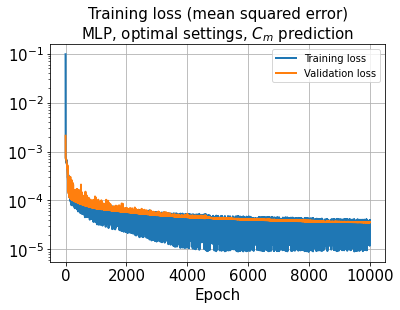

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

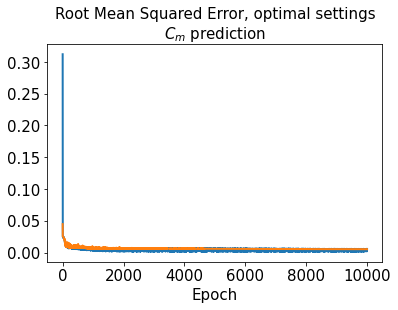

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

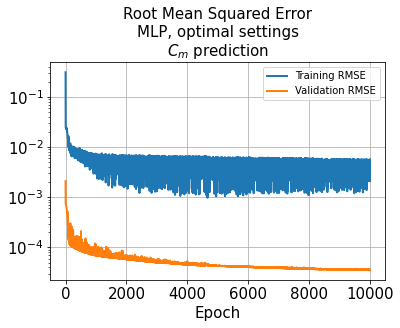

In [34]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [35]:
train_results = model.evaluate(x_train, y_train)

1750/1750 [==============================] - 5s 3ms/step - loss: 2.4659e-05 - rmse: 0.0041


In [36]:
val_results = model.evaluate(x_val, y_val)

501/501 [==============================] - 2s 3ms/step - loss: 3.5696e-05 - rmse: 0.0053


In [37]:
test_results = model.evaluate(x_test, y_test)

250/250 [==============================] - 1s 3ms/step - loss: 8.4788e-06 - rmse: 9.3712e-04


In [38]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

250/250 [==============================] - 0s 1ms/step


In [39]:
decoded_train_

array([[0.9651326 ],
       [0.96529996],
       [0.96527535],
       ...,
       [0.9622369 ],
       [0.96529245],
       [0.96329   ]], dtype=float32)

In [40]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [44]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [45]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [46]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_Flap1_2_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [90]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.42673441110313476
4.654963804014231


In [91]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.505174562132825
5.248508667270976


In [92]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.11178857034676201
4.405635283091793


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

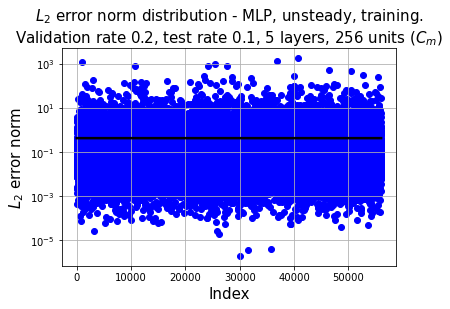

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

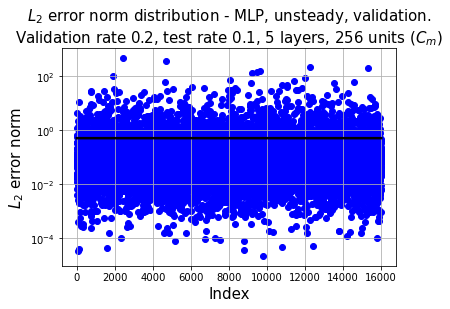

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

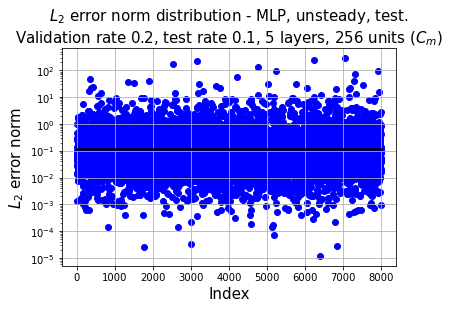

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

2500/2500 [==============================] - 4s 1ms/step


In [65]:
predicted.shape

(80000, 1)

In [84]:
x

array([[10.   ,  0.   ,  0.   ],
       [10.001,  0.   ,  0.   ],
       [10.002,  0.   ,  0.   ],
       ...,
       [14.997,  1.   ,  1.   ],
       [14.998,  1.   ,  1.   ],
       [14.999,  1.   ,  1.   ]])

In [66]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [67]:
index_train.shape

(56049,)

In [86]:
max(predicted)

array([0.98359394], dtype=float32)

In [87]:
l2_error(denormalize(predicted), denormalize(y))

0.431875964766224

In [93]:
l2_error(predicted, y)

0.004348397703847327

In [69]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
iTrain.shape

(56049, 1)

In [72]:
iVal.shape

(16042, 1)

In [73]:
iTest.shape

(8022, 1)

In [74]:
52499+15002+7501

75002

In [75]:
x += 10

In [88]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0014


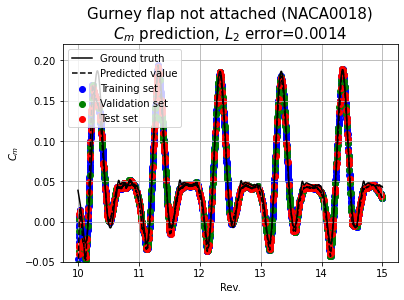

L2 error of Cm: 0.0008


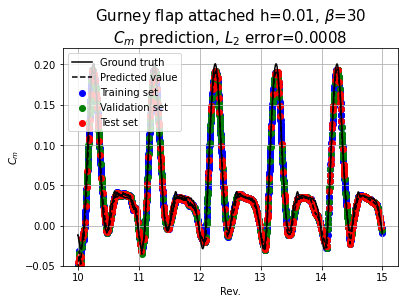

L2 error of Cm: 0.0006


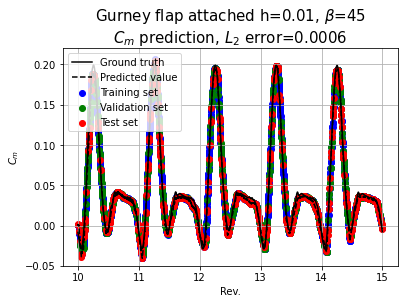

L2 error of Cm: 0.0005


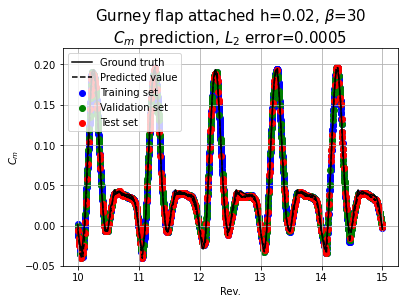

L2 error of Cm: 0.0005


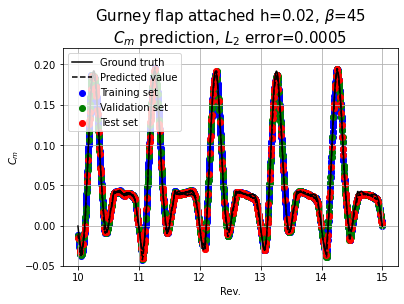

L2 error of Cm: 0.0004


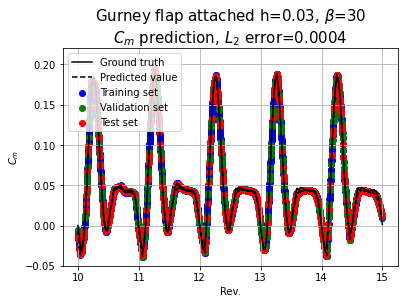

L2 error of Cm: 0.0009


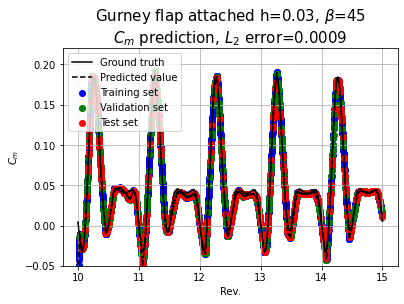

L2 error of Cm: 0.0172


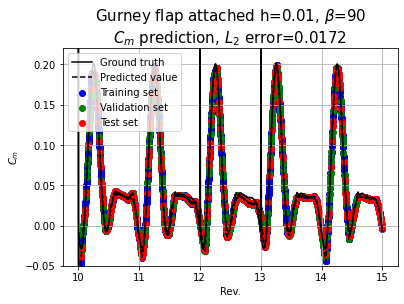

L2 error of Cm: 0.0009


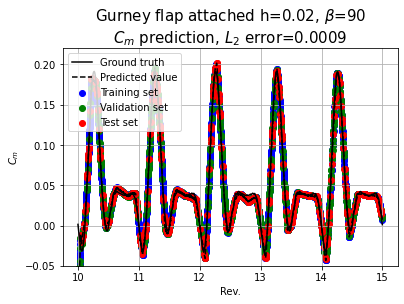

L2 error of Cm: 0.0007


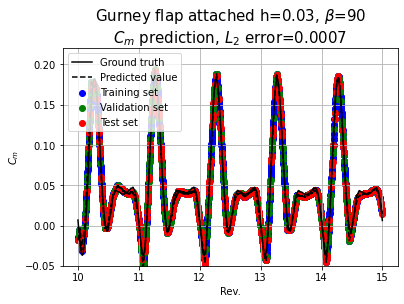

L2 error of Cm: 0.0006


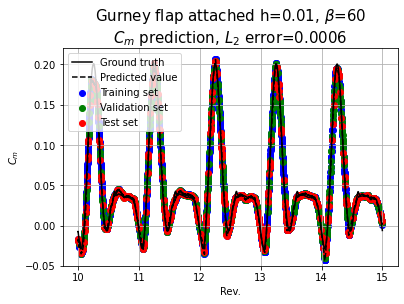

L2 error of Cm: 0.0004


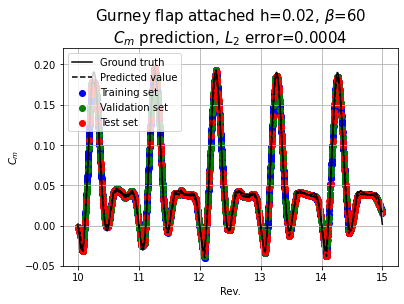

L2 error of Cm: 0.0005


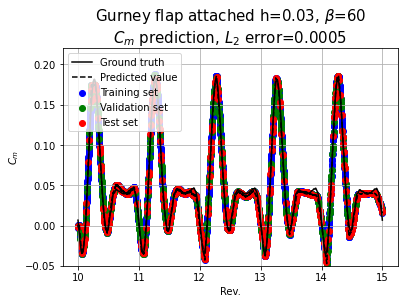

L2 error of Cm: 0.0006


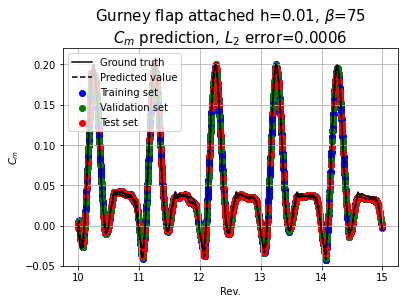

L2 error of Cm: 0.0007


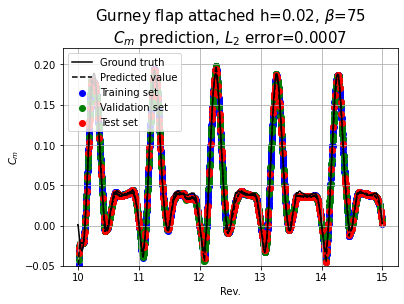

L2 error of Cm: 0.0007


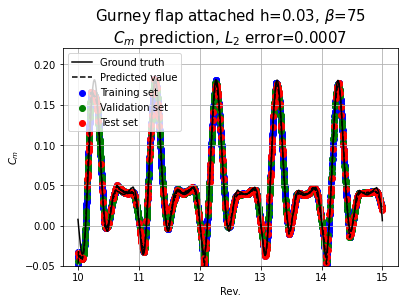

In [89]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0,16):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [83]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0014


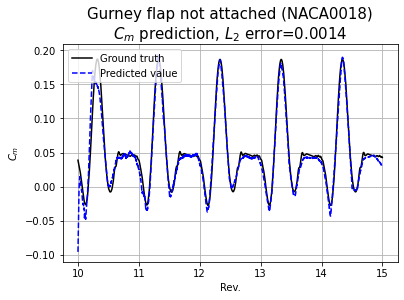

L2 error of Cm: 0.0008


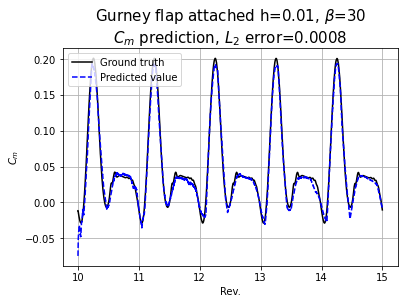

L2 error of Cm: 0.0006


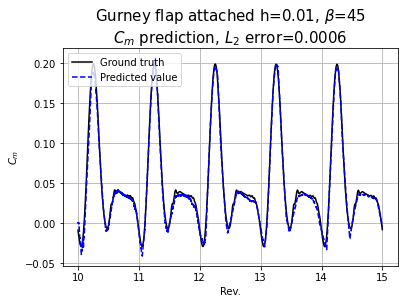

L2 error of Cm: 0.0005


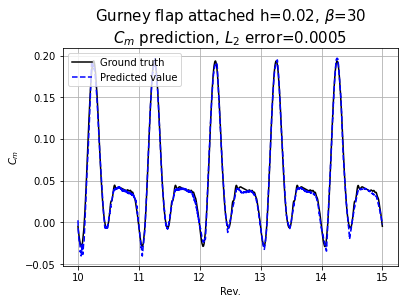

L2 error of Cm: 0.0005


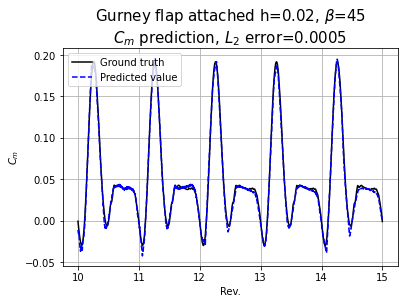

L2 error of Cm: 0.0004


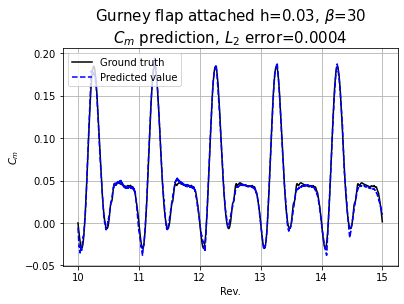

L2 error of Cm: 0.0009


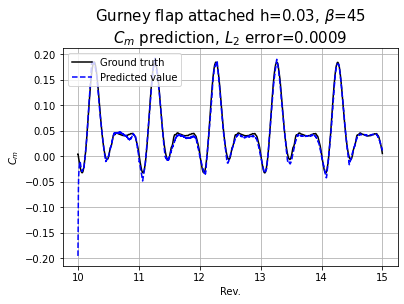

L2 error of Cm: 0.0172


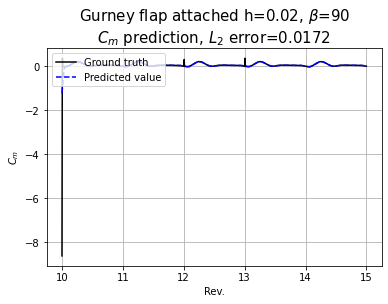

L2 error of Cm: 0.0009


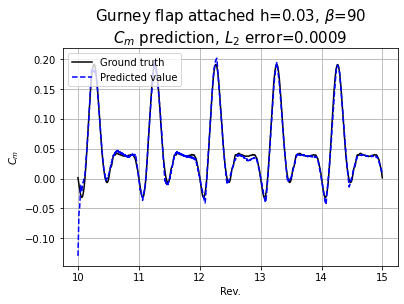

L2 error of Cm: 0.0007


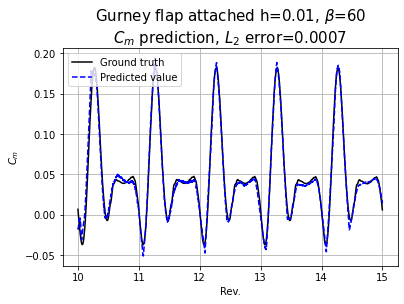

L2 error of Cm: 0.0006


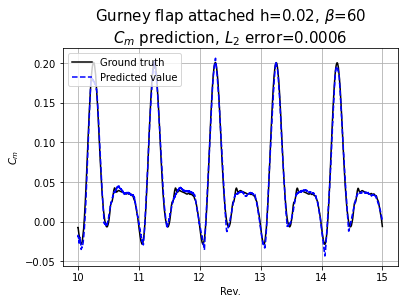

L2 error of Cm: 0.0004


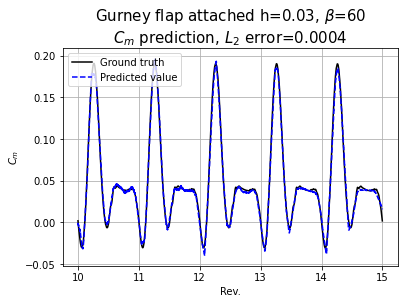

L2 error of Cm: 0.0005


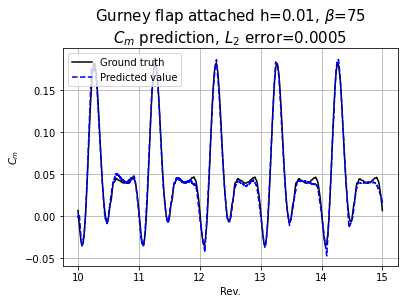

L2 error of Cm: 0.0006


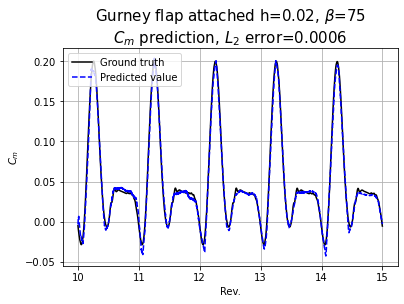

L2 error of Cm: 0.0007


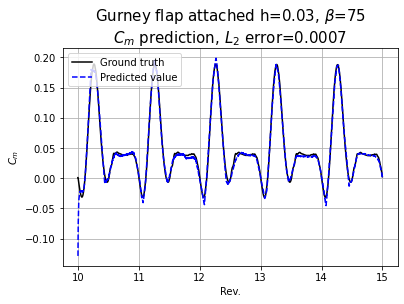

In [79]:
for i in range(0,15):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

ValueError: x and y must be the same size

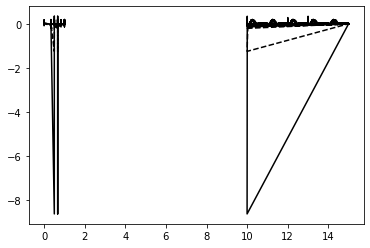

In [80]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

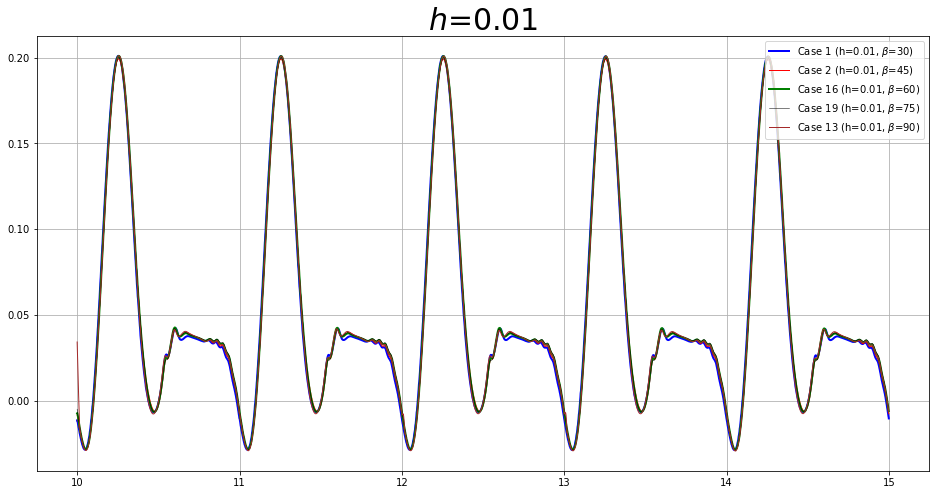

In [134]:
fig = plt.figure(figsize=[16,8])
plt.plot(t[:5000],cm[5000*1:5000*2], 'b', lw=2,label=r'Case 1 (h=0.01, $\beta$=30)')
plt.plot(t[:5000],cm[5000*2:5000*3], 'r', lw = 1,label=r'Case 2 (h=0.01, $\beta$=45)')
plt.plot(t[:5000],cm[5000*10:5000*11], 'g', lw = 2,label=r'Case 16 (h=0.01, $\beta$=60)')
plt.plot(t[:5000],cm[5000*13:5000*14], 'k', lw = 0.5,label=r'Case 19 (h=0.01, $\beta$=75)')
plt.plot(t[:5000],cm[5000*7:5000*8], 'brown', lw = 1,label=r'Case 13 (h=0.01, $\beta$=90)')
plt.title('$h$=0.01', fontsize=30)
plt.grid()
plt.legend(loc='upper right')
plt.show()

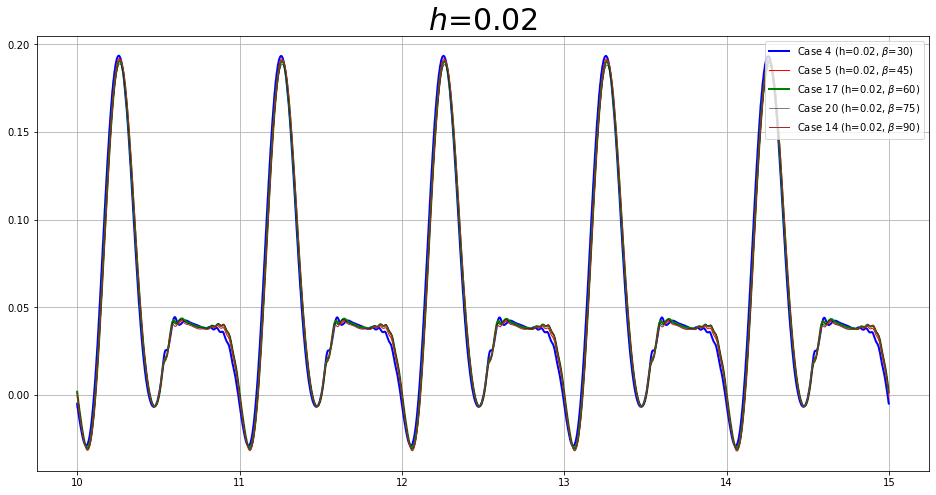

In [135]:
fig = plt.figure(figsize=[16,8])
plt.plot(t[:5000],cm[5000*3:5000*4], 'b', lw=2,label=r'Case 4 (h=0.02, $\beta$=30)')
plt.plot(t[:5000],cm[5000*4:5000*5], 'r', lw = 1,label=r'Case 5 (h=0.02, $\beta$=45)')
plt.plot(t[:5000],cm[5000*11:5000*12], 'g', lw = 2,label=r'Case 17 (h=0.02, $\beta$=60)')
plt.plot(t[:5000],cm[5000*14:5000*15], 'k', lw = 0.5,label=r'Case 20 (h=0.02, $\beta$=75)')
plt.plot(t[:5000],cm[5000*8:5000*9], 'brown', lw = 1,label=r'Case 14 (h=0.02, $\beta$=90)')
plt.title('$h$=0.02', fontsize=30)
plt.grid()
plt.legend(loc='upper right')
plt.show()

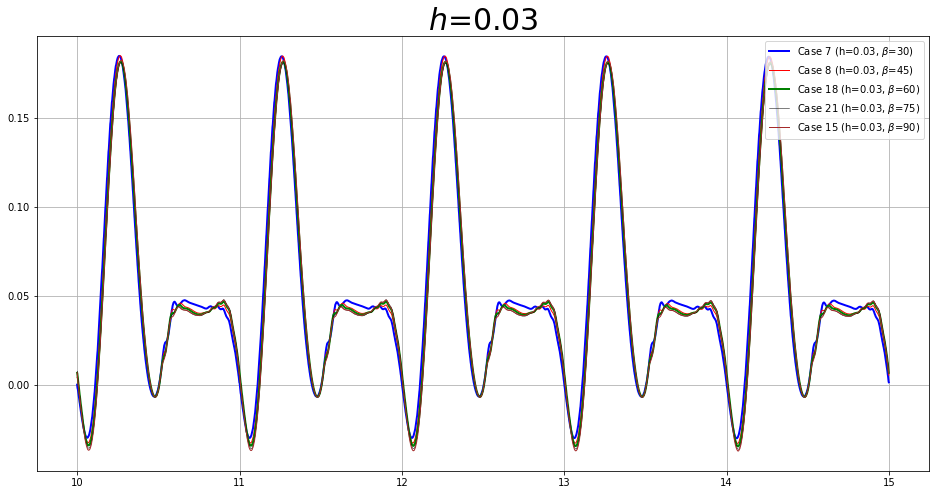

In [136]:
fig = plt.figure(figsize=[16,8])
plt.plot(t[:5000],cm[5000*5:5000*6], 'b', lw=2,label=r'Case 7 (h=0.03, $\beta$=30)')
plt.plot(t[:5000],cm[5000*6:5000*7], 'r', lw = 1,label=r'Case 8 (h=0.03, $\beta$=45)')
plt.plot(t[:5000],cm[5000*12:5000*13], 'g', lw = 2,label=r'Case 18 (h=0.03, $\beta$=60)')
plt.plot(t[:5000],cm[5000*15:5000*16], 'k', lw = 0.5,label=r'Case 21 (h=0.03, $\beta$=75)')
plt.plot(t[:5000],cm[5000*9:5000*10], 'brown', lw = 1,label=r'Case 15 (h=0.03, $\beta$=90)')
plt.title('$h$=0.03', fontsize=30)
plt.grid()
plt.legend(loc='upper right')
plt.show()